Objective: Predict prices for test (test.csv) dataset based on model build from train (train.csv) dataset  

Evaluation metric: "The RMSE between log of Saleprice and log of prediction". Need to convert salesprice to log value first. However seems that BoxCox does a better job here. For my testing I will include boxcox1p()

Original competition (explains the evaluation metric): https://www.kaggle.com/c/home-data-for-ml-course/overview/evaluation. My work is paying off, my submission on that site is #3 out of 38000, top .0001%

Original notebook source: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard  

Reference for good ideas: https://towardsdatascience.com/tricks-i-used-to-succeed-on-a-famous-kaggle-competition-adaa16c09f22

Original default score was .11543, new best score is 0.11353

Stacked and Ensembled Regressions to predict House Prices - improves score by ~ 5% 
How to Kaggle: https://www.youtube.com/watch?v=GJBOMWpLpTQ

References for stacking and ensembling:
https://www.kaggle.com/getting-started/18153
https://developer.ibm.com/technologies/artificial-intelligence/articles/stack-machine-learning-models-get-better-results

Author: Donald S  
Original: July 2020  

Need to submit every 2 months as the leaderboard will rollover after this 2 month period

<pre>
Typical flow of model building: Use GridSearch for determining Best parameters => **best_estimator_ 

good basic resource for models: 
https://scikit-learn.org/stable/modules/cross_validation.html
https://scikit-learn.org/stable/modules/grid_search.html

A search consists of:
an estimator (regressor or classifier such as sklearn.svm.SVC());  
a parameter space;  
a method for searching or sampling candidates;  
a cross-validation scheme; and  
a score function.  ****


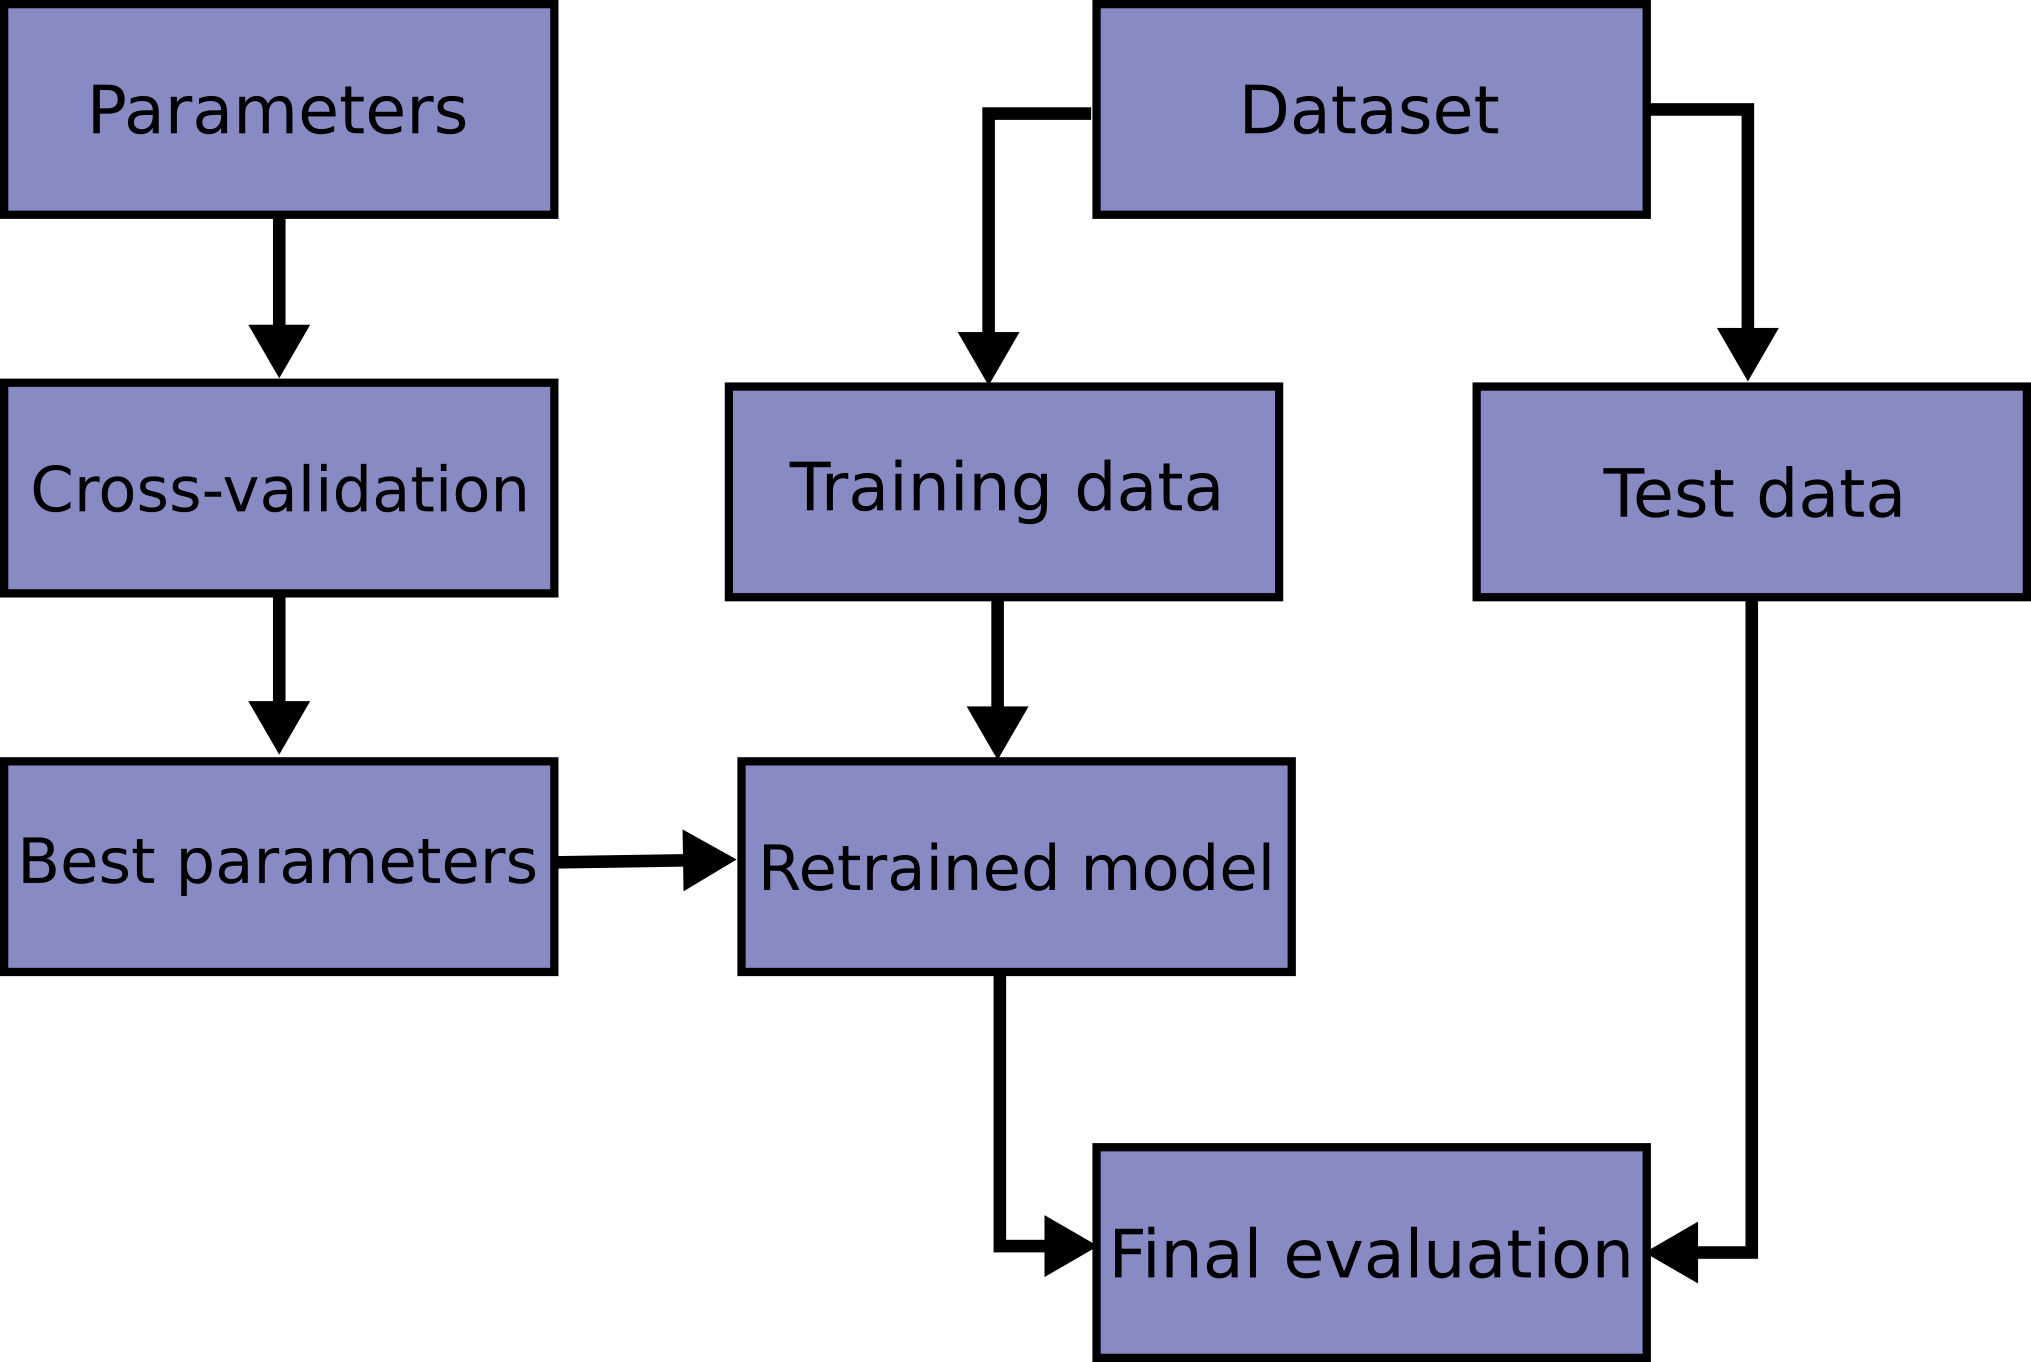

We will be using Stacking and Ensembling methods in this notebook. I will only create one dataset for all models to use, but you can create multiple datasets, each to be used by a different set of models, depending on your use case.

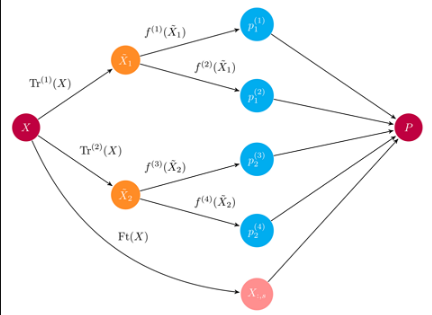

In [1]:
#import some necessary libraries
import datetime
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
#import warnings
#def ignore_warn(*args, **kwargs):
#    pass
#warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
import time

from scipy import stats
from scipy.stats import norm, skew, kurtosis, boxcox #for some statistics
from scipy.special import boxcox1p, inv_boxcox, inv_boxcox1p
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, LabelEncoder, RobustScaler, StandardScaler
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

from subprocess import check_output

StartTime = datetime.datetime.now()

In [2]:
class MyTimer():
    # usage:
    #with MyTimer():                            
    #    rf.fit(X_train, y_train)
    
    def __init__(self):
        self.start = time.time()
    def __enter__(self):
        return self
    def __exit__(self, exc_type, exc_val, exc_tb):
        end = time.time()
        runtime = end - self.start
        msg = 'The function took {time} seconds to complete'
        print(msg.format(time=runtime))

In [3]:
# default competition
competition = 'SR' # StackedRegression

try:
    a = check_output(["ls", "../input"]).decode("utf8") # new Kaggle competition
except:
    a=''
finally:
    print('')
try:
    b = check_output(["ls", "-rlt", "../StackedRegression"]).decode("utf8")
except:
    b=''
finally:
    print('')    
#if (competition == 'SRP_2'): # Stacked Regressions Part 2
if (len(a) > 0): # new competition
    competition = 'SR'
    train = pd.read_csv('../input/home-data-for-ml-course/train.csv')#,index_col='Id')
    test = pd.read_csv('../input/home-data-for-ml-course/test.csv')#,index_col='Id')
elif (len(b)): # run locally
    competition = 'SR'
    train = pd.read_csv('input/train.csv')
    test = pd.read_csv('input/test.csv')
else: # old competition
    competition = 'SRP_2'
    train = pd.read_csv('../input/train.csv')
    test = pd.read_csv('../input/test.csv')

In [4]:
##display the first five rows of the train dataset.
train.head(5)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL       65.000     8450   Pave   NaN      Reg   
1   2          20       RL       80.000     9600   Pave   NaN      Reg   
2   3          60       RL       68.000    11250   Pave   NaN      IR1   
3   4          70       RL       60.000     9550   Pave   NaN      IR1   
4   5          60       RL       84.000    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [5]:
##display the first five rows of the test dataset.
test.head(5)


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH       80.000    11622   Pave   NaN      Reg   
1  1462          20       RL       81.000    14267   Pave   NaN      IR1   
2  1463          60       RL       74.000    13830   Pave   NaN      IR1   
3  1464          60       RL       78.000     9978   Pave   NaN      IR1   
4  1465         120       RL       43.000     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      6    2010        WD         Normal  
1   12500      6    2010        WD         Normal  
2       0      3    2010        WD         Normal  
3       0      6    2010        WD         Normal  
4       0      1    2010        WD         Normal  

[5 rows x 80 columns]

#Data Processing

##Outliers

[Documentation][1] for the Ames Housing Data indicates that there are outliers present in the training data
[1]: http://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt

Let's explore these outliers


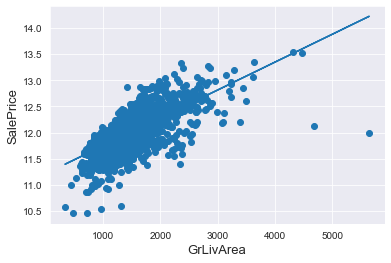

In [6]:
fig, ax = plt.subplots()
#ax.scatter(x = train['GrLivArea'], y = train['SalePrice']
ax.scatter(x = train['GrLivArea'], y = np.log(train['SalePrice']))
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)

#m, b = np.polyfit(train['GrLivArea'], train['SalePrice'], 1)
m, b = np.polyfit(train['GrLivArea'], np.log(train['SalePrice']), 1)
#m = slope, b=intercept
plt.plot(train['GrLivArea'], m*train['GrLivArea'] + b)

plt.show()


Edit: Look for fliers in other columns

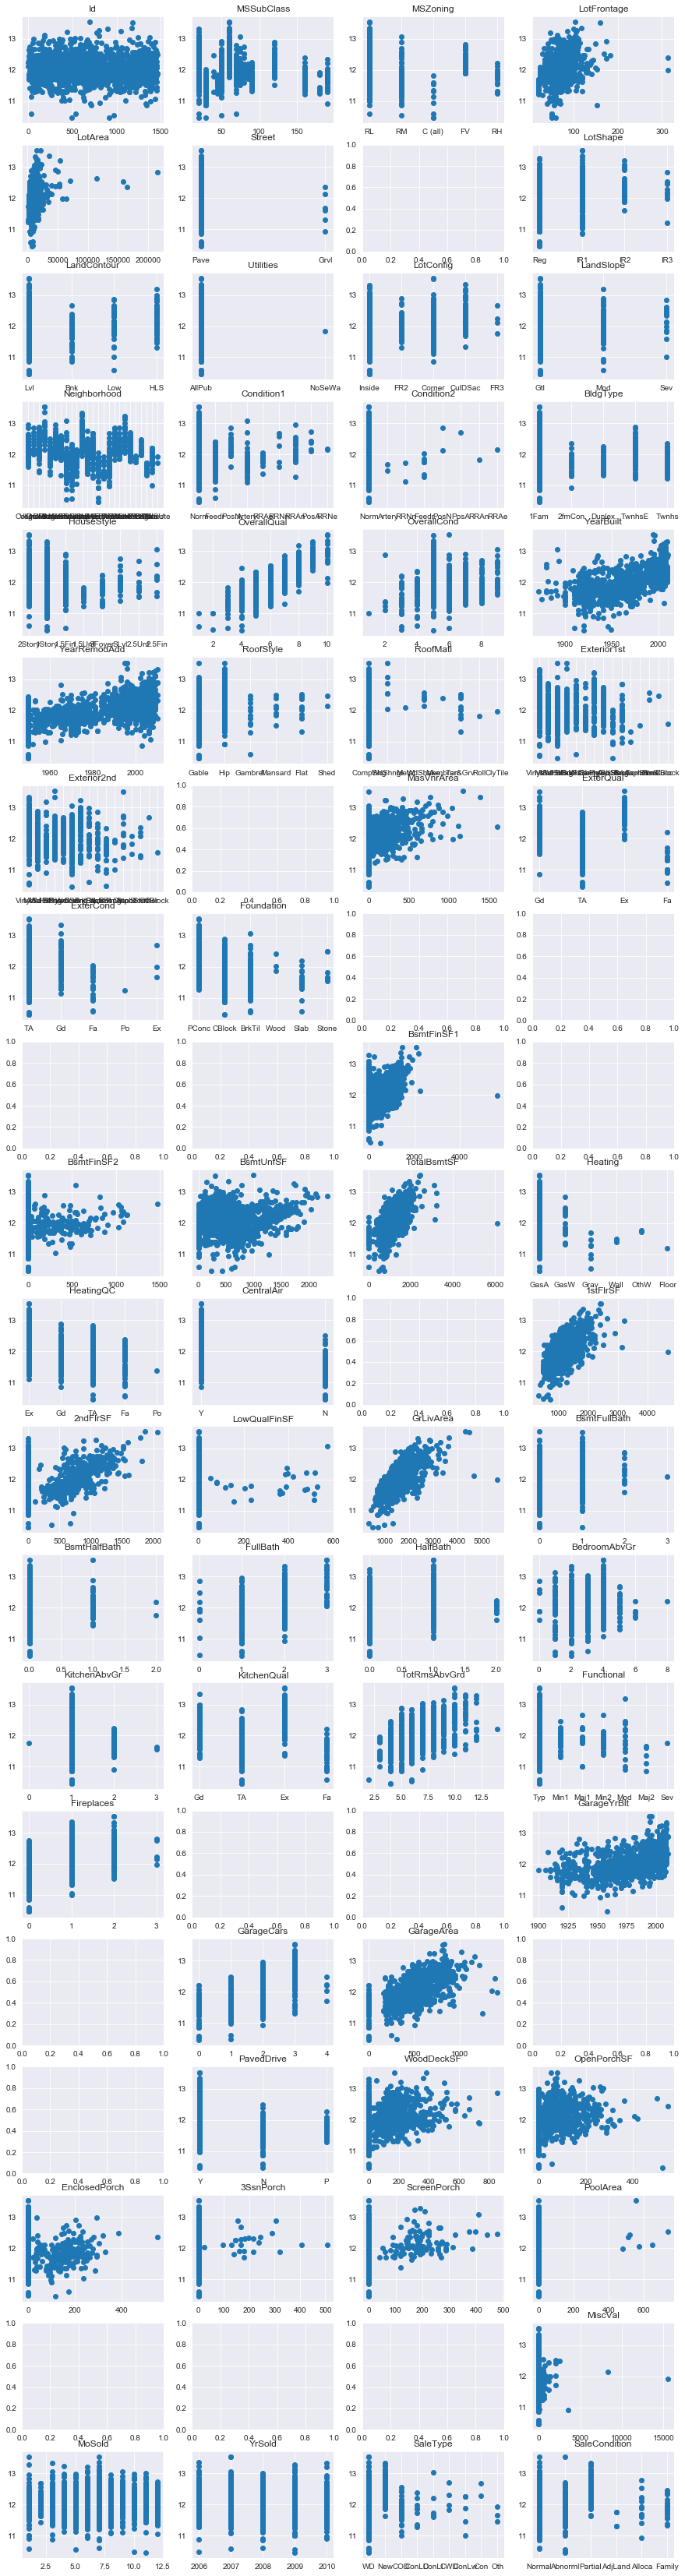

In [7]:
train.shape[1]
#a = int(np.sqrt(train.shape[1]))
a = 4
b = int(train.shape[1]/4)
r = int(train.shape[1]/a)
c = int(train.shape[1]/b)
i = 0
fig, ax = plt.subplots(nrows=r, ncols=c, figsize=(15, 60))
for row in ax:
    for col in row:
        try:
            col.scatter(x = train[train.columns[i]], y = np.log(train['SalePrice']))
            col.title.set_text(train.columns[i])
        except:
            temp=1
        #except Exception as e:
        #    print(e.message, e.args)
        finally:
            temp=1
        i = i + 1
        
plt.show()

More filtering of data to try

In [8]:
#Deleting outliers - none of these deletions help improve the score

#train = train.drop(train[(train['LotFrontage']>300) & (train['SalePrice']<400000)].index)
#train = train.drop(train[(train['LotArea']>100000) & (train['SalePrice']<400000)].index)
#train = train.drop(train[(train['BsmtFinSF1']>4000) & (train['SalePrice']<250000)].index)
#train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<250000)].index)

# only these 2 deletions help improve the score
train = train.drop(train[(train['OverallQual']>9) & (train['SalePrice']<220000)].index)
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)


We can see at the bottom right two with extremely large GrLivArea that are of a low price. These values are huge oultliers.
Therefore, we can safely delete them.

Edit: Think this deletion is safe to do as there are only 2 points and they seem to be abnormal, possibly data error

Safe to drop the Id column now as we are finished deleting points (otherwise our Train_ID list will be smaller than y_train

In [9]:
test

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0     1461          20       RH       80.000    11622   Pave   NaN      Reg   
1     1462          20       RL       81.000    14267   Pave   NaN      IR1   
2     1463          60       RL       74.000    13830   Pave   NaN      IR1   
3     1464          60       RL       78.000     9978   Pave   NaN      IR1   
4     1465         120       RL       43.000     5005   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1454  2915         160       RM       21.000     1936   Pave   NaN      Reg   
1455  2916         160       RM       21.000     1894   Pave   NaN      Reg   
1456  2917          20       RL      160.000    20000   Pave   NaN      Reg   
1457  2918          85       RL       62.000    10441   Pave   NaN      Reg   
1458  2919          60       RL       74.000     9627   Pave   NaN      Reg   

     LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence  \
0            Lvl    AllPub  ...         120        0    NaN  MnPrv   
1            Lvl    AllPub  ...           0        0    NaN    NaN   
2            Lvl    AllPub  ...           0        0    NaN  MnPrv   
3            Lvl    AllPub  ...           0        0    NaN    NaN   
4            HLS    AllPub  ...         144        0    NaN    NaN   
...          ...       ...  ...         ...      ...    ...    ...   
1454         Lvl    AllPub  ...           0        0    NaN    NaN   
1455         Lvl    AllPub  ...           0        0    NaN    NaN   
1456         Lvl    AllPub  ...           0        0    NaN    NaN   
1457         Lvl    AllPub  ...           0        0    NaN  MnPrv   
1458         Lvl    AllPub  ...           0        0    NaN    NaN   

     MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  
0            NaN       0      6    2010        WD         Normal  
1           Gar2   12500      6    2010        WD         Normal  
2            NaN       0      3    2010        WD         Normal  
3            NaN       0      6    2010        WD         Normal  
4            NaN       0      1    2010        WD         Normal  
...          ...     ...    ...     ...       ...            ...  
1454         NaN       0      6    2006        WD         Normal  
1455         NaN       0      4    2006        WD        Abnorml  
1456         NaN       0      9    2006        WD        Abnorml  
1457        Shed     700      7    2006        WD         Normal  
1458         NaN       0     11    2006        WD         Normal  

[1459 rows x 80 columns]

In [10]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']


#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1458, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1458, 80) 
The test data size after dropping Id feature is : (1459, 79) 


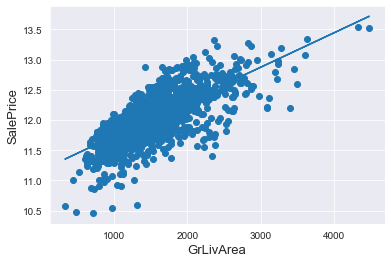

In [11]:
#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], np.log(train['SalePrice']))
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
#m, b = np.polyfit(train['GrLivArea'], train['SalePrice'], 1)
m, b = np.polyfit(train['GrLivArea'], np.log(train['SalePrice']), 1)
#m = slope, b=intercept
plt.plot(train['GrLivArea'], m*train['GrLivArea'] + b)
plt.show()

This chart does not look linear, or at least the line is not matching the data across the entire x axis. Looks like a drop off for High GrLivArea, seems home buyers are not willing to pay a corresponding amount extra for the large living area, looking for a "volume discount" maybe...
Lets look at this closer, first fit a line, next try a polynomial fit to compare

[5.70762509e-04 1.11618915e+01]


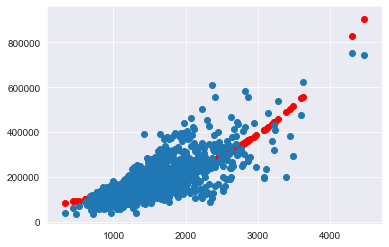

In [12]:
# linear 
x_data = train['GrLivArea']
y_data = train['SalePrice']
log_y_data = np.log(train['SalePrice'])

curve_fit = np.polyfit(x_data, log_y_data, 1)
print(curve_fit)
y = np.exp(1.11618915e+01) * np.exp(5.70762509e-04*x_data)
plt.plot(x_data, y_data, "o")
plt.scatter(x_data, y,c='red')

Need to look at the y_log relationship since that is what we will be predicting in the model (convert back later)

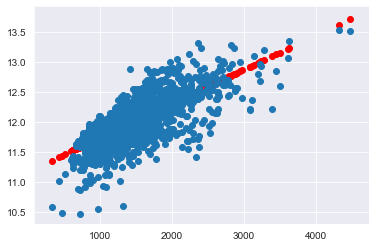

In [13]:
# linear with log y
y = np.exp(1.11618915e+01) * np.exp(5.70762509e-04*x_data)
plt.plot(x_data, np.log(y_data), "o")
plt.scatter(x_data, np.log(y),c='red')

Now we look at a polynomial fit

In [14]:
# polynomial
x_data = train['GrLivArea']
y_data = train['SalePrice']
log_y_data = np.log(train['SalePrice'])
curve_fit_gla = np.polyfit(x_data, y_data, 2)
y = curve_fit_gla[2] + curve_fit_gla[1]*x_data + curve_fit_gla[0]*x_data**2

plot the poly fit data

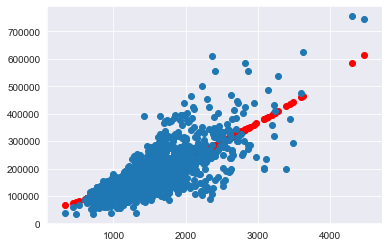

In [15]:
plt.plot(x_data, y_data, "o")
plt.scatter(x_data, y,c='red')

Now lets use a log y scale

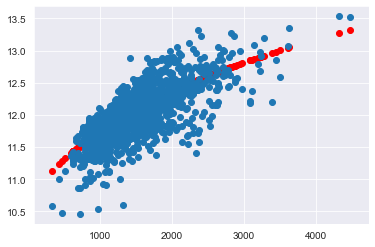

In [16]:
# polynomial with log y
plt.plot(x_data, np.log(y_data), "o")
plt.scatter(x_data, np.log(y),c='red')

In [17]:
y_data #HERE

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1458, dtype: int64

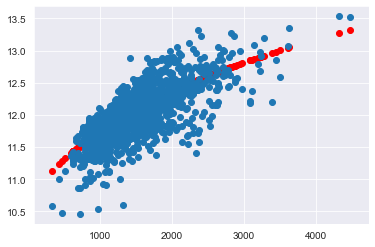

In [18]:
# polynomial with log y
plt.plot(x_data, np.log(y_data), "o")
plt.scatter(x_data, np.log(y),c='red')

This fit looks like it may be better, will add a column to the dataset using this equation after it is merged (all_data)

y = curve_fit_gla[2] + curve_fit_gla[1]*x_data + curve_fit_gla[0]*x_data**2

x_data = train['GrLivArea']


###Note : 
 Outliers removal is note always safe.  We decided to delete these two as they are very huge and  really  bad ( extremely large areas for very low  prices). 

There are probably others outliers in the training data.   However, removing all them  may affect badly our models if ever there were also  outliers  in the test data. That's why , instead of removing them all, we will just manage to make some of our  models robust on them. You can refer to  the modelling part of this notebook for that. 

Edit: todo - look for other outliers in all columns. Maybe better to use StandardScaler() and np.clip

##Target Variable

**SalePrice** is the variable we need to predict. So let's do some analysis on this variable first.


 mu = 180932.92 and sigma = 79467.79, skew = 1.88 kurtosis = 6.50



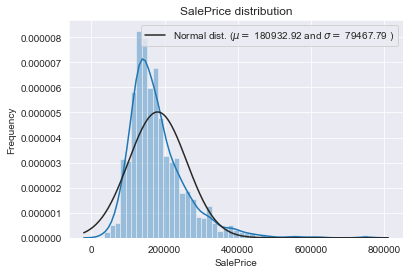

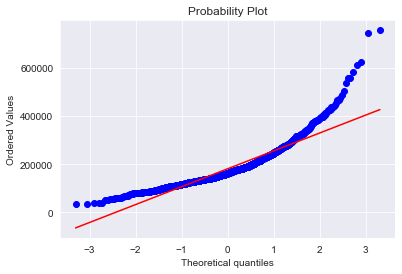

In [19]:
sns.distplot(train['SalePrice'] , fit=norm)

_skew = skew(train['SalePrice'])
_kurtosis = kurtosis(train['SalePrice'])

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}, skew = {:.2f} kurtosis = {:.2f}\n'.format(mu, sigma, _skew, _kurtosis))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


The target variable is right skewed.  As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.


**Transformation of the target variable**
 
Default is to use log1p as this is included in the evaluation metric, rmsle 
Edit: also trying box-cox transform.
The Box-Cox transform is given by:
<pre>
y = (x**lmbda - 1) / lmbda,  for lmbda > 0  
    log(x),                  for lmbda = 0
    
y = ((1+x)**lmbda - 1) / lmbda  if lmbda != 0
    log(1+x)                    if lmbda == 0

In [20]:
#We try the numpy function log1p which  applies log(1+x) to all elements of the column

# option 1 - original
#train["SalePrice"] = np.log1p(train["SalePrice"])

# Option 2: use box-cox transform - this performs better than the log(1+x)
# try different alpha values  between 0 and 1
lam_l = 0.35 # optimized value
train["SalePrice"] = boxcox1p(train["SalePrice"], lam_l) 

# Option 3: boxcox letting the algorithm select lmbda based on least-likelihood calculation
#train["SalePrice"], lam_l = boxcox1p(x=train["SalePrice"], lmbda=None)

# option 4 - use log, compare to log1p => score is same
#train["SalePrice"] = np.log(train["SalePrice"])

Here is the difference between BoxCox and Log values, the difference is substantial at the value of a house

C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


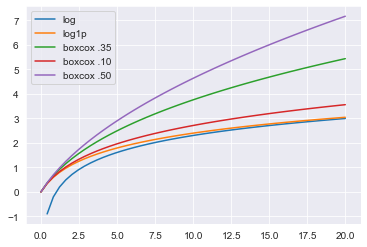

C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


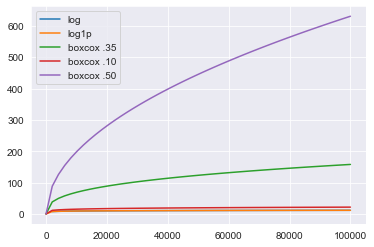

In [21]:
x = np.linspace(0, 20)
y1 = np.log(x)
y2 = np.log1p(x)
y3 = boxcox1p(x, 0.35)
y4 = boxcox1p(x, 0.10)
y5 = boxcox1p(x, 0.50)
plt.plot(x,y1,label='log') 
plt.plot(x,y2,label='log1p') 
plt.plot(x,y3,label='boxcox .35') 
plt.plot(x,y4,label='boxcox .10') 
plt.plot(x,y5,label='boxcox .50') 
plt.legend()
plt.show()

x = np.linspace(0, 100000)
y1 = np.log(x)
y2 = np.log1p(x)
y3 = boxcox1p(x, 0.35)
y4 = boxcox1p(x, 0.10)
y5 = boxcox1p(x, 0.50)
plt.plot(x,y1,label='log') 
plt.plot(x,y2,label='log1p') 
plt.plot(x,y3,label='boxcox .35') 
plt.plot(x,y4,label='boxcox .10') 
plt.plot(x,y5,label='boxcox .50') 
plt.legend()
plt.show()


 mu = 191.18 and sigma = 27.62, skew = 0.69 kurtosis = 1.31



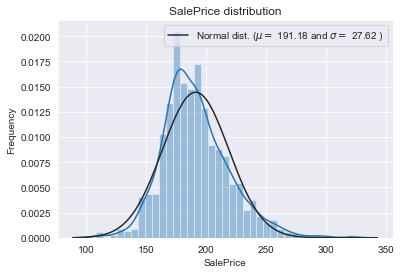

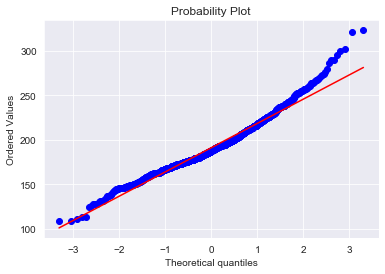

In [22]:
# to revert back use y = inv_boxcox1p(x, lam_l) => train["SalePrice"] = inv_boxcox1p(train["SalePrice"], lam_l)
# think the underlying formula is this: # pred_y = np.power((y_box * lambda_) + 1, 1 / lambda_) - 1

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

_skew = skew(train['SalePrice'])
_kurtosis = kurtosis(train['SalePrice'])

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}, skew = {:.2f} kurtosis = {:.2f}\n'.format(mu, sigma, _skew, _kurtosis))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


The skew seems now corrected and the data appears more normally distributed. 

Edit: Both distributions have a positive kurtosis, which means there is a steep dropoff in the curve from the center, or the tails have few points. Skewness is close to 0 now, so that metric is closer to a normal distribution. BoxCox1p() has worse numbers than log() but still performs better in the predictions, will keep BoxCox1p

##Features engineering

let's first  concatenate the train and test data in the same dataframe

In [23]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


Then, add this column from previous investigation to the dataset y = curve_fit_gla[2] + curve_fit_gla[1]x_data + curve_fit_gla[0]x_data**2

In [24]:
def add_gla(row, p):
    return (p[2] + p[1]*row.GrLivArea + p[0]*(row.GrLivArea**2))

#all_data['GrLivAreaPoly'] = all_data.apply(lambda row: add_gla(row,curve_fit_gla), axis=1)

* save this inv function for later, may need it:
<pre>
import cmath
d = (b**2) - (4*a*c)
print(-b-cmath.sqrt(d))/(2*a)
print(-b+cmath.sqrt(d))/(2*a)
def add_gla3(row, p):
    return (p[2] + p[1]*row.GrLivArea + p[0]*(row.GrLivArea**2)) <-- change this function
all_data['GrLivAreaPoly2'] = all_data.apply(lambda row: add_gla3(row,curve_fit_gla), axis=1)

* check and compare the new columns

Now for r squared calculations we need to limit the comparison to only the train data since the test data does not have a Sales Price to compare to

In [25]:
all_data.GrLivArea[:ntrain]

0       1710
1       1262
2       1786
3       1717
4       2198
        ... 
1453    1647
1454    2073
1455    2340
1456    1078
1457    1256
Name: GrLivArea, Length: 1458, dtype: int64

Compare the r-squared values

In [26]:
correlation_matrix = np.corrcoef(all_data.GrLivArea[:ntrain], y_train)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print(r_squared)

0.5445354638265302


My equation has a worse correlation... will need to investigate this later. For now, i will simplify an just use a direct function...

Compare the r-squared values for different functions

In [27]:
for i in range(1,11,1):
    j = i/10
    correlation_matrix = np.corrcoef(all_data.GrLivArea[:ntrain]**j, y_train)
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2

    print(j, r_squared)

0.1 0.5429614947322926
0.2 0.5453735215818089
0.3 0.5472321377037026
0.4 0.5485354482960584
0.5 0.5492808172916986
0.6 0.5494651982899944
0.7 0.5490854594527175
0.8 0.5481386989774741
0.9 0.5466225486788447
1.0 0.5445354638265302


use the 0.3 value as the improvement below this value is minimal

In [28]:
def add_gla2(row, p):
    return (row.GrLivArea**p)

#all_data['GrLivAreaRoot'] = all_data.apply(lambda row: add_gla2(row,0.3), axis=1)

In [29]:
all_data.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL       65.000     8450   Pave   NaN      Reg   
1          20       RL       80.000     9600   Pave   NaN      Reg   
2          60       RL       68.000    11250   Pave   NaN      IR1   
3          70       RL       60.000     9550   Pave   NaN      IR1   
4          60       RL       84.000    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC Fence  \
0         Lvl    AllPub    Inside  ...           0        0    NaN   NaN   
1         Lvl    AllPub       FR2  ...           0        0    NaN   NaN   
2         Lvl    AllPub    Inside  ...           0        0    NaN   NaN   
3         Lvl    AllPub    Corner  ...           0        0    NaN   NaN   
4         Lvl    AllPub       FR2  ...           0        0    NaN   NaN   

  MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
0         NaN       0       2    2008        WD         Normal  
1         NaN       0       5    2007        WD         Normal  
2         NaN       0       9    2008        WD         Normal  
3         NaN       0       2    2006        WD        Abnorml  
4         NaN       0      12    2008        WD         Normal  

[5 rows x 79 columns]

###Missing Data

In [30]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(30)

Missing Ratio
PoolQC               99.691
MiscFeature          96.400
Alley                93.212
Fence                80.425
FireplaceQu          48.680
LotFrontage          16.661
GarageFinish          5.451
GarageYrBlt           5.451
GarageQual            5.451
GarageCond            5.451
GarageType            5.382
BsmtExposure          2.811
BsmtCond              2.811
BsmtQual              2.777
BsmtFinType2          2.743
BsmtFinType1          2.708
MasVnrType            0.823
MasVnrArea            0.788
MSZoning              0.137
BsmtFullBath          0.069
BsmtHalfBath          0.069
Utilities             0.069
Functional            0.069
Exterior2nd           0.034
Exterior1st           0.034
SaleType              0.034
BsmtFinSF1            0.034
BsmtFinSF2            0.034
BsmtUnfSF             0.034
Electrical            0.034

separate into lists for each data type

In [31]:
all_numerical = all_data.select_dtypes(include=np.number).columns.tolist()
missing_data.index.values.tolist()
missing_df = all_data[missing_data.index.values.tolist()]
missing_numerical = missing_df.select_dtypes(include=np.number).columns.tolist()

Text(0.5, 1.0, 'Percent missing data by feature')

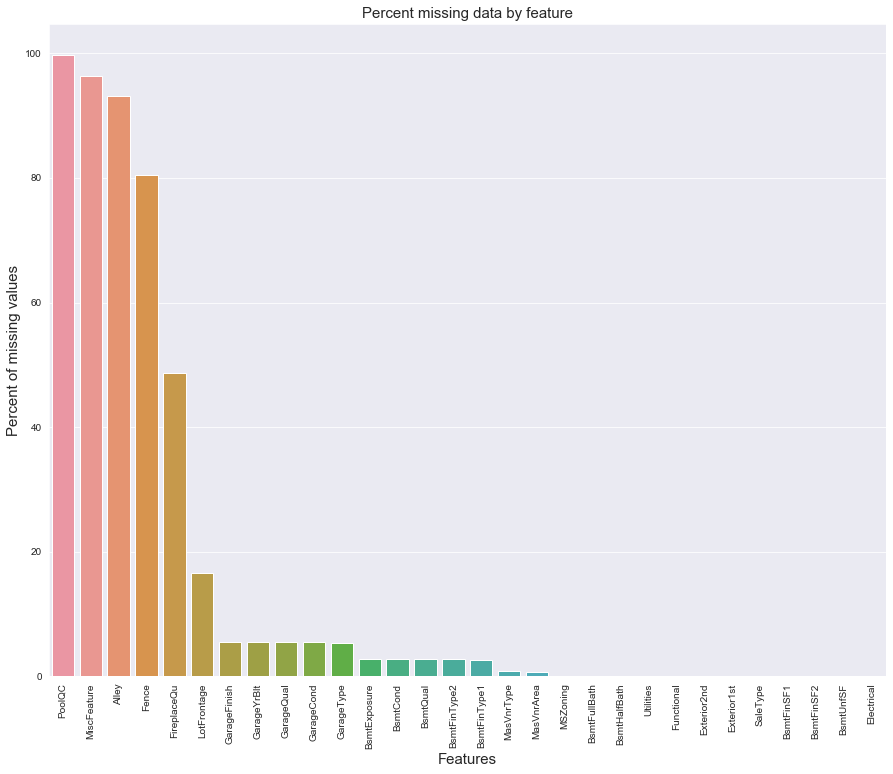

In [32]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

**Data Correlation**


Cross Correlation chart to view collinearity within the features. Kendall's seems appropriate as the Output Variable is numerical and much of the input is categorical. Here is a chart to guide you to which method to use based on your dataset.

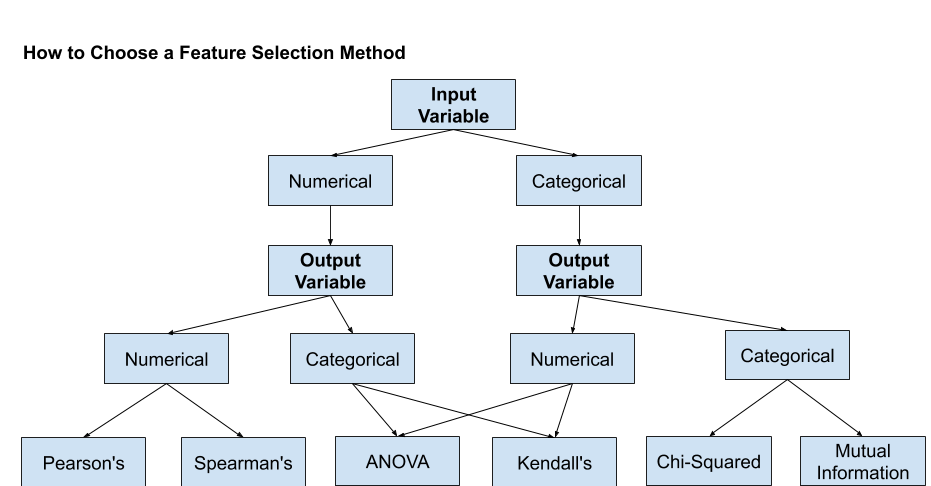

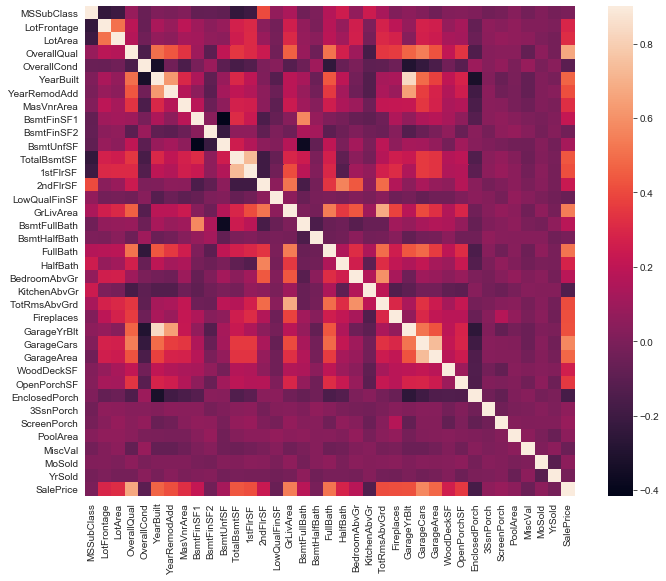

In [33]:
#Correlation map to see how features are correlated with each other and with SalePrice
corrmat = train.corr(method='kendall')
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

Look at some correlation values in a list format

In [34]:
print (corrmat['SalePrice'].sort_values(ascending=False)[:5], '\n')
print (corrmat['SalePrice'].sort_values(ascending=False)[-5:])

SalePrice     1.000
OverallQual   0.671
GarageCars    0.573
GrLivArea     0.545
FullBath      0.519
Name: SalePrice, dtype: float64 

MiscVal         -0.051
LowQualFinSF    -0.055
OverallCond     -0.103
KitchenAbvGr    -0.135
EnclosedPorch   -0.172
Name: SalePrice, dtype: float64


In [35]:
all_data.shape

(2917, 79)

###Imputing missing values 

Some imputation methods result in biased parameter estimates, such as means, correlations, and regression coefficients, unless the data are Missing Completely at Random (MCAR). The bias is often worse than with listwise deletion, the default in most software.  

The extent of the bias depends on many factors, including the imputation method, the missing data mechanism, the proportion of the data that is missing, and the information available in the data set.  

Moreover, all single imputation methods underestimate standard errors.

Reference: https://www.theanalysisfactor.com/mar-and-mcar-missing-data/

Multiple imputation can overcome most of these shortcomings, but at the expense of time. They take more time to implement and run

Reference: https://www.theanalysisfactor.com/missing-data-two-recommended-solutions/

Methods: (can use in pipeline - estimator = make_pipeline(imputer, regressor) ) reference: https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py  

Simple Regression:

from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean') for numerical
imp = SimpleImputer(strategy="most_frequent") for categorical

Multivariate Regression:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)

kNN:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2, weights="uniform")

Other:
Stochastic regression, Bayesian Linear Regression, Bayesian Binary Logistic Regression
https://pypi.org/project/autoimpute/

We impute them  by proceeding sequentially  through features with missing values 

- **PoolQC** : data description says NA means "No  Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general. 
- **MiscFeature** : data description says NA means "no misc feature"
- **Alley** : data description says NA means "no alley access"
- **Fence** : data description says NA means "no fence"
- **FireplaceQu** : data description says NA means "no fireplace"
- **GarageType, GarageFinish, GarageQual and GarageCond** : Replacing missing data with None
- **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2** : For all these categorical basement-related features, NaN means that there is no  basement.

In [36]:
ImputeToNone = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature"]
for col in ImputeToNone:  
    all_data[col].fillna("None", inplace=True)

- **LotFrontage** : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can **fill in missing values by the median LotFrontage of the neighborhood**.

In [37]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
#all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
#    lambda x: x.fillna(x.median()))

try another method, imputation

In [38]:
# selecting another column
all_data[missing_numerical]

LotFrontage  GarageYrBlt  MasVnrArea  BsmtFullBath  BsmtHalfBath  \
0          65.000     2003.000     196.000         1.000         0.000   
1          80.000     1976.000       0.000         0.000         1.000   
2          68.000     2001.000     162.000         1.000         0.000   
3          60.000     1998.000       0.000         1.000         0.000   
4          84.000     2000.000     350.000         1.000         0.000   
...           ...          ...         ...           ...           ...   
2912       21.000          nan       0.000         0.000         0.000   
2913       21.000     1970.000       0.000         0.000         0.000   
2914      160.000     1960.000       0.000         1.000         0.000   
2915       62.000          nan       0.000         0.000         1.000   
2916       74.000     1993.000      94.000         0.000         0.000   

      BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  
0        706.000       0.000    150.000  
1        978.000       0.000    284.000  
2        486.000       0.000    434.000  
3        216.000       0.000    540.000  
4        655.000       0.000    490.000  
...          ...         ...        ...  
2912       0.000       0.000    546.000  
2913     252.000       0.000    294.000  
2914    1224.000       0.000      0.000  
2915     337.000       0.000    575.000  
2916     758.000       0.000    238.000  

[2917 rows x 8 columns]

Look for any good correlations to use for imputation

In [39]:
corrmat_all = all_data[all_numerical].corr(method='kendall')
corrmat_all

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  \
MSSubClass          1.000       -0.272   -0.235        0.076       -0.051   
LotFrontage        -0.272        1.000    0.512        0.173       -0.083   
LotArea            -0.235        0.512    1.000        0.150       -0.062   
OverallQual         0.076        0.173    0.150        1.000       -0.162   
OverallCond        -0.051       -0.083   -0.062       -0.162        1.000   
YearBuilt           0.007        0.139    0.086        0.518       -0.336   
YearRemodAdd        0.002        0.096    0.071        0.455       -0.058   
MasVnrArea         -0.006        0.210    0.151        0.352       -0.154   
BsmtFinSF1         -0.076        0.116    0.122        0.135       -0.019   
BsmtFinSF2         -0.084        0.039    0.049       -0.083        0.087   
BsmtUnfSF          -0.080        0.061    0.043        0.183       -0.094   
TotalBsmtSF        -0.225        0.269    0.245        0.359       -0.175   
1stFlrSF           -0.204        0.317    0.308        0.312       -0.145   
2ndFlrSF            0.402       -0.002    0.044        0.205       -0.010   
LowQualFinSF        0.053       -0.036   -0.014       -0.044        0.017   
GrLivArea           0.132        0.248    0.282        0.449       -0.147   
BsmtFullBath       -0.041        0.088    0.089        0.127       -0.041   
BsmtHalfBath        0.006       -0.025    0.007       -0.041        0.082   
FullBath            0.177        0.169    0.180        0.500       -0.261   
HalfBath            0.239        0.060    0.102        0.264       -0.099   
BedroomAbvGr        0.064        0.224    0.231        0.074       -0.012   
KitchenAbvGr        0.240        0.008   -0.022       -0.152       -0.079   
TotRmsAbvGrd        0.121        0.269    0.282        0.318       -0.107   
Fireplaces          0.006        0.205    0.253        0.361       -0.050   
GarageYrBlt         0.053        0.090    0.052        0.493       -0.309   
GarageCars          0.016        0.277    0.269        0.545       -0.231   
GarageArea         -0.037        0.263    0.252        0.430       -0.170   
WoodDeckSF          0.014        0.088    0.131        0.231       -0.029   
OpenPorchSF         0.021        0.128    0.125        0.347       -0.143   
EnclosedPorch      -0.002       -0.074   -0.034       -0.163        0.119   
3SsnPorch          -0.029        0.008    0.023        0.018        0.041   
ScreenPorch        -0.033        0.069    0.073        0.025        0.045   
PoolArea           -0.003        0.063    0.063        0.023       -0.017   
MiscVal            -0.027        0.031    0.060       -0.067        0.056   
MoSold              0.010        0.010    0.004        0.021       -0.004   
YrSold             -0.015        0.003   -0.017       -0.012        0.032   

               YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  \
MSSubClass         0.007         0.002      -0.006      -0.076      -0.084   
LotFrontage        0.139         0.096       0.210       0.116       0.039   
LotArea            0.086         0.071       0.151       0.122       0.049   
OverallQual        0.518         0.455       0.352       0.135      -0.083   
OverallCond       -0.336        -0.058      -0.154      -0.019       0.087   
YearBuilt          1.000         0.650       0.299       0.168      -0.077   
YearRemodAdd       0.650         1.000       0.187       0.068      -0.094   
MasVnrArea         0.299         0.187       1.000       0.212      -0.025   
BsmtFinSF1         0.168         0.068       0.212       1.000       0.041   
BsmtFinSF2        -0.077        -0.094      -0.025       0.041       1.000   
BsmtUnfSF          0.078         0.113       0.040      -0.390      -0.238   
TotalBsmtSF        0.307         0.215       0.294       0.324       0.051   
1stFlrSF           0.223         0.173       0.294       0.246       0.044   
2ndFlrSF           0.006         0.064       0.016      -0.153      -0.10

Look for other correlations, maybe all the basement olumns will correlate like BsmtFullBath and BsmtFinSF1 and Fin vs Unf have negative correlation. Both make sense...

In [40]:
corrmat2 = all_data[missing_numerical].corr(method='kendall')
corrmat2
#print (corrmat2['LotFrontage'].sort_values(ascending=False), '\n')

LotFrontage  GarageYrBlt  MasVnrArea  BsmtFullBath  \
LotFrontage         1.000        0.090       0.210         0.088   
GarageYrBlt         0.090        1.000       0.235         0.105   
MasVnrArea          0.210        0.235       1.000         0.144   
BsmtFullBath        0.088        0.105       0.144         1.000   
BsmtHalfBath       -0.025       -0.067       0.030        -0.153   
BsmtFinSF1          0.116        0.093       0.212         0.565   
BsmtFinSF2          0.039       -0.113      -0.025         0.158   
BsmtUnfSF           0.061        0.117       0.040        -0.344   

              BsmtHalfBath  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  
LotFrontage         -0.025       0.116       0.039      0.061  
GarageYrBlt         -0.067       0.093      -0.113      0.117  
MasVnrArea           0.030       0.212      -0.025      0.040  
BsmtFullBath        -0.153       0.565       0.158     -0.344  
BsmtHalfBath         1.000       0.079       0.130     -0.086  
BsmtFinSF1           0.079       1.000       0.041     -0.390  
BsmtFinSF2           0.130       0.041       1.000     -0.238  
BsmtUnfSF           -0.086      -0.390      -0.238      1.000

looks like we have 2, MasVnrArea and BsmtFinSF1 so use those for this test

In [41]:
all_data

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0             60       RL       65.000     8450   Pave  None      Reg   
1             20       RL       80.000     9600   Pave  None      Reg   
2             60       RL       68.000    11250   Pave  None      IR1   
3             70       RL       60.000     9550   Pave  None      IR1   
4             60       RL       84.000    14260   Pave  None      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
2912         160       RM       21.000     1936   Pave  None      Reg   
2913         160       RM       21.000     1894   Pave  None      Reg   
2914          20       RL      160.000    20000   Pave  None      Reg   
2915          85       RL       62.000    10441   Pave  None      Reg   
2916          60       RL       74.000     9627   Pave  None      Reg   

     LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC  Fence  \
0            Lvl    AllPub    Inside  ...           0        0   None   None   
1            Lvl    AllPub       FR2  ...           0        0   None   None   
2            Lvl    AllPub    Inside  ...           0        0   None   None   
3            Lvl    AllPub    Corner  ...           0        0   None   None   
4            Lvl    AllPub       FR2  ...           0        0   None   None   
...          ...       ...       ...  ...         ...      ...    ...    ...   
2912         Lvl    AllPub    Inside  ...           0        0   None   None   
2913         Lvl    AllPub    Inside  ...           0        0   None   None   
2914         Lvl    AllPub    Inside  ...           0        0   None   None   
2915         Lvl    AllPub    Inside  ...           0        0   None  MnPrv   
2916         Lvl    AllPub    Inside  ...           0        0   None   None   

     MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
0           None       0       2    2008        WD         Normal  
1           None       0       5    2007        WD         Normal  
2           None       0       9    2008        WD         Normal  
3           None       0       2    2006        WD        Abnorml  
4           None       0      12    2008        WD         Normal  
...          ...     ...     ...     ...       ...            ...  
2912        None       0       6    2006        WD         Normal  
2913        None       0       4    2006        WD        Abnorml  
2914        None       0       9    2006        WD        Abnorml  
2915        Shed     700       7    2006        WD         Normal  
2916        None       0      11    2006        WD         Normal  

[2917 rows x 79 columns]

In [42]:
def ImputeData(all_data, numerical_input, col_to_impute):
    from sklearn.impute import KNNImputer
    
    Missing = all_data[numerical_input]
    imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
    imputer.fit(Missing)
    Xtrans = imputer.transform(Missing)
    df_miss = pd.DataFrame(Xtrans,columns = Missing.columns)
    all_data[col_to_impute] = df_miss[col_to_impute]
    return (all_data)
    

In [43]:
all_data = ImputeData(all_data, all_numerical, 'LotFrontage')

In [44]:
all_data

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0             60       RL       65.000     8450   Pave  None      Reg   
1             20       RL       80.000     9600   Pave  None      Reg   
2             60       RL       68.000    11250   Pave  None      IR1   
3             70       RL       60.000     9550   Pave  None      IR1   
4             60       RL       84.000    14260   Pave  None      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
2912         160       RM       21.000     1936   Pave  None      Reg   
2913         160       RM       21.000     1894   Pave  None      Reg   
2914          20       RL      160.000    20000   Pave  None      Reg   
2915          85       RL       62.000    10441   Pave  None      Reg   
2916          60       RL       74.000     9627   Pave  None      Reg   

     LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC  Fence  \
0            Lvl    AllPub    Inside  ...           0        0   None   None   
1            Lvl    AllPub       FR2  ...           0        0   None   None   
2            Lvl    AllPub    Inside  ...           0        0   None   None   
3            Lvl    AllPub    Corner  ...           0        0   None   None   
4            Lvl    AllPub       FR2  ...           0        0   None   None   
...          ...       ...       ...  ...         ...      ...    ...    ...   
2912         Lvl    AllPub    Inside  ...           0        0   None   None   
2913         Lvl    AllPub    Inside  ...           0        0   None   None   
2914         Lvl    AllPub    Inside  ...           0        0   None   None   
2915         Lvl    AllPub    Inside  ...           0        0   None  MnPrv   
2916         Lvl    AllPub    Inside  ...           0        0   None   None   

     MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
0           None       0       2    2008        WD         Normal  
1           None       0       5    2007        WD         Normal  
2           None       0       9    2008        WD         Normal  
3           None       0       2    2006        WD        Abnorml  
4           None       0      12    2008        WD         Normal  
...          ...     ...     ...     ...       ...            ...  
2912        None       0       6    2006        WD         Normal  
2913        None       0       4    2006        WD        Abnorml  
2914        None       0       9    2006        WD        Abnorml  
2915        Shed     700       7    2006        WD         Normal  
2916        None       0      11    2006        WD         Normal  

[2917 rows x 79 columns]

- **GarageYrBlt, GarageArea and GarageCars** : Replacing missing data with 0 (Since No garage = no cars in such garage.)
- **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath** : missing values are likely zero for having no basement


In [45]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

- **MasVnrArea and MasVnrType** : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type. 


In [46]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

- **MSZoning (The general zoning classification)** :  'RL' is by far  the most common value.  So we can fill in missing values with 'RL'


In [47]:
all_data['MSZoning'].value_counts()

RL         2263
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

Alternate Method to calculate missing Zoning values, neighborhood should be zoned the same most of the time

In [48]:
# this one may be a bit dangerous, maybe try to get zone from neighborhood most common value, similar to LotFrontage previously
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

# NEW, slightly worse score
#all_data["MSZoning"] = all_data.groupby("Neighborhood")["MSZoning"].transform(
#    lambda x: x.fillna(x.mode()))

- **Utilities** : For this categorical feature all records are "AllPub", except for one "NoSeWa"  and 2 NA . Since the house with 'NoSewa' is in the training set, **this feature won't help in predictive modelling**. We can then safely  remove it.


In [49]:
all_data['Utilities'].value_counts()

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64

In [50]:
all_data = all_data.drop(['Utilities'], axis=1)

- **Functional** : data description says NA means typical

In [51]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

- **Electrical** : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.


In [52]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

- **KitchenQual**: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent)  for the missing value in KitchenQual.


In [53]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

- **Exterior1st and Exterior2nd** : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string


In [54]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

- **SaleType** : Fill in again with most frequent which is "WD"

In [55]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

- **MSSubClass** : Na most likely means No building class. We can replace missing values with None


In [56]:

all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")



Is there any remaining missing value ? 

In [57]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

Empty DataFrame
Columns: [Missing Ratio]
Index: []

No missing values


**Transforming some numerical variables that are really categorical**

Edit: I will add a new column year and date as ordinal, since there is some order to the values it may be useful

In [58]:
all_data['MSSubClass'].value_counts()


20     1079
60      573
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

In [59]:
all_data['OverallCond'].value_counts()

5    1643
6     531
7     390
8     144
4     101
3      50
9      41
2      10
1       7
Name: OverallCond, dtype: int64

In [60]:
all_data.shape

(2917, 78)

Want to add ordinal or int column for Year and Month, this is the function to perform that task

In [61]:
import datetime
Yr = all_data['YrSold'].min()
Mo = all_data['MoSold'].min()
t = datetime.datetime(Yr, Mo, 1, 0, 0)

def calculateYrMo (row):   
    return int((datetime.datetime(row.YrSold,row.MoSold,1) - t).total_seconds())

In [62]:
# either way will work
#all_data['YrMoSold'] = all_data.apply(lambda row: int((datetime.datetime(row.YrSold,row.MoSold,1) - t).total_seconds()), axis=1)

all_data['YrMoSold'] = all_data.apply(lambda row: calculateYrMo(row), axis=1)

In [63]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

**Label Encoding some categorical variables that may contain information in their ordering set** 

**Adding one more important feature**

Since area related features are very important to determine house prices, we add one more feature which is the total area of basement, first and second floor areas of each house

In [64]:
# Edit: Dropping PoolQC for missing values => makes the model worse, reverting
#all_data = all_data.drop(['PoolQC'], axis=1)

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold', 'YrMoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape
print('Shape all_data: {}'.format(all_data.shape))


Shape all_data: (2917, 79)


In [65]:
# feature engineering add new features 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

all_data['YrBltAndRemod'] = all_data['YearBuilt'] + all_data['YearRemodAdd'] # A-
all_data['Total_sqr_footage'] = (all_data['BsmtFinSF1'] + all_data['BsmtFinSF2'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']) # B-
#all_data['Total_Bathrooms'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) + all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath'])) # C-
#all_data['Total_porch_sf'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] + all_data['EnclosedPorch'] + all_data['ScreenPorch'] + all_data['WoodDeckSF']) # D-
#all_data['haspool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0) # E-
#all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0) # F-
#all_data['hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0) # G-
#all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0) # H-
#all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0) # I-


**Skewed features**

In [66]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)



Skew in numerical features: 



Skew
MiscVal       21.940
PoolArea      17.689
LotArea       13.109
LowQualFinSF  12.085
3SsnPorch     11.372
LandSlope      4.973
KitchenAbvGr   4.301
BsmtFinSF2     4.145
EnclosedPorch  4.002
ScreenPorch    3.945

**Box Cox Transformation of (highly) skewed features**

We use the scipy  function boxcox1p which computes the Box-Cox transformation of **\\(1 + x\\)**. 

Note that setting \\( \lambda = 0 \\) is equivalent to log1p used above for the target variable.  

See [this page][1] for more details on Box Cox Transformation as well as [the scipy function's page][2]
[1]: http://onlinestatbook.com/2/transformations/box-cox.html
[2]: https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.special.boxcox1p.html

In [67]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index

lam_f = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam_f)
    #all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 62 skewed numerical features to Box Cox transform


I recommend plotting the cumulative sum of eigenvalues (assuming they are in descending order). If you divide each value by the total sum of eigenvalues prior to plotting, then your plot will show the fraction of total variance retained vs. number of eigenvalues. The plot will then provide a good indication of when you hit the point of diminishing returns (i.e., little variance is gained by retaining additional eigenvalues).

**Getting dummy categorical features**

In [68]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 223)


Try dropping the lowest correlating columns

In [69]:
correlations = corrmat['SalePrice'].sort_values(ascending=False)
df_corr = correlations.to_frame()
print(df_corr.query("abs(SalePrice) < 0.011"))
low_corr = df_corr.query("abs(SalePrice) < 0.011").index.values.tolist()
#print('dropping these columns for low correlation', low_corr)
#for i in low_corr: 
#    all_data = all_data.drop([i], axis=1)

              SalePrice
MSSubClass       -0.004
BsmtHalfBath     -0.010


Dropping even a single column gives a worse score
Conclusion: there is information in every column and the models are able to extract that information effectively!

Do some PCA for the dataset, to remove some of the collinearity. Not sure if this will have any effect as collinearity is usually not detrimental to many or most algorithms

Text(0, 0.5, 'cumulative explained variance')

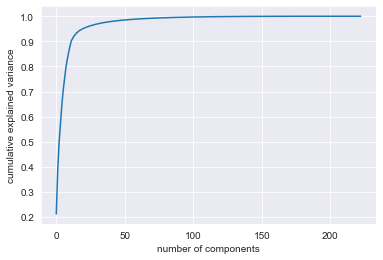

In [70]:
# to choose number of components, look at this chart. Reference: https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

pca = PCA().fit(all_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

 We choose number of eigenvalues to calculate based on previous chart, 20 looks like a good number, the chart starts to roll off around 15 and almost hits max a 20. We can also try 30,40 and 50 to squeeze a little more variance out...

In [71]:
#do PCA/StandardScaler+clip here or before the skew boxcox1p transform

n_components = 50
pca = PCA(n_components=n_components)
all_data_pca = pca.fit_transform(all_data)

our column count went from 216 to n_component value

In [72]:
print(all_data.shape)
print(all_data_pca.shape)

(2917, 223)
(2917, 50)


Edit: pca.components_ is the matrix you can use to calculate the inverse of the PCA analysis, i.e. go back to the original dataset
reference: https://stats.stackexchange.com/a/143949

In [73]:
weights = np.round(pca.components_, 3) 
ev = np.round(pca.explained_variance_ratio_, 3)
print('explained variance ratio',ev)
pca_wt = pd.DataFrame(weights)#, columns=all_data.columns)
pca_wt.head()

explained variance ratio [0.213 0.167 0.114 0.076 0.073 0.061 0.048 0.044 0.033 0.028 0.025 0.022
 0.01  0.009 0.007 0.006 0.005 0.004 0.003 0.003 0.003 0.002 0.002 0.002
 0.002 0.002 0.002 0.002 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001]


0      1      2      3      4      5      6      7      8      9    ...  \
0  0.046 -0.015 -0.047 -0.000 -0.004  0.016 -0.003 -0.004  0.000 -0.002  ...   
1 -0.026 -0.017 -0.062 -0.000 -0.002  0.028 -0.001 -0.028  0.001 -0.003  ...   
2 -0.035  0.024  0.058  0.000  0.002 -0.016 -0.003  0.021 -0.008  0.003  ...   
3  0.008  0.004  0.044 -0.000 -0.001 -0.013  0.003 -0.003  0.006  0.000  ...   
4 -0.004 -0.011 -0.038 -0.000 -0.001 -0.004 -0.000  0.000 -0.007  0.001  ...   

     213    214    215    216    217    218    219    220    221    222  
0  0.000  0.000 -0.000 -0.000  0.001  0.001 -0.000  0.000 -0.001  0.000  
1  0.000 -0.005  0.001  0.001  0.004  0.001  0.001  0.000 -0.001 -0.005  
2 -0.001  0.017 -0.000 -0.016 -0.003 -0.001 -0.001  0.000 -0.012  0.017  
3  0.000 -0.002 -0.000  0.004 -0.003 -0.001  0.000  0.001  0.006 -0.003  
4 -0.000  0.002  0.001  0.001  0.003  0.001  0.000 -0.001 -0.005  0.001  

[5 rows x 223 columns]

The shape values are the number of columns in the PCA x the number of original columns

In [74]:
pca_wt.shape 

(50, 223)

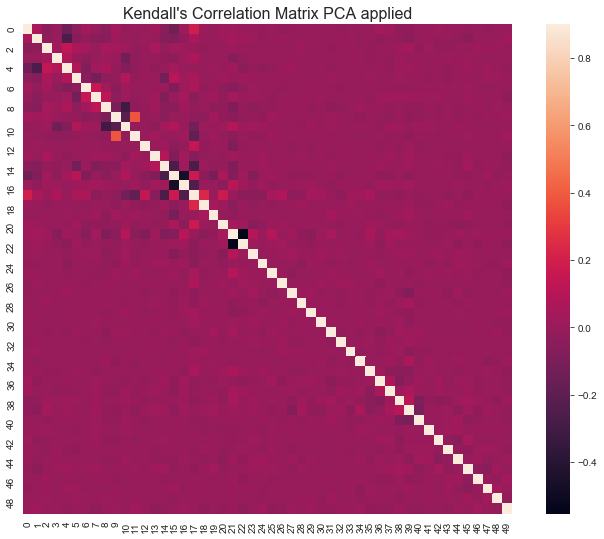

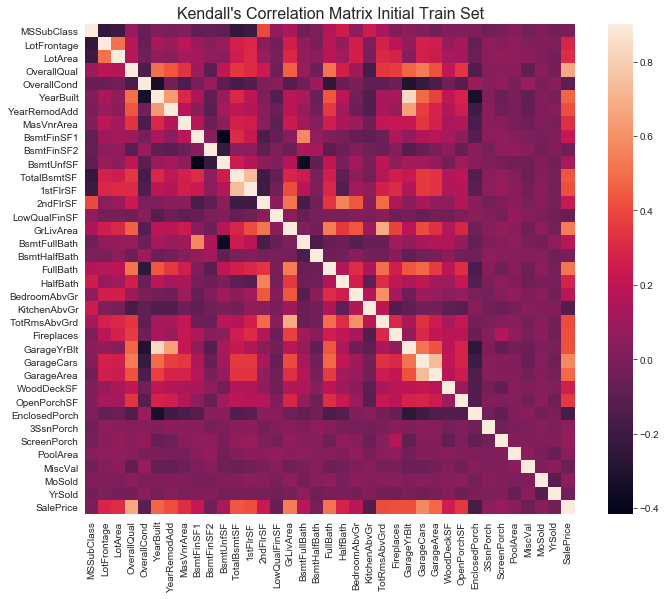

In [75]:
#Correlation map to see how features are correlated with each other and with SalePrice
corrmat = pd.DataFrame(all_data_pca).corr(method='kendall')
plt.subplots(figsize=(12,9))
plt.title("Kendall's Correlation Matrix PCA applied", fontsize=16)
sns.heatmap(corrmat, vmax=0.9, square=True)


#Correlation map to see how features are correlated with each other and with SalePrice
corrmat = train.corr(method='kendall')
plt.subplots(figsize=(12,9))
plt.title("Kendall's Correlation Matrix Initial Train Set", fontsize=16)
sns.heatmap(corrmat, vmax=0.9, square=True);


As you can see, the PCA analysis did its job, the features show little correlation now

Another look at the feature to output correlations

In [76]:
train_orig = train.copy()
train_orig['SalePrice'] = y_train
corrmat = train_orig.corr(method='kendall')
print (corrmat['SalePrice'].sort_values(ascending=False)[:5], '\n')
print (corrmat['SalePrice'].sort_values(ascending=False)[-5:])

SalePrice     1.000
OverallQual   0.671
GarageCars    0.573
GrLivArea     0.545
FullBath      0.519
Name: SalePrice, dtype: float64 

MiscVal         -0.051
LowQualFinSF    -0.055
OverallCond     -0.103
KitchenAbvGr    -0.135
EnclosedPorch   -0.172
Name: SalePrice, dtype: float64


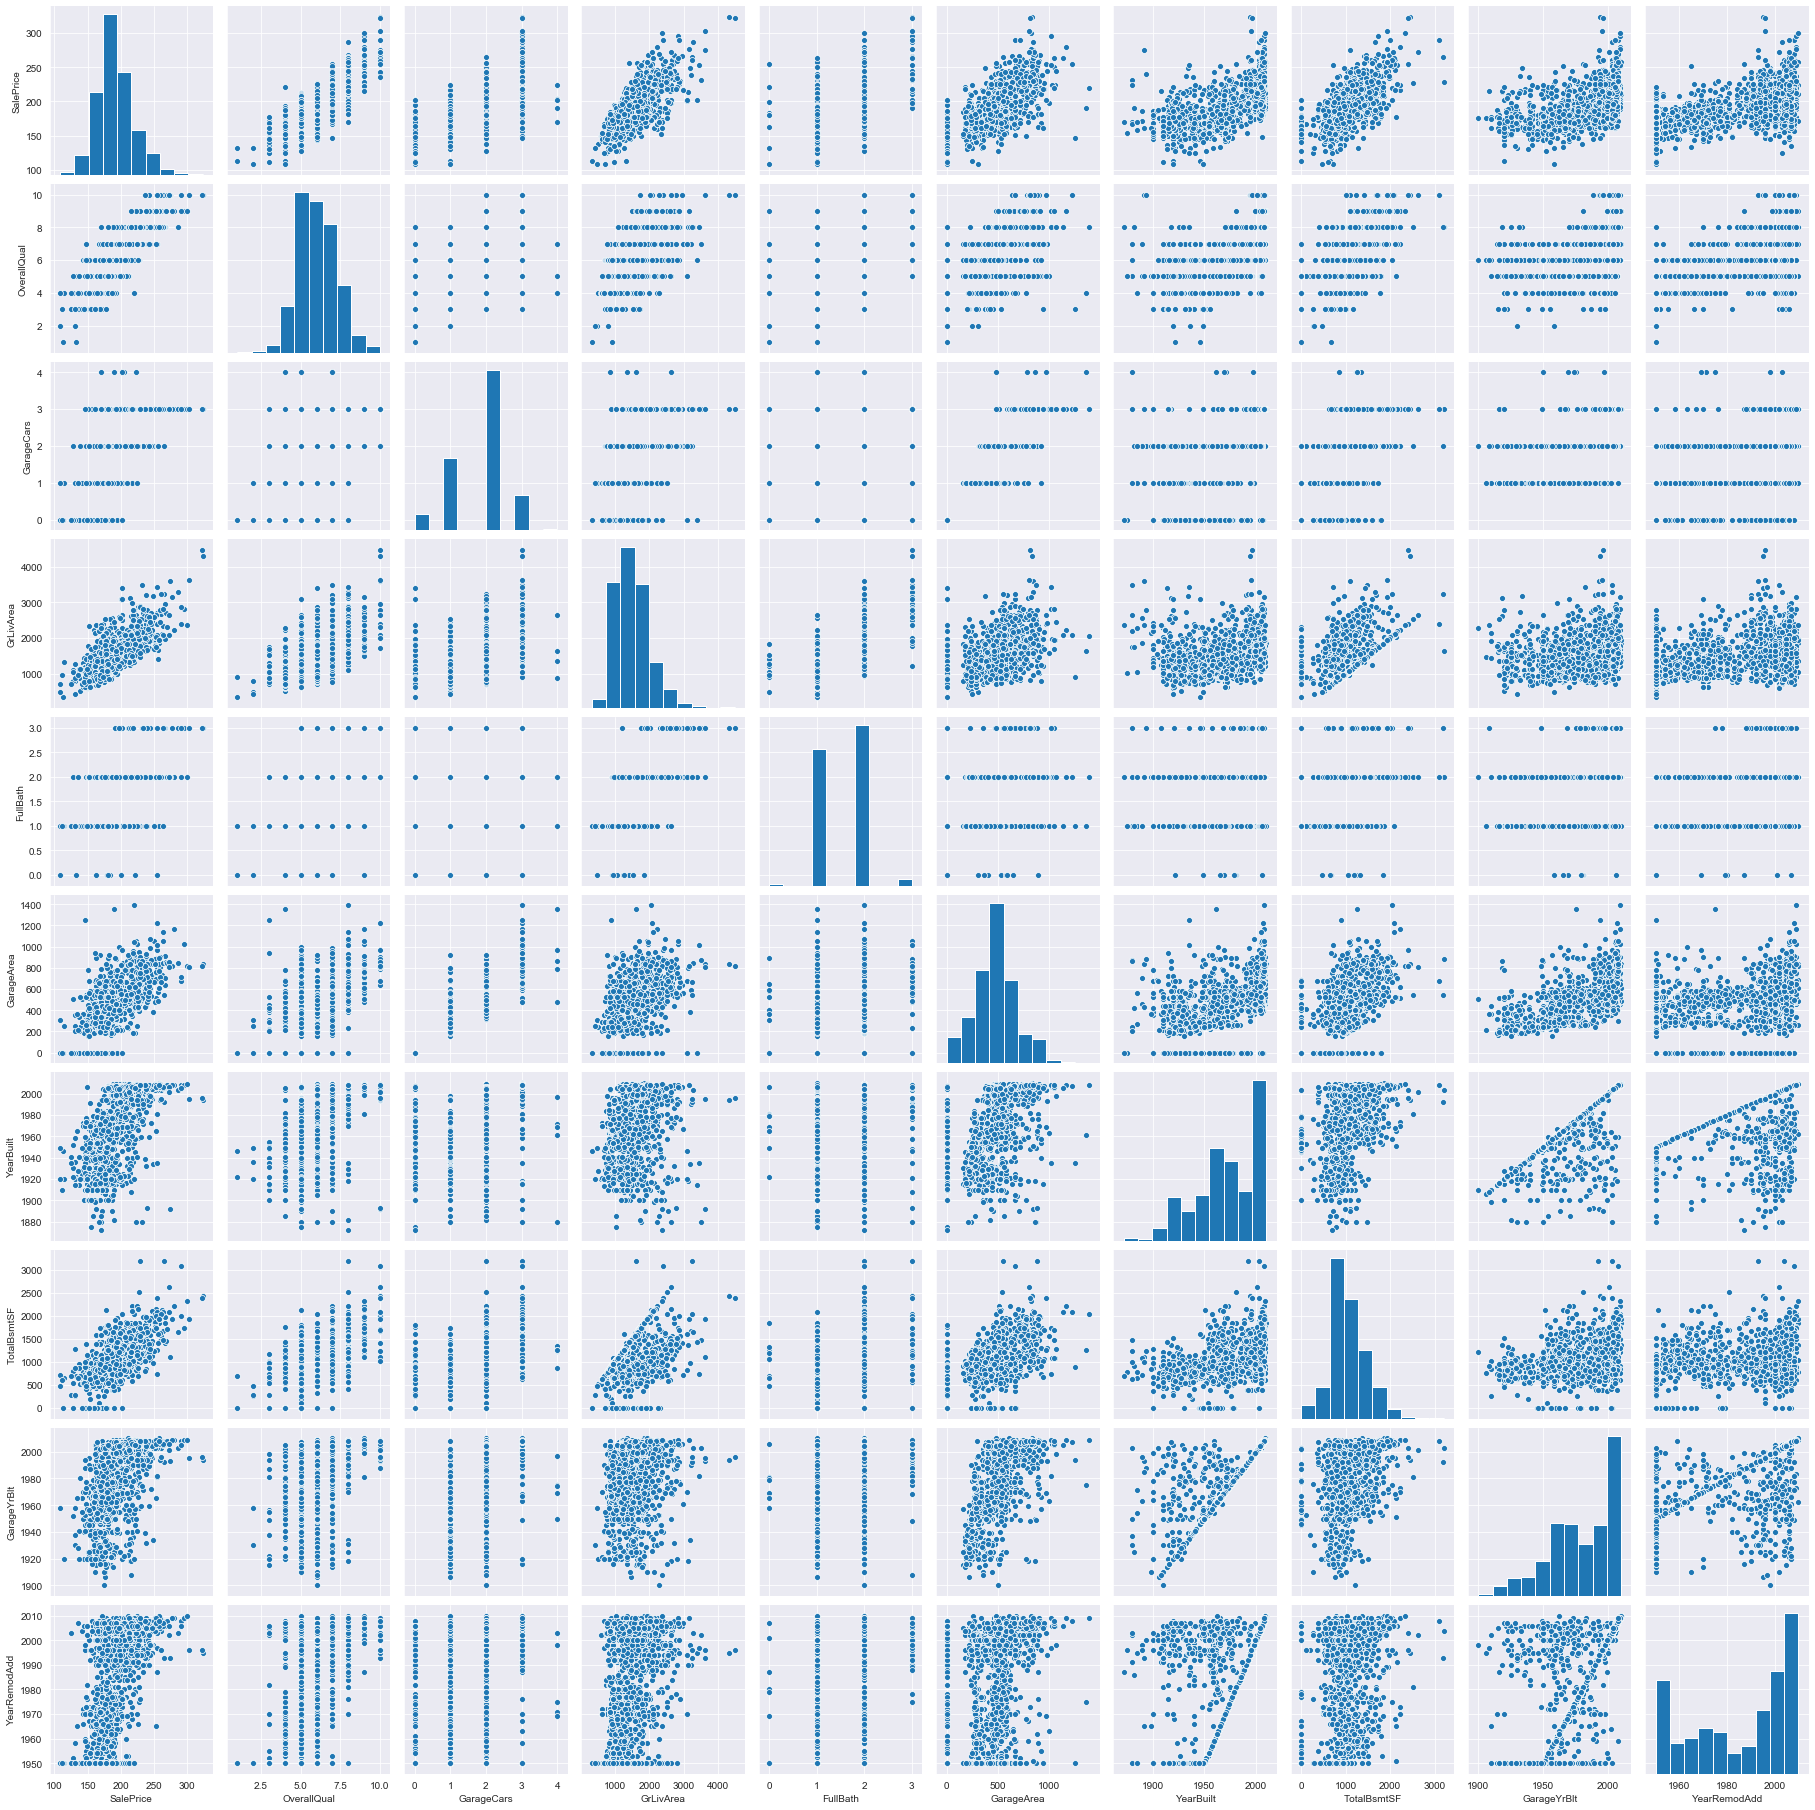

In [77]:
correlations = corrmat["SalePrice"].sort_values(ascending=False)
features = correlations.index[0:10]
sns.pairplot(train[features], height = 2.5)
plt.show();

Getting the new train and test sets. 

In [78]:
print(type(all_data))
print(type(pd.DataFrame(all_data_pca)))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


Testing the new PCA dataset for analysis - RMSE looks works after PCA is applied, need to look at the Kaggle score later and see if it correlates, could be a mistake to use PCA on categorical dummy data. However, XGB is better with PCA n=50 option. Maybe use a heavier weight for that portion, or use all_data_pca only on that model...

In [79]:
sc = StandardScaler()
rc = RobustScaler()

use_pca = 0 # using PCA currently hurts the score
use_normalization = 0 # using StandardScaler doesn't work, try RobustScaler now

if (use_pca == 1):
    all_data_pca = pd.DataFrame(all_data_pca)
    train = all_data_pca[:ntrain]
    test = all_data_pca[ntrain:]
    all_data_pca.head()
elif (use_normalization == 1):
    train = all_data[:ntrain]
    test = all_data[ntrain:]
    scaled_features = sc.fit_transform(train)
    train = pd.DataFrame(scaled_features, index=train.index, columns=train.columns)
    scaled_features = sc.transform(test)
    test = pd.DataFrame(scaled_features, index=test.index, columns=test.columns)   
elif (use_normalization == 2):
    train = all_data[:ntrain]
    test = all_data[ntrain:]
    scaled_features = rc.fit_transform(train)
    train = pd.DataFrame(scaled_features, index=train.index, columns=train.columns)
    scaled_features = rc.transform(test)
    test = pd.DataFrame(scaled_features, index=test.index, columns=test.columns)  
else:
    # back to original splits (from train.csv and test.csv)
    train = all_data[:ntrain]
    test = all_data[ntrain:]


Save Cleansed Data to disk

In [80]:
save_data = 0
if (save_data == 1):
    df1 = train.copy()
    df1['SalePrice'] = inv_boxcox1p(y_train, lam_l)
    df1.insert(0, 'Id', list(train_ID), allow_duplicates=False)
    df1.to_csv('HousePricesTrain.csv', index=False)  
    df2 = test.copy()
    df2.insert(0, 'Id', list(test_ID), allow_duplicates=False)
    df2.to_csv('HousePricesTest.csv', index=False) 

Compare Train to Test data, verify the distributions look similar, maybe add probablity plots per feature with train and test on same chart

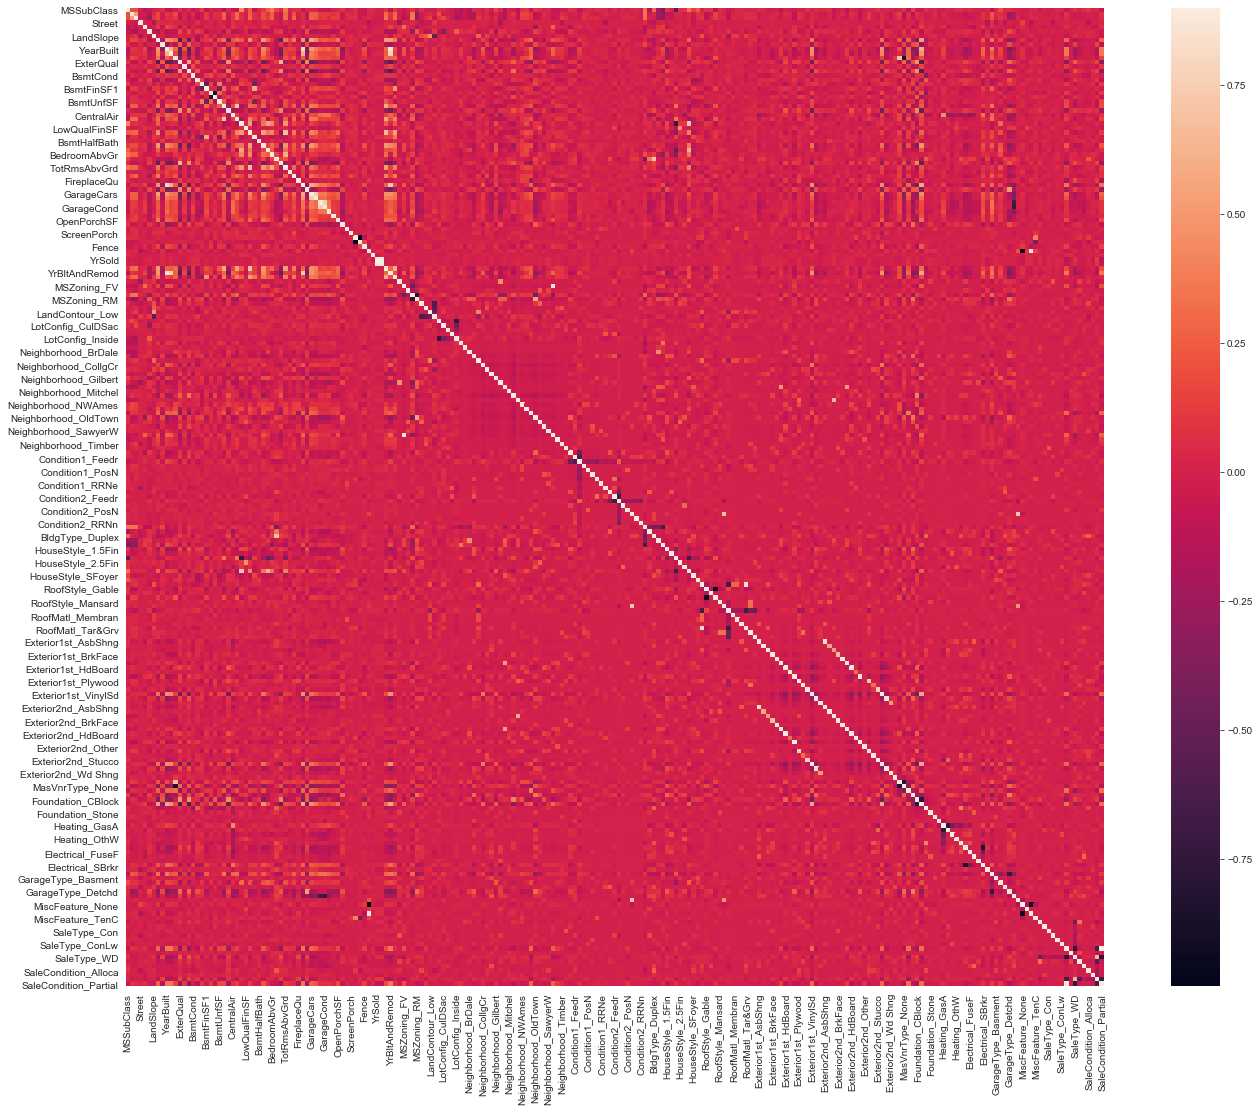

In [81]:
#Correlation map to see how features are correlated with each other and with SalePrice
corrmat = train.corr(method='kendall')
plt.subplots(figsize=(24,18))
sns.heatmap(corrmat, vmax=0.9, square=True)

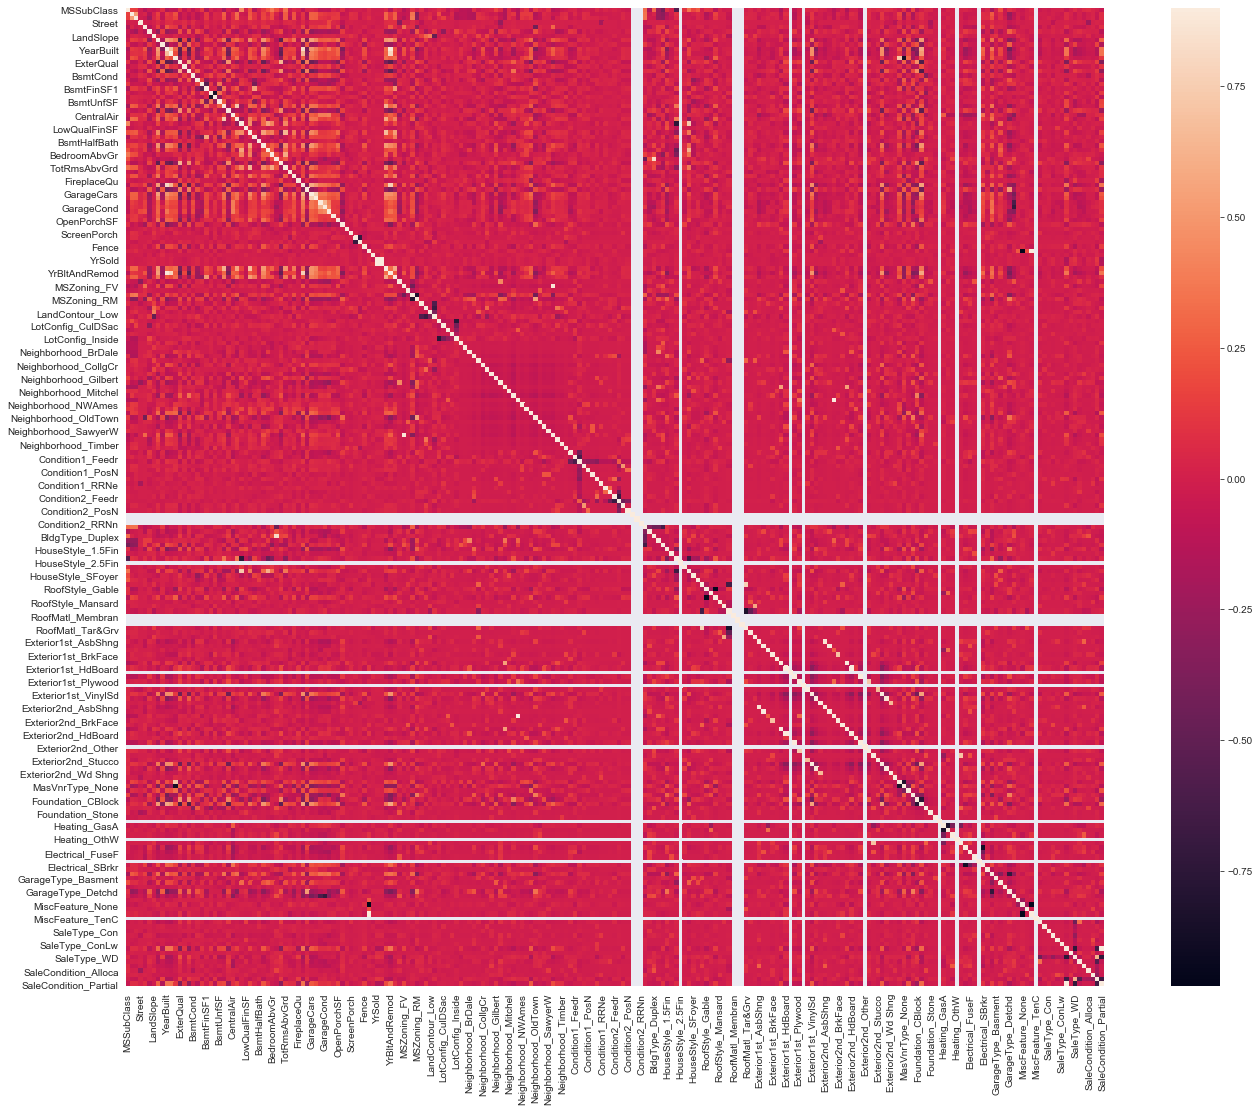

In [82]:
#Correlation map to see how features are correlated with each other and with SalePrice
corrmat = test.corr(method='kendall')
plt.subplots(figsize=(24,18))
sns.heatmap(corrmat, vmax=0.9, square=True)

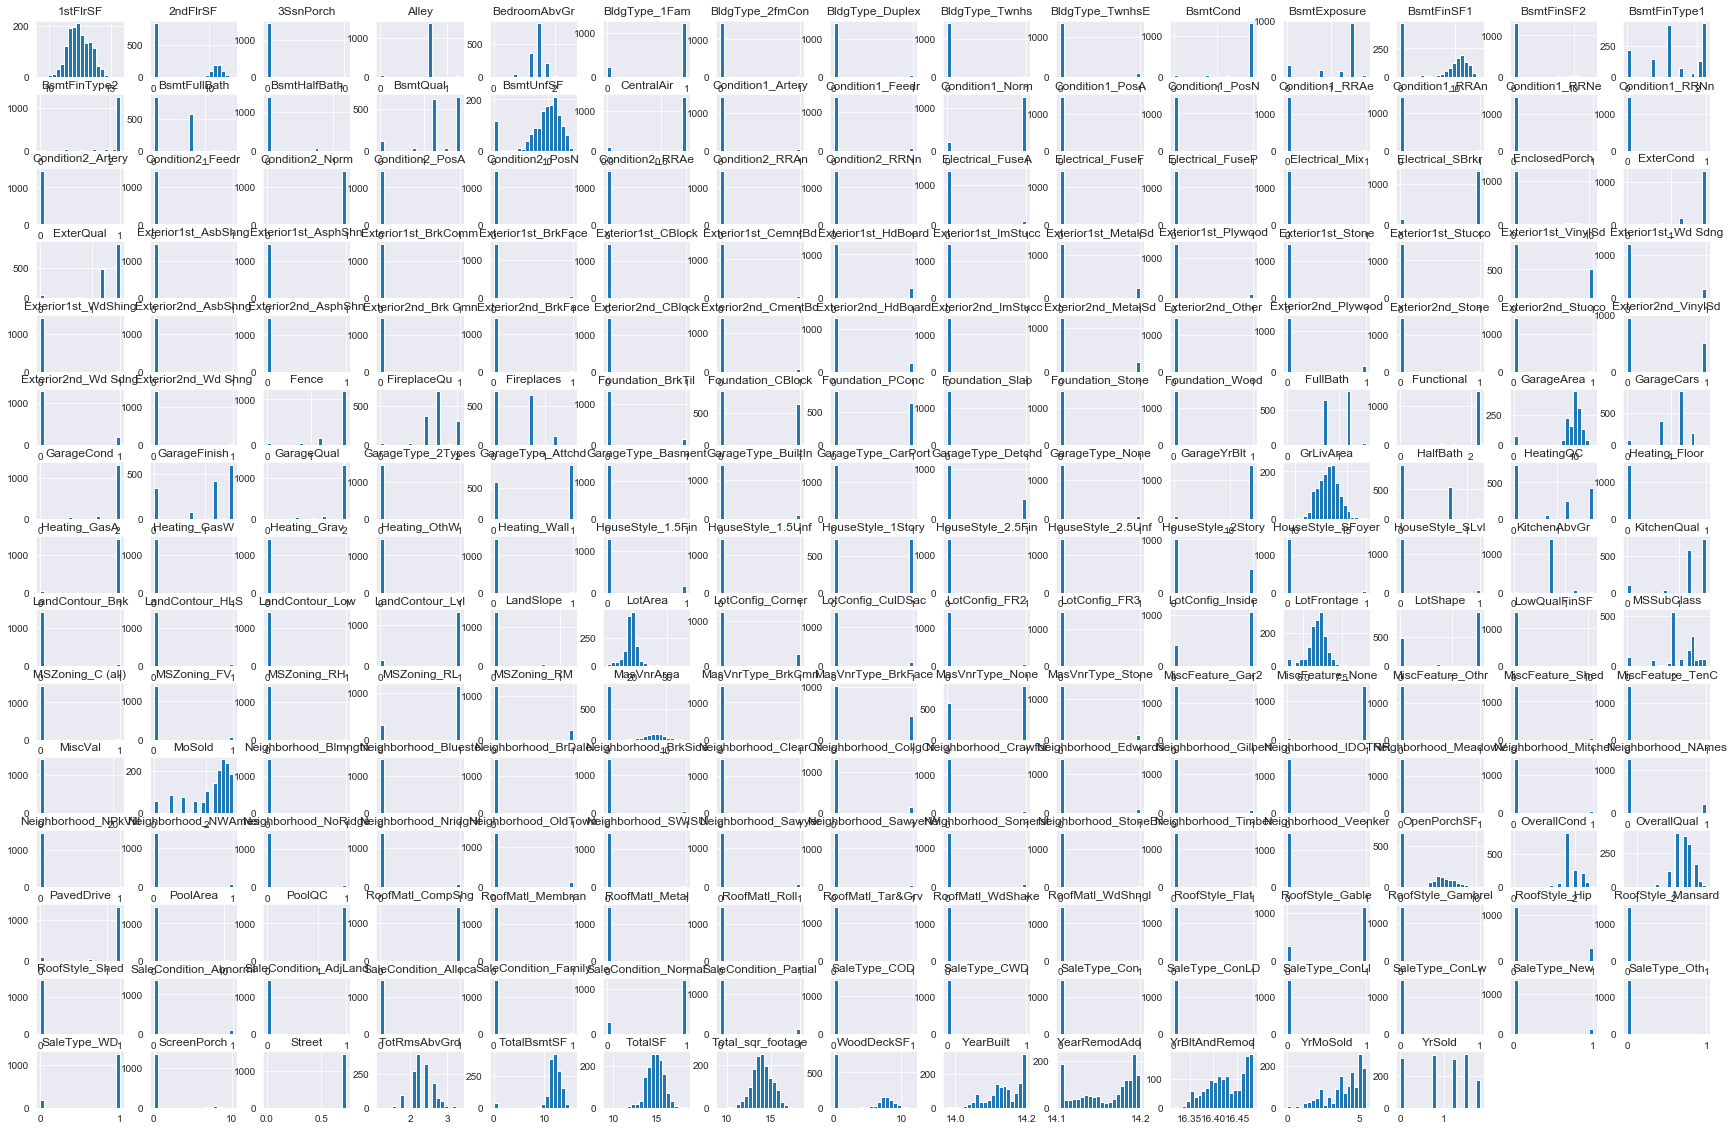

In [83]:
train.hist(bins=20, figsize=(30,20))
plt.show()

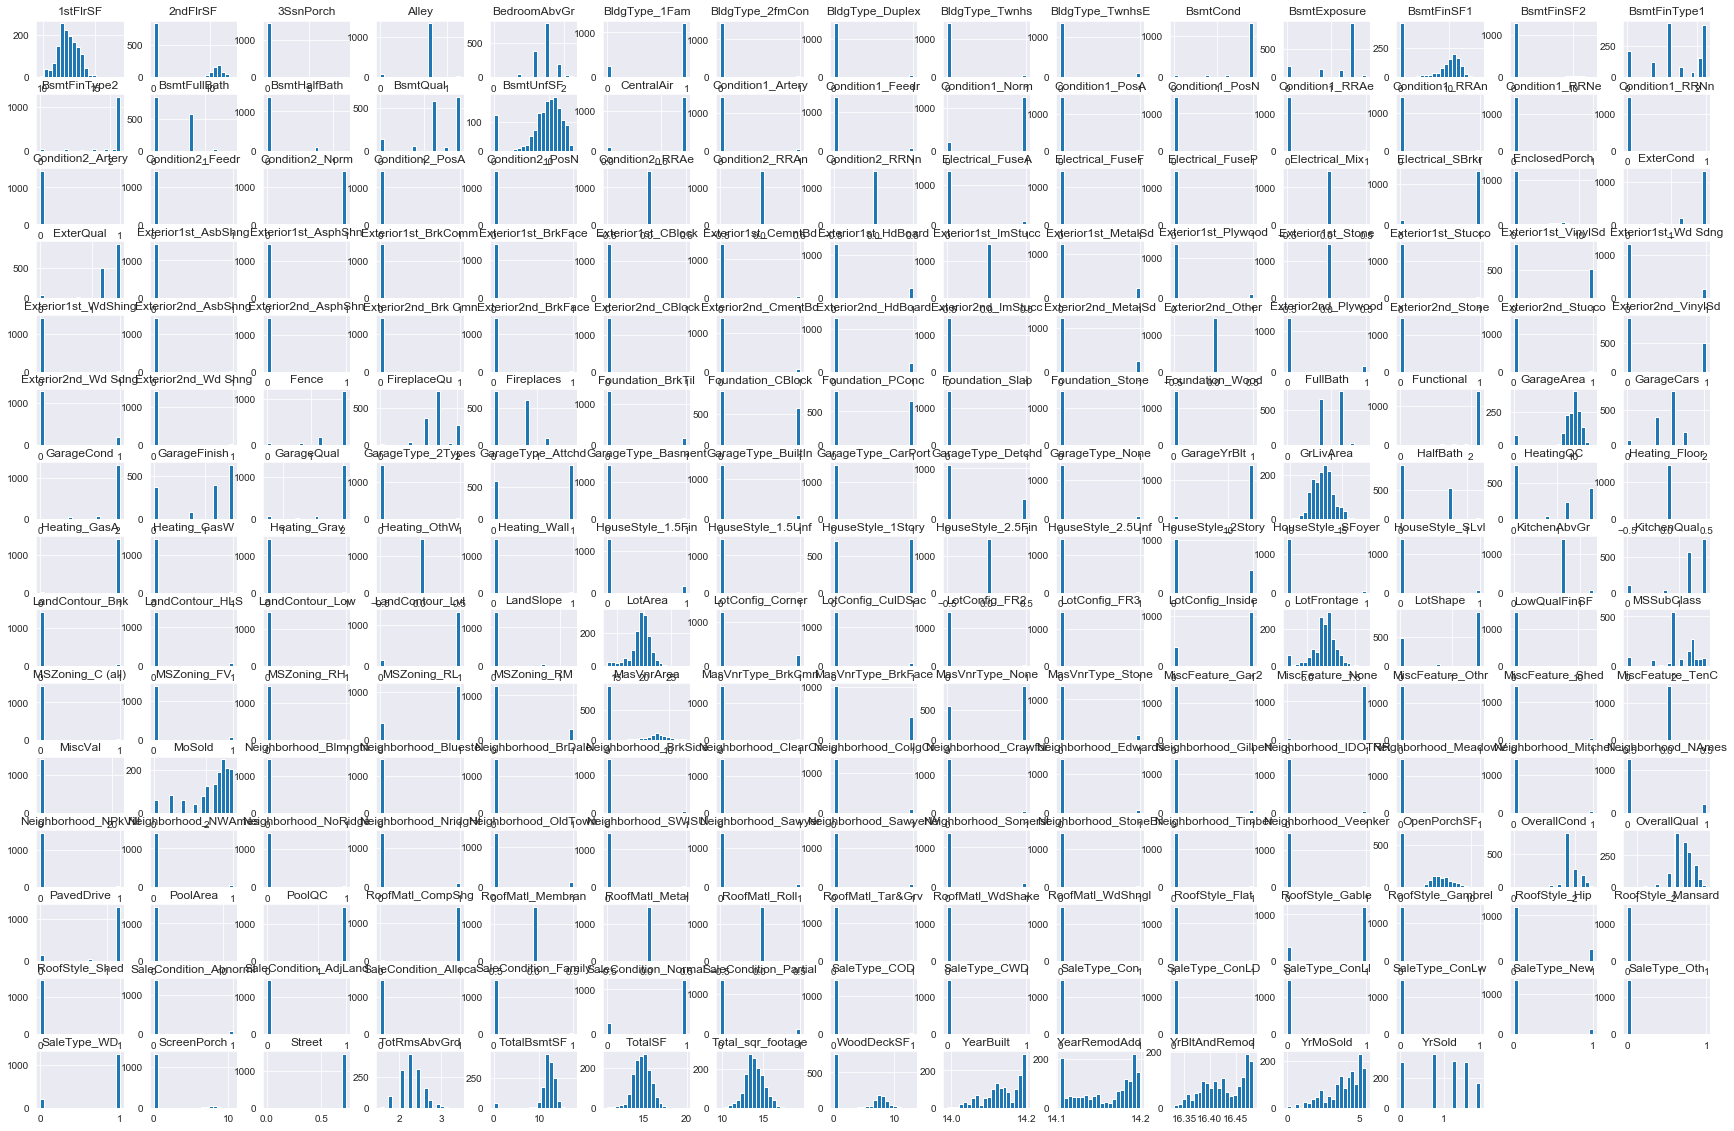

In [84]:
test.hist(bins=20, figsize=(30,20))
plt.show()

In [85]:
train.describe()

MSSubClass  LotFrontage  LotArea   Street    Alley  LotShape  \
count    1458.000     1458.000 1458.000 1458.000 1458.000  1458.000   
mean        2.305        5.898   19.549    0.727    0.718     1.006   
std         0.784        0.617    2.027    0.047    0.156     0.721   
min         0.000        3.933   12.879    0.000    0.000     0.000   
25%         2.056        5.685   18.776    0.730    0.730     0.000   
50%         2.260        5.969   19.660    0.730    0.730     1.541   
75%         2.886        6.225   20.472    0.730    0.730     1.541   
max         3.438        9.126   35.391    0.730    1.194     1.541   

       LandSlope  OverallQual  OverallCond  YearBuilt  ...  SaleType_ConLw  \
count   1458.000     1458.000     1458.000   1458.000  ...        1458.000   
mean       0.043        2.255        1.939     14.137  ...           0.003   
std        0.186        0.267        0.259      0.048  ...           0.058   
min        0.000        0.730        0.000     13.977  ...           0.000   
25%        0.000        2.056        1.820     14.110  ...           0.000   
50%        0.000        2.260        1.820     14.140  ...           0.000   
75%        0.000        2.440        2.056     14.183  ...           0.000   
max        1.194        2.886        2.603     14.198  ...           1.000   

       SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
count      1458.000      1458.000     1458.000               1458.000   
mean          0.082         0.002        0.869                  0.069   
std           0.275         0.045        0.338                  0.254   
min           0.000         0.000        0.000                  0.000   
25%           0.000         0.000        1.000                  0.000   
50%           0.000         0.000        1.000                  0.000   
75%           0.000         0.000        1.000                  0.000   
max           1.000         1.000        1.000                  1.000   

       SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
count               1458.000              1458.000              1458.000   
mean                   0.003                 0.008                 0.014   
std                    0.052                 0.090                 0.116   
min                    0.000                 0.000                 0.000   
25%                    0.000                 0.000                 0.000   
50%                    0.000                 0.000                 0.000   
75%                    0.000                 0.000                 0.000   
max                    1.000                 1.000                 1.000   

       SaleCondition_Normal  SaleCondition_Partial  
count              1458.000               1458.000  
mean                  0.822                  0.084  
std                   0.383                  0.278  
min                   0.000                  0.000  
25%                   1.000                  0.000  
50%                   1.000                  0.000  
75%                   1.000                  0.000  
max                   1.000                  1.000  

[8 rows x 223 columns]

In [86]:
test.describe()

MSSubClass  LotFrontage  LotArea   Street    Alley  LotShape  \
count    1459.000     1459.000 1459.000 1459.000 1459.000  1459.000   
mean        2.290        5.867   19.428    0.727    0.707     1.009   
std         0.807        0.629    1.907    0.047    0.175     0.722   
min         0.000        3.933   13.242    0.000    0.000     0.000   
25%         2.056        5.685   18.698    0.730    0.730     0.000   
50%         2.056        5.942   19.629    0.730    0.730     1.541   
75%         2.886        6.221   20.443    0.730    0.730     1.541   
max         3.438        8.104   27.755    0.730    1.194     1.541   

       LandSlope  OverallQual  OverallCond  YearBuilt  ...  SaleType_ConLw  \
count   1459.000     1459.000     1459.000   1459.000  ...        1459.000   
mean       0.032        2.250        1.931     14.137  ...           0.002   
std        0.154        0.281        0.277      0.048  ...           0.045   
min        0.000        0.730        0.000     13.989  ...           0.000   
25%        0.000        2.056        1.820     14.109  ...           0.000   
50%        0.000        2.260        1.820     14.140  ...           0.000   
75%        0.000        2.440        2.056     14.184  ...           0.000   
max        1.194        2.886        2.603     14.198  ...           1.000   

       SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
count      1459.000      1459.000     1459.000               1459.000   
mean          0.080         0.003        0.863                  0.061   
std           0.272         0.052        0.344                  0.239   
min           0.000         0.000        0.000                  0.000   
25%           0.000         0.000        1.000                  0.000   
50%           0.000         0.000        1.000                  0.000   
75%           0.000         0.000        1.000                  0.000   
max           1.000         1.000        1.000                  1.000   

       SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
count               1459.000              1459.000              1459.000   
mean                   0.005                 0.008                 0.018   
std                    0.074                 0.090                 0.132   
min                    0.000                 0.000                 0.000   
25%                    0.000                 0.000                 0.000   
50%                    0.000                 0.000                 0.000   
75%                    0.000                 0.000                 0.000   
max                    1.000                 1.000                 1.000   

       SaleCondition_Normal  SaleCondition_Partial  
count              1459.000               1459.000  
mean                  0.825                  0.082  
std                   0.380                  0.275  
min                   0.000                  0.000  
25%                   1.000                  0.000  
50%                   1.000                  0.000  
75%                   1.000                  0.000  
max                   1.000                  1.000  

[8 rows x 223 columns]

split train into train and validate 1458 records -> 70/30 => 1000 Train/400 Val

In [87]:
a='''
from sklearn.model_selection import KFold, cross_val_score, train_test_split
X = train
y = y_train
train, val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=201)#, stratify=y)'''

In [88]:
print("Modelling: ", datetime.datetime.now())

Modelling:  2020-09-03 22:47:25.846557


In [89]:
train

MSSubClass  LotFrontage  LotArea  Street  Alley  LotShape  LandSlope  \
0          2.886        5.831   19.212   0.730  0.730     1.541      0.000   
1          2.056        6.221   19.712   0.730  0.730     1.541      0.000   
2          2.886        5.915   20.347   0.730  0.730     0.000      0.000   
3          3.011        5.685   19.692   0.730  0.730     0.000      0.000   
4          2.886        6.315   21.325   0.730  0.730     0.000      0.000   
...          ...          ...      ...     ...    ...       ...        ...   
1453       2.886        5.744   18.961   0.730  0.730     1.541      0.000   
1454       2.056        6.338   20.995   0.730  0.730     1.541      0.000   
1455       3.011        5.860   19.476   0.730  0.730     1.541      0.000   
1456       2.056        5.915   19.760   0.730  0.730     1.541      0.000   
1457       2.056        6.099   19.849   0.730  0.730     1.541      0.000   

      OverallQual  OverallCond  YearBuilt  ...  SaleType_ConLw  SaleType_New  \
0           2.440        1.820     14.188  ...               0             0   
1           2.260        2.440     14.145  ...               0             0   
2           2.440        1.820     14.184  ...               0             0   
3           2.440        1.820     14.048  ...               0             0   
4           2.603        1.820     14.183  ...               0             0   
...           ...          ...        ...  ...             ...           ...   
1453        2.260        1.820     14.181  ...               0             0   
1454        2.260        2.056     14.148  ...               0             0   
1455        2.440        2.603     14.089  ...               0             0   
1456        2.056        2.056     14.104  ...               0             0   
1457        2.056        2.056     14.128  ...               0             0   

      SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  SaleCondition_AdjLand  \
0                0            1                      0                      0   
1                0            1                      0                      0   
2                0            1                      0                      0   
3                0            1                      1                      0   
4                0            1                      0                      0   
...            ...          ...                    ...                    ...   
1453             0            1                      0                      0   
1454             0            1                      0                      0   
1455             0            1                      0                      0   
1456             0            1                      0                      0   
1457             0            1                      0                      0   

      SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
0                        0                     0                     1   
1                        0                     0                     1   
2                        0                     0                     1   
3                        0                     0                     0   
4                        0                     0                     1   
...                    ...                   ...                   ...   
1453                     0                     0                     1   
1454                     0                     0                     1   
1455                     0                     0                     1   
1456                     0                     0                     1   
1457                     0                     0                     1   

      SaleCondition_Partial  
0                         0  
1                         0  
2                         0  
3                         0  
4                         0  
...                     ...  
1453                      0  
1454  

In [90]:
test

MSSubClass  LotFrontage  LotArea  Street  Alley  LotShape  LandSlope  \
1458       2.056        6.221   20.479   0.730  0.730     1.541      0.000   
1459       2.056        6.245   21.327   0.730  0.730     0.000      0.000   
1460       2.886        6.073   21.197   0.730  0.730     0.000      0.000   
1461       2.886        6.173   19.865   0.730  0.730     0.000      0.000   
1462       0.000        5.094   17.257   0.730  0.730     0.000      0.000   
...          ...          ...      ...     ...    ...       ...        ...   
2912       1.194        3.933   14.081   0.730  0.730     1.541      0.000   
2913       1.194        3.933   14.013   0.730  0.730     1.541      0.000   
2914       2.056        7.620   22.782   0.730  0.730     1.541      0.000   
2915       3.341        5.744   20.047   0.730  0.730     1.541      0.000   
2916       2.886        6.073   19.723   0.730  0.730     1.541      0.730   

      OverallQual  OverallCond  YearBuilt  ...  SaleType_ConLw  SaleType_New  \
1458        2.056        2.056     14.121  ...               0             0   
1459        2.260        2.056     14.117  ...               0             0   
1460        2.056        1.820     14.178  ...               0             0   
1461        2.260        2.056     14.180  ...               0             0   
1462        2.603        1.820     14.170  ...               0             0   
...           ...          ...        ...  ...             ...           ...   
2912        1.820        2.260     14.136  ...               0             0   
2913        1.820        1.820     14.136  ...               0             0   
2914        2.056        2.260     14.120  ...               0             0   
2915        2.056        1.820     14.170  ...               0             0   
2916        2.440        1.820     14.172  ...               0             0   

      SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  SaleCondition_AdjLand  \
1458             0            1                      0                      0   
1459             0            1                      0                      0   
1460             0            1                      0                      0   
1461             0            1                      0                      0   
1462             0            1                      0                      0   
...            ...          ...                    ...                    ...   
2912             0            1                      0                      0   
2913             0            1                      1                      0   
2914             0            1                      1                      0   
2915             0            1                      0                      0   
2916             0            1                      0                      0   

      SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
1458                     0                     0                     1   
1459                     0                     0                     1   
1460                     0                     0                     1   
1461                     0                     0                     1   
1462                     0                     0                     1   
...                    ...                   ...                   ...   
2912                     0                     0                     1   
2913                     0                     0                     0   
2914                     0                     0                     0   
2915                     0                     0                     1   
2916                     0                     0                     1   

      SaleCondition_Partial  
1458                      0  
1459                      0  
1460                      0  
1461                      0  
1462                      0  
...                     ...  
2912                      0  
2913  

In [91]:
y_train

array([204.93054257, 195.08561344, 210.04487143, ..., 223.56899073,
       178.84819785, 181.2243778 ])

alternate data source using top n features from Sequential Feature Selector (FeatureSelection.ipynb)

Reference: http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/

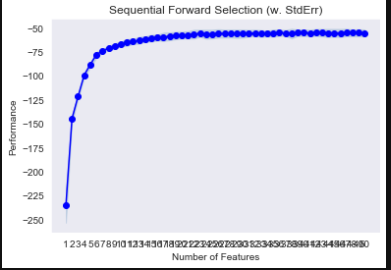

In [92]:
# need train index and test index
use_feature_selection = 0
if (use_feature_selection == 1):
    import pickle

    with open('X_train_sfs_50.pkl', 'rb') as fid:
        train = pickle.load(fid)
    with open('X_test_sfs_50.pkl', 'rb') as fid:
        test = pickle.load(fid)
    train = pd.DataFrame(train, index=train_ID)
    test = pd.DataFrame(test, index=test_ID)

In [93]:
train

MSSubClass  LotFrontage  LotArea  Street  Alley  LotShape  LandSlope  \
0          2.886        5.831   19.212   0.730  0.730     1.541      0.000   
1          2.056        6.221   19.712   0.730  0.730     1.541      0.000   
2          2.886        5.915   20.347   0.730  0.730     0.000      0.000   
3          3.011        5.685   19.692   0.730  0.730     0.000      0.000   
4          2.886        6.315   21.325   0.730  0.730     0.000      0.000   
...          ...          ...      ...     ...    ...       ...        ...   
1453       2.886        5.744   18.961   0.730  0.730     1.541      0.000   
1454       2.056        6.338   20.995   0.730  0.730     1.541      0.000   
1455       3.011        5.860   19.476   0.730  0.730     1.541      0.000   
1456       2.056        5.915   19.760   0.730  0.730     1.541      0.000   
1457       2.056        6.099   19.849   0.730  0.730     1.541      0.000   

      OverallQual  OverallCond  YearBuilt  ...  SaleType_ConLw  SaleType_New  \
0           2.440        1.820     14.188  ...               0             0   
1           2.260        2.440     14.145  ...               0             0   
2           2.440        1.820     14.184  ...               0             0   
3           2.440        1.820     14.048  ...               0             0   
4           2.603        1.820     14.183  ...               0             0   
...           ...          ...        ...  ...             ...           ...   
1453        2.260        1.820     14.181  ...               0             0   
1454        2.260        2.056     14.148  ...               0             0   
1455        2.440        2.603     14.089  ...               0             0   
1456        2.056        2.056     14.104  ...               0             0   
1457        2.056        2.056     14.128  ...               0             0   

      SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  SaleCondition_AdjLand  \
0                0            1                      0                      0   
1                0            1                      0                      0   
2                0            1                      0                      0   
3                0            1                      1                      0   
4                0            1                      0                      0   
...            ...          ...                    ...                    ...   
1453             0            1                      0                      0   
1454             0            1                      0                      0   
1455             0            1                      0                      0   
1456             0            1                      0                      0   
1457             0            1                      0                      0   

      SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
0                        0                     0                     1   
1                        0                     0                     1   
2                        0                     0                     1   
3                        0                     0                     0   
4                        0                     0                     1   
...                    ...                   ...                   ...   
1453                     0                     0                     1   
1454                     0                     0                     1   
1455                     0                     0                     1   
1456                     0                     0                     1   
1457                     0                     0                     1   

      SaleCondition_Partial  
0                         0  
1                         0  
2                         0  
3                         0  
4                         0  
...                     ...  
1453                      0  
1454  

Some ML algorithms need scaled data, such as those based on gradient boosting (linear regression, neural network) 

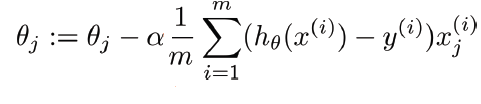

and distance (KNN, SVM). Scaling the data in these cases will give each feature an equal chance to contribute to the result.
MinMaxScaler equation:

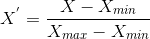

Also some datasets need this normalization when the distributions are non-gaussian

In [94]:
norm = MinMaxScaler().fit(train)
train_norm_arr = norm.transform(train)
test_norm_arr = norm.transform(test)
train_norm = pd.DataFrame(norm.transform(train), index=train.index, columns=train.columns)
test_norm = pd.DataFrame(norm.transform(test), index=test.index, columns=test.columns)

In [95]:
train_norm

MSSubClass  LotFrontage  LotArea  Street  Alley  LotShape  LandSlope  \
0          0.839        0.366    0.281   1.000  0.612     1.000      0.000   
1          0.598        0.441    0.304   1.000  0.612     1.000      0.000   
2          0.839        0.382    0.332   1.000  0.612     0.000      0.000   
3          0.876        0.337    0.303   1.000  0.612     0.000      0.000   
4          0.839        0.459    0.375   1.000  0.612     0.000      0.000   
...          ...          ...      ...     ...    ...       ...        ...   
1453       0.839        0.349    0.270   1.000  0.612     1.000      0.000   
1454       0.598        0.463    0.361   1.000  0.612     1.000      0.000   
1455       0.876        0.371    0.293   1.000  0.612     1.000      0.000   
1456       0.598        0.382    0.306   1.000  0.612     1.000      0.000   
1457       0.598        0.417    0.310   1.000  0.612     1.000      0.000   

      OverallQual  OverallCond  YearBuilt  ...  SaleType_ConLw  SaleType_New  \
0           0.793        0.699      0.951  ...           0.000         0.000   
1           0.709        0.938      0.759  ...           0.000         0.000   
2           0.793        0.699      0.937  ...           0.000         0.000   
3           0.793        0.699      0.318  ...           0.000         0.000   
4           0.869        0.699      0.930  ...           0.000         0.000   
...           ...          ...        ...  ...             ...           ...   
1453        0.709        0.699      0.922  ...           0.000         0.000   
1454        0.709        0.790      0.773  ...           0.000         0.000   
1455        0.793        1.000      0.508  ...           0.000         0.000   
1456        0.615        0.790      0.573  ...           0.000         0.000   
1457        0.615        0.790      0.681  ...           0.000         0.000   

      SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  SaleCondition_AdjLand  \
0            0.000        1.000                  0.000                  0.000   
1            0.000        1.000                  0.000                  0.000   
2            0.000        1.000                  0.000                  0.000   
3            0.000        1.000                  1.000                  0.000   
4            0.000        1.000                  0.000                  0.000   
...            ...          ...                    ...                    ...   
1453         0.000        1.000                  0.000                  0.000   
1454         0.000        1.000                  0.000                  0.000   
1455         0.000        1.000                  0.000                  0.000   
1456         0.000        1.000                  0.000                  0.000   
1457         0.000        1.000                  0.000                  0.000   

      SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
0                    0.000                 0.000                 1.000   
1                    0.000                 0.000                 1.000   
2                    0.000                 0.000                 1.000   
3                    0.000                 0.000                 0.000   
4                    0.000                 0.000                 1.000   
...                    ...                   ...                   ...   
1453                 0.000                 0.000                 1.000   
1454                 0.000                 0.000                 1.000   
1455                 0.000                 0.000                 1.000   
1456                 0.000                 0.000                 1.000   
1457                 0.000                 0.000                 1.000   

      SaleCondition_Partial  
0                     0.000  
1                     0.000  
2                     0.000  
3                     0.000  
4                     0.000  
...                     ...  
1453                  0.000  
1454  

Other ML Algorithms need StandardScaler, such as SVR


In [96]:
# make copy of datasets
train_stand = train.copy()
test_stand = test.copy()

# apply standardization on numerical features
for i in all_numerical:
    # fit on training data column
    scale = StandardScaler().fit(train_stand[[i]])
    # transform the training data column
    train_stand[i] = scale.transform(train_stand[[i]])
    # transform the testing data column
    test_stand[i] = scale.transform(test_stand[[i]])

In [97]:
train_stand

MSSubClass  LotFrontage  LotArea  Street  Alley  LotShape  LandSlope  \
0          0.741       -0.108   -0.166   0.730  0.730     1.541      0.000   
1         -0.319        0.524    0.080   0.730  0.730     1.541      0.000   
2          0.741        0.027    0.394   0.730  0.730     0.000      0.000   
3          0.901       -0.346    0.070   0.730  0.730     0.000      0.000   
4          0.741        0.675    0.876   0.730  0.730     0.000      0.000   
...          ...          ...      ...     ...    ...       ...        ...   
1453       0.741       -0.249   -0.291   0.730  0.730     1.541      0.000   
1454      -0.319        0.712    0.713   0.730  0.730     1.541      0.000   
1455       0.901       -0.063   -0.036   0.730  0.730     1.541      0.000   
1456      -0.319        0.027    0.104   0.730  0.730     1.541      0.000   
1457      -0.319        0.325    0.148   0.730  0.730     1.541      0.000   

      OverallQual  OverallCond  YearBuilt  ...  SaleType_ConLw  SaleType_New  \
0           0.692       -0.457      1.048  ...               0             0   
1           0.016        1.937      0.164  ...               0             0   
2           0.692       -0.457      0.983  ...               0             0   
3           0.692       -0.457     -1.871  ...               0             0   
4           1.300       -0.457      0.950  ...               0             0   
...           ...          ...        ...  ...             ...           ...   
1453        0.016       -0.457      0.918  ...               0             0   
1454        0.016        0.452      0.230  ...               0             0   
1455        0.692        2.564     -0.997  ...               0             0   
1456       -0.748        0.452     -0.697  ...               0             0   
1457       -0.748        0.452     -0.199  ...               0             0   

      SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  SaleCondition_AdjLand  \
0                0            1                      0                      0   
1                0            1                      0                      0   
2                0            1                      0                      0   
3                0            1                      1                      0   
4                0            1                      0                      0   
...            ...          ...                    ...                    ...   
1453             0            1                      0                      0   
1454             0            1                      0                      0   
1455             0            1                      0                      0   
1456             0            1                      0                      0   
1457             0            1                      0                      0   

      SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
0                        0                     0                     1   
1                        0                     0                     1   
2                        0                     0                     1   
3                        0                     0                     0   
4                        0                     0                     1   
...                    ...                   ...                   ...   
1453                     0                     0                     1   
1454                     0                     0                     1   
1455                     0                     0                     1   
1456                     0                     0                     1   
1457                     0                     0                     1   

      SaleCondition_Partial  
0                         0  
1                         0  
2                         0  
3                         0  
4                         0  
...                     ...  
1453                      0  
1454  

In [98]:
test

MSSubClass  LotFrontage  LotArea  Street  Alley  LotShape  LandSlope  \
1458       2.056        6.221   20.479   0.730  0.730     1.541      0.000   
1459       2.056        6.245   21.327   0.730  0.730     0.000      0.000   
1460       2.886        6.073   21.197   0.730  0.730     0.000      0.000   
1461       2.886        6.173   19.865   0.730  0.730     0.000      0.000   
1462       0.000        5.094   17.257   0.730  0.730     0.000      0.000   
...          ...          ...      ...     ...    ...       ...        ...   
2912       1.194        3.933   14.081   0.730  0.730     1.541      0.000   
2913       1.194        3.933   14.013   0.730  0.730     1.541      0.000   
2914       2.056        7.620   22.782   0.730  0.730     1.541      0.000   
2915       3.341        5.744   20.047   0.730  0.730     1.541      0.000   
2916       2.886        6.073   19.723   0.730  0.730     1.541      0.730   

      OverallQual  OverallCond  YearBuilt  ...  SaleType_ConLw  SaleType_New  \
1458        2.056        2.056     14.121  ...               0             0   
1459        2.260        2.056     14.117  ...               0             0   
1460        2.056        1.820     14.178  ...               0             0   
1461        2.260        2.056     14.180  ...               0             0   
1462        2.603        1.820     14.170  ...               0             0   
...           ...          ...        ...  ...             ...           ...   
2912        1.820        2.260     14.136  ...               0             0   
2913        1.820        1.820     14.136  ...               0             0   
2914        2.056        2.260     14.120  ...               0             0   
2915        2.056        1.820     14.170  ...               0             0   
2916        2.440        1.820     14.172  ...               0             0   

      SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  SaleCondition_AdjLand  \
1458             0            1                      0                      0   
1459             0            1                      0                      0   
1460             0            1                      0                      0   
1461             0            1                      0                      0   
1462             0            1                      0                      0   
...            ...          ...                    ...                    ...   
2912             0            1                      0                      0   
2913             0            1                      1                      0   
2914             0            1                      1                      0   
2915             0            1                      0                      0   
2916             0            1                      0                      0   

      SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
1458                     0                     0                     1   
1459                     0                     0                     1   
1460                     0                     0                     1   
1461                     0                     0                     1   
1462                     0                     0                     1   
...                    ...                   ...                   ...   
2912                     0                     0                     1   
2913                     0                     0                     0   
2914                     0                     0                     0   
2915                     0                     0                     1   
2916                     0                     0                     1   

      SaleCondition_Partial  
1458                      0  
1459                      0  
1460                      0  
1461                      0  
1462                      0  
...                     ...  
2912                      0  
2913  

- **Modelling**

**Import libraries**

In [99]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

#from sklearn.metrics import mean_squared_log_error
# to run locally: conda install -c anaconda py-xgboost
import xgboost as xgb
import lightgbm as lgb
from catboost import Pool, CatBoostRegressor

In [100]:
import keras
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Embedding
#from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.callbacks import LearningRateScheduler, EarlyStopping, History, LambdaCallback
from keras import regularizers
from keras import backend as K
from keras.layers import Conv1D
from keras.layers import BatchNormalization
from keras.layers import MaxPool1D
from keras.layers import Flatten
from keras.backend import sigmoid
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam   #for adam optimizer

Using TensorFlow backend.


choose method to use, ensemble(average) or stacked

In [101]:
method = 'ensemble'
#method = 'stacked'

Try Bayesian Optimization
reference: https://blog.floydhub.com/guide-to-hyperparameters-search-for-deep-learning-models/

Tune other parameters
reference: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [102]:
# v 75

import random as rn
rn.seed(1) # random
from numpy.random import seed
seed(7) # or 7
import tensorflow as tf
tf.random.set_seed(0) # tf

a='''
from numpy.random import seed
seed(1)
seed = 7 # optimized
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(0) # tf
'''

In [103]:
# define base model
from keras.optimizers import Adam, SGD, RMSprop   #for adam optimizer
def baseline_model(dim=223, opt_sel="adam", learning_rate = 0.001, neurons = 1, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, decay = 0.0002, momentum=0.9):
    def bm():
        # create model
        model = Sequential()
        #model.add(Dense(neurons, input_dim=223, kernel_initializer='normal', activation='relu'))
        model.add(Dense(neurons, input_dim=dim, kernel_initializer='normal', activation='relu'))
        model.add(Dense(1, kernel_initializer='normal'))
        #model.add(Dense(1, kernel_initializer='normal')) # added to v86
        # Compile model
        if (opt_sel == "adam"):
            #opt = Adam(lr=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon, amsgrad=amsgrad) # added to v86
            opt = Adam(lr=learning_rate)
        elif(opt_sel == "sgd"):
            opt = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay, nesterov=True)
        model.compile(loss='mean_squared_error', optimizer=opt)
        return model
    return bm

In [104]:
train_inputs =  preprocessing.scale(train)
n_cols = train_inputs.shape[1]
input_shape = (n_cols, )
# Creates a model given an activation and learning rate
# Create the model object with default arguments
def create_model(learning_rate = 0.001, activation='relu'):
  
    # Set Adam optimizer with the given learning rate
    opt = Adam(lr = learning_rate)
  
    # Create your binary classification model  
    model = Sequential()
    model.add(Dense(128,
                    activation = activation,
                    input_shape = input_shape,
                    activity_regularizer = regularizers.l2(1e-5)))
    model.add(Dropout(0.50))
    model.add(Dense(128,
                    activation = activation, 
                    activity_regularizer = regularizers.l2(1e-5)))
    model.add(Dropout(0.50))
    model.add(Dense(1, activation = activation))
    # Compile the model
    model.compile(optimizer = opt,
                  #loss = "mean_absolute_error",
                  loss = "mean_squared_error",
                  metrics = ['mse', "mape"])
    return model

In [105]:
from sklearn.model_selection import RandomizedSearchCV
from keras.optimizers import Adam   #for adam optimizer
optimize_nn = 0
if (optimize_nn == 1):
    # Create a KerasClassifier object
    model = KerasRegressor(build_fn = create_model,
                           verbose = 0)
    # Define the hyperparameter space
    params = {'activation': ["relu"],#, "tanh"],
              'batch_size': [1, 4],#, 2, 4], 
              'epochs': [100, 150, 200],
              'neurons':[8, 16, 32],
              'learning_rate': [0.01, 0.005, 0.001]}
    # Create a randomize search cv object 
    random_search = RandomizedSearchCV(model,
                                       param_distributions = params,
                                       cv = KFold(10))
    random_search_results = random_search.fit(train_inputs, y_train)
    print("Best Score: ",
          random_search_results.best_score_,
          "and Best Params: ",
          random_search_results.best_params_)

In [106]:
if (optimize_nn == 1):
    model = KerasRegressor(build_fn = create_model,
                           epochs = 100, 
                           batch_size = 16,
                           verbose = 0)
    # Calculate the accuracy score for each fold
    kfolds = cross_val_score(model,
                             train_inputs,
                             train_targets,
                             cv = 10)
    # Print the mean accuracy
    print('The mean accuracy was:', kfolds.mean())
    # Print the accuracy standard deviation
    print('With a standard deviation of:', kfolds.std())

In [107]:
# define variable learning rate function
def step_decay(epoch, lr):
    drop = 0.995 # was .999
    epochs_drop = 175.0 # was 175, sgd likes 200+, adam likes 100
    lrate = lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    print("epoch=" + str(epoch) + " lr=" + str(lr) + " lrate=" + str(lrate))
    return lrate

Keras earning rate and early stopping during training

https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

https://www.tensorflow.org/guide/keras/custom_callback

In [108]:
# Print the batch number at the beginning of every batch.

class CustomCallback(keras.callbacks.Callback):
    def __init__(self, train=None, validation=None):
        super(CustomCallback, self).__init__()
        self.validation = validation
        self.train = train
        
    def on_train_begin(self, logs={}):
        #val_loss_hist = []
        #train_loss_hist = []
        #lr_hist = []
        self.val_loss_hist   = []
        self.train_loss_hist = []
        self.lr_hist         = []
    
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        #val_loss_hist.append([logs['val_loss']])
        #train_loss_hist.append([logs['loss']])
        #lr_hist.append([logs['lr']])
        self.val_loss_hist.append([logs['val_loss']])
        self.train_loss_hist.append([logs['loss']])
        self.lr_hist.append([logs['lr']])
        #print("End epoch {} of training; got log keys: {}".format(epoch, keys))
        
logging_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: print('val_loss:', logs['val_loss'])
)

In [109]:
# evaluate model # .0005 -> 54, .001 -> 53, .005 -> 48, .01 -> 55
lrate = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=50, mode='auto', restore_best_weights = True)
dnn_history = CustomCallback()
callbacks_list = [lrate, early_stopping, dnn_history] 
# num_epochs = 1000 # added in v86
num_epochs = 100
keras_optimizer = "adam"

if (keras_optimizer == "adam"): # train loss 47, val loss 70
    # v86 had learning_rate = 0.001, batch size 2
    dnn = KerasRegressor(build_fn=baseline_model(dim=223, opt_sel=keras_optimizer, learning_rate = 0.005, neurons = 8, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False), epochs=num_epochs, batch_size=1, verbose=1)
    #dnn_meta = KerasRegressor(build_fn=baseline_model(dim=5, opt_sel=keras_optimizer, learning_rate = 0.001, neurons = 8, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False), epochs=num_epochs, batch_size=2, verbose=1)

elif (keras_optimizer == "sgd"): # loss 27, val loss 69
    dnn = KerasRegressor(build_fn=baseline_model(dim=223, opt_sel=keras_optimizer, learning_rate=0.000005, neurons=32, decay=0.000001, momentum=0.9), epochs=num_epochs, batch_size=8, verbose=1)
    # can't get sgd to give decent results, only adam works as a metamodel
    #dnn_meta = KerasRegressor(build_fn=baseline_model(dim=5, opt_sel=keras_optimizer, learning_rate=0.000005, neurons=32, decay=0.000001, momentum=0.9), epochs=num_epochs, batch_size=8, verbose=1)

dnn_meta = KerasRegressor(build_fn=baseline_model(dim=5, opt_sel="adam", learning_rate = 0.001, neurons = 8, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False), epochs=num_epochs, batch_size=2, verbose=1)
    
if (optimize_nn == 1):
    kfold = KFold(n_splits=10)
    results = cross_val_score(dnn, train, y_train, cv=kfold)
    print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [110]:
dnn_pipe = Pipeline([('norm', MinMaxScaler()), ('dnn', dnn)])
dnn_pipe.fit(train_norm, y_train, dnn__shuffle=True, dnn__validation_split=0.3, dnn__callbacks=callbacks_list)
#dnn_train_pred = inv_boxcox1p(dnn_pipe.predict(train_norm), lam_l)
#dnn_pred = inv_boxcox1p(dnn_pipe.predict(test_norm), lam_l)

Train on 1020 samples, validate on 438 samples
Epoch 1/100
epoch=0 lr=0.004999999888241291 lrate=0.004999999888241291
1020/1020 [==============================] - 2s 1ms/step - loss: 3239.7226 - val_loss: 223.9267
Epoch 2/100
epoch=1 lr=0.004999999888241291 lrate=0.004999999888241291
1020/1020 [==============================] - 1s 1ms/step - loss: 178.7220 - val_loss: 139.5496
Epoch 3/100
epoch=2 lr=0.004999999888241291 lrate=0.004999999888241291
1020/1020 [==============================] - 2s 2ms/step - loss: 121.2976 - val_loss: 120.0548
Epoch 4/100
epoch=3 lr=0.004999999888241291 lrate=0.004999999888241291
1020/1020 [==============================] - 2s 2ms/step - loss: 101.6098 - val_loss: 93.8087
Epoch 5/100
epoch=4 lr=0.004999999888241291 lrate=0.004999999888241291
1020/1020 [==============================] - 2s 2ms/step - loss: 87.5926 - val_loss: 90.5925
Epoch 6/100
epoch=5 lr=0.004999999888241291 lrate=0.004999999888241291
1020/1020 [==============================] - 2s 2ms/st

Pipeline(steps=[('norm', MinMaxScaler()),
                ('dnn',
                 <keras.wrappers.scikit_learn.KerasRegressor object at 0x0000020651AAA3C8>)])

In [111]:
#dnn.fit(train, y_train, shuffle=True, validation_split=0.3, callbacks=callbacks_list) # added to v86
dnn.fit(train, y_train)
dnn_train_pred = inv_boxcox1p(dnn.predict(train), lam_l)
dnn_pred = inv_boxcox1p(dnn.predict(test), lam_l)

Epoch 1/100
1458/1458 [==============================] - 2s 1ms/step - loss: 2073.2556
Epoch 2/100
1458/1458 [==============================] - 2s 1ms/step - loss: 144.4534
Epoch 3/100
1458/1458 [==============================] - 2s 1ms/step - loss: 117.1310
Epoch 4/100
1458/1458 [==============================] - 1s 1ms/step - loss: 101.6804
Epoch 5/100
1458/1458 [==============================] - 2s 1ms/step - loss: 93.8748
Epoch 6/100
1458/1458 [==============================] - 1s 1ms/step - loss: 86.3288
Epoch 7/100
1458/1458 [==============================] - 2s 1ms/step - loss: 82.8740
Epoch 8/100
1458/1458 [==============================] - 2s 1ms/step - loss: 79.8450
Epoch 9/100
1458/1458 [==============================] - 2s 1ms/step - loss: 77.1788
Epoch 10/100
1458/1458 [==============================] - 2s 1ms/step - loss: 72.2049
Epoch 11/100
1458/1458 [==============================] - 2s 1ms/step - loss: 73.0421
Epoch 12/100
1458/1458 [==============================] - 

In [112]:
dnn_pred

array([125391.04, 165849.36, 189048.14, ..., 167127.88, 117711.76,
       211976.8 ], dtype=float32)

In [113]:
dnn.get_params()

{'epochs': 100,
 'batch_size': 1,
 'verbose': 1,
 'build_fn': <function __main__.baseline_model.<locals>.bm()>}

Visualize the loss over each epoch

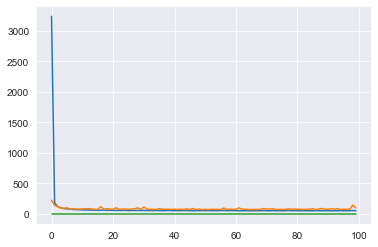

In [114]:
num_epochs = len(dnn_history.val_loss_hist)
xc         = range(num_epochs)
plt.figure()
plt.plot(xc, dnn_history.train_loss_hist, label='train')
plt.plot(xc, dnn_history.val_loss_hist, label='val')
plt.plot(xc, dnn_history.lr_hist, label='lr')
plt.show()

In [115]:
dnn_pred

array([125391.04, 165849.36, 189048.14, ..., 167127.88, 117711.76,
       211976.8 ], dtype=float32)

**Define a cross validation strategy**

We use the **cross_val_score** function of Sklearn. However this function has no shuffle attribute, so we add one line of code,  in order to shuffle the dataset  prior to cross-validation

replace cross_val_score() with cross_validate()
# reference: https://scikit-learn.org/stable/modules/cross_validation.html

    from sklearn.metrics import make_scorer
    scoring = {'prec_macro': 'precision_macro',
               'rec_macro': make_scorer(recall_score, average='macro')}
    scores = cross_validate(clf, X, y, scoring=scoring,
                            cv=5, return_train_score=True)
    sorted(scores.keys())
    ['fit_time', 'score_time', 'test_prec_macro', 'test_rec_macro',
     'train_prec_macro', 'train_rec_macro']
    scores['train_rec_macro']
    array([0.97..., 0.97..., 0.99..., 0.98..., 0.98...])

Kfold is useful for thorough testing of a model, will give a more accurate score based on remove some data test on the remaining and change the data removed each time. See image below for details:

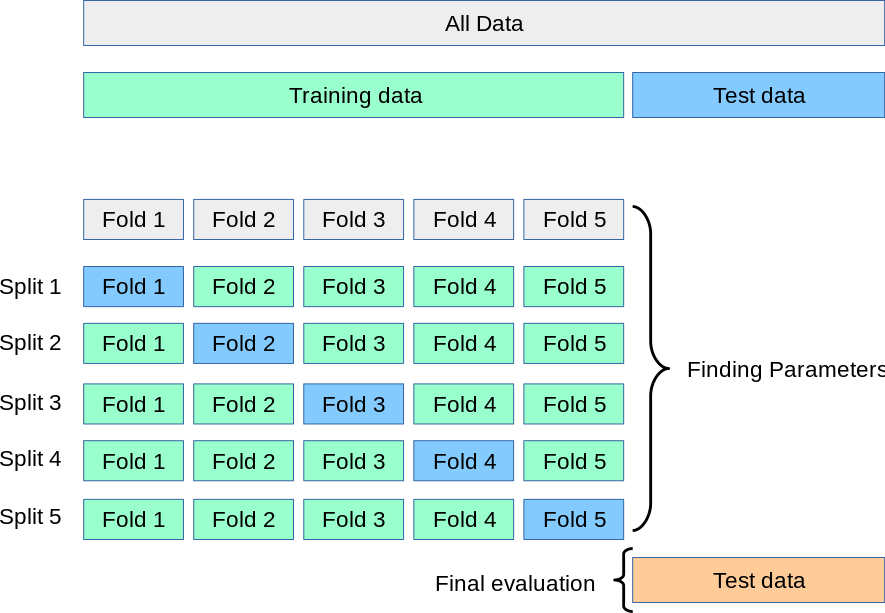

In [116]:
#Validation function
# train and y_train are both log scaled so just need to take the square of the delta between them to calculate the error, then take the sqrt to get rmsle
# but for now y_train is boxcox1p(), not log(). Use this to convert back: inv_boxcox1p(y_train, lam_l)
n_folds=5 # was 5 => better score but twice as slow now

def rmsle_cv(model):
    print("running rmsle_cv code")
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train) # was 42
    rmse= np.sqrt(-cross_val_score(model, train, y_train, scoring="neg_mean_squared_error", cv = kf)) # also r2
    print("raw rmse scores for each fold:", rmse)
    return(rmse)

def r2_cv(model):
    print("running r2_cv code")
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train) # was 42
    r2= cross_val_score(model, train, y_train, scoring="r2", cv = kf) # also r2
    print("raw r2 scores for each fold:", r2)
    return(r2)

# used for another competition
def mae_cv(model):
    print("running mae_cv code")
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train) # was 42
    mae = -cross_val_score(model, train, y_train, scoring="neg_mean_absolute_error", cv = kf) # also r2
    print("raw mae scores for each fold:", mae)
    return(mae)

def all_cv(model, n_folds, cv):
    print("running cross_validate")
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train) # was 42
    # other scores: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    scorers = {
        'r2': 'r2',
        'nmsle': 'neg_mean_squared_log_error', 
        'nmse': 'neg_mean_squared_error',
        'mae': 'neg_mean_absolute_error'
    }
    scores = cross_validate(model, train, y_train, scoring=scorers,
                           cv=kf, return_train_score=True)
    return(scores)

In [117]:
print(y_train.mean())
print(inv_boxcox1p(y_train, lam_l).mean())

191.1847768199786
180932.91906721535


##Base models

In [118]:
def runGSCV(num_trials, features, y_values):
    non_nested_scores = np.zeros(num_trials) # INCREASES BIAS
    nested_scores = np.zeros(num_trials)
    # Loop for each trial
    for i in range(num_trials):
        print("Running GridSearchCV:")
        with MyTimer():    
            #grid_result = gsc.fit(train, y_train)  
            grid_result = gsc.fit(features, y_values)  
        non_nested_scores[i] = grid_result.best_score_
        if (competition == 'SR'):
            print("Best mae %f using %s" % ( -grid_result.best_score_, grid_result.best_params_))
        else:
            print("Best rmse %f using %s" % ( np.sqrt(-grid_result.best_score_), grid_result.best_params_))
        
        # nested/non-nested cross validation: https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html
        with MyTimer():    
            #nested_score = cross_val_score(gsc, X=train, y=y_train, cv=outer_cv, verbose=0).mean() 
            nested_score = cross_val_score(gsc, X=features, y=y_values, cv=outer_cv, verbose=0).mean() 
            # source code for cross_val_score is here: https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_validation.py#L137
        if (competition == 'SR'):
            print("nested mae score from KFold %0.3f" % -nested_score)
        else:
            print("nested rmse score from KFold %0.3f" % np.sqrt(-nested_score))
        
        nested_scores[i] = nested_score
        print('grid_result',grid_result)
        print("mean scores: r2(%0.3f) mae(%0.3f) nmse(%0.3f) nmsle(%0.3f)" % (grid_result.cv_results_['mean_test_r2'].mean(), -grid_result.cv_results_['mean_test_mae'].mean(),  np.sqrt(-grid_result.cv_results_['mean_test_nmse'].mean()), grid_result.cv_results_['mean_test_nmsle'].mean() ))
        #print("mean scores: r2(%0.3f) nmse(%0.3f) mae(%0.3f)" % (grid_result.cv_results_['mean_test_r2'].mean(), np.sqrt(-grid_result.cv_results_['mean_test_nmse'].mean()), grid_result.cv_results_['mean_test_mae'].mean()))
    return grid_result


In [119]:
def calc_all_scores(model, n_folds=5, cv=5):
    scores = all_cv(model, n_folds, cv)
    #scores['train_<scorer1_name>'']
    #scores['test_<scorer1_name>'']
    print("\n mae_cv score: {:.4f} ({:.4f})\n".format( (-scores['test_mae']).mean(), scores['test_mae'].std() ))
    print("\n rmsle_cv score: {:.4f} ({:.4f})\n".format( (np.sqrt(-scores['test_nmse'])).mean(), scores['test_nmse'].std() ))
    print("\n r2_cv score: {:.4f} ({:.4f})\n".format( scores['test_r2'].mean(), scores['test_r2'].std() ))
    return (scores)

# useful when you can't decide on parameter setting from best_params_
# result_details(grid_result,'mean_test_nmse',100)
def result_details(grid_result,sorting='mean_test_nmse',cols=100):
    param_df = pd.DataFrame.from_records(grid_result.cv_results_['params'])
    param_df['mean_test_nmse'] = np.sqrt(-grid_result.cv_results_['mean_test_nmse'])
    param_df['std_test_nmse'] = np.sqrt(grid_result.cv_results_['std_test_nmse'])
    param_df['mean_test_mae'] = -grid_result.cv_results_['mean_test_mae']
    param_df['std_test_mae'] = -grid_result.cv_results_['std_test_mae']
    param_df['mean_test_r2'] = -grid_result.cv_results_['mean_test_r2']
    param_df['std_test_r2'] = -grid_result.cv_results_['std_test_r2']
    return param_df.sort_values(by=[sorting]).tail(cols)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def mae(y, y_pred):
    return mean_absolute_error(y,y_pred)


List of possible scoring values:  
Regression  

‘explained_variance’ metrics.explained_variance_score  
‘max_error’ metrics.max_error  
‘neg_mean_absolute_error’ metrics.mean_absolute_error  
‘neg_mean_squared_error’ metrics.mean_squared_error  
‘neg_root_mean_squared_error’ metrics.mean_squared_error  
‘neg_mean_squared_log_error’ metrics.mean_squared_log_error  
‘neg_median_absolute_error’ metrics.median_absolute_error  
‘r2’ metrics.r2_score  
‘neg_mean_poisson_deviance’ metrics.mean_poisson_deviance  
‘neg_mean_gamma_deviance’ metrics.mean_gamma_deviance  

-  **LASSO  Regression**  : 

This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's  **Robustscaler()**  method on pipeline, also want to compare to StandardScaler() => RobustScaler() is slightly better

In [120]:
# initialize the algorithm for the GridSearchCV function
lasso = Lasso()
tuningLasso = 1 # takes 2 minutes to complete

if (tuningLasso == 1):
    # use this when tuning
    param_grid={
        'alpha':[0.01,], # done, lower keeps getting better, but don't want to go too low and begin overfitting (alpha is related to L1 reg)
        'fit_intercept':[True], # done, big difference
        'normalize':[False], # done, big difference
        'precompute':[False], # done, no difference
        'copy_X':[True], # done, no difference
        'max_iter':[200], # done
        'tol':[0.05], # done, not much difference # was 0.005 but that would cause error: ConvergenceWarning: Objective did not converge
        'warm_start':[False], # done, no difference
        'positive':[False], # done, big difference
        'random_state':[1],
        'selection':['cyclic'] # done both are same, cyclic is default
    }

else:
    # use this when not tuning
    param_grid={
        'alpha':[0.2], 
        'fit_intercept':[True],
        'normalize':[False],
        'precompute':[False],
        'copy_X':[True],
        'max_iter':[200],
        'tol':[0.0001],
        'warm_start':[False],
        'positive':[False],
        'random_state':[None],
        'selection':['cyclic']
    }

scorers = {
    'r2': 'r2',
    'nmsle': 'neg_mean_squared_log_error', 
    'nmse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}
# To be used within GridSearch 
inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)

# To be used in outer CV 
outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

#inner loop KFold example:
gsc = GridSearchCV(
    estimator=lasso,
    param_grid=param_grid,
    #scoring='neg_mean_squared_error', # 'roc_auc', # or 'r2', etc
    scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
    #scoring='neg_mean_squared_error', # or look here for other choices 
    # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    #cv=5,
    cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
    verbose=0,
    return_train_score=True, # keep the other scores
    refit='nmse' # use this one for optimizing
)

grid_result = runGSCV(2, train, y_train)

rd = result_details(grid_result,'random_state',100)
rd[['random_state','alpha','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']].sort_values(by=['random_state','alpha'])


Running GridSearchCV:
The function took 0.2137451171875 seconds to complete
Best mae 81.680404 using {'alpha': 0.01, 'copy_X': True, 'fit_intercept': True, 'max_iter': 200, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': 1, 'selection': 'cyclic', 'tol': 0.05, 'warm_start': False}
The function took 0.6724646091461182 seconds to complete
nested mae score from KFold 81.281
grid_result GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': [0.01], 'copy_X': [True],
                         'fit_intercept': [True], 'max_iter': [200],
                         'normalize': [False], 'positive': [False],
                         'precompute': [False], 'random_state': [1],
                         'selection': ['cyclic'], 'tol': [0.05],
                         'warm_start': [False]},
             refit='nmse', return_train_score=True,
             scoring={'mae': 'neg_mean_absolute_error',

random_state  alpha  mean_test_nmse  std_test_nmse  mean_test_mae  \
0             1  0.010           9.027          2.917          6.520   

   std_test_mae  mean_test_r2  std_test_r2  
0        -0.334        -0.893       -0.008

In [121]:
tuning_lasso = 1
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, tol=0.05, random_state=1)) # was 1 
lasso_new = make_pipeline(RobustScaler(), Lasso(**grid_result.best_params_))
#l = "{'alpha': 0.2, 'copy_X': True, 'fit_intercept': True, 'max_iter': 200, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': 1, 'selection': 'cyclic', 'tol': 0.005, 'warm_start': False}"
#Lasso_new = make_pipeline(RobustScaler(), Lasso(**l))
#lasso_ss = make_pipeline(StandardScaler(), Lasso(alpha =0.0005, random_state=1)) # was 1 => worse score

In [122]:
if (tuning_lasso == 1):
    #TEMP
    model_results = [] # model flow, mae, rmsle
    models = [lasso, lasso_new]

    for model in models:
        #print(model)
        with MyTimer(): 
            scores = calc_all_scores(model,5,5)
        #print("------------------------------------------")
        model_results.append([model, (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])

    df_mr = pd.DataFrame(model_results, columns = ['model','mae','rmsle','r2'])
    df_mr.sort_values(by=['rmsle'])

running cross_validate

 mae_cv score: 6.1747 (0.2965)


 rmsle_cv score: 8.8612 (10.3570)


 r2_cv score: 0.8966 (0.0070)

The function took 0.6949102878570557 seconds to complete
running cross_validate

 mae_cv score: 5.8716 (0.3255)


 rmsle_cv score: 8.2973 (9.8885)


 r2_cv score: 0.9093 (0.0077)

The function took 0.59828782081604 seconds to complete


In [123]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, tol=0.05, random_state=1)) # was 1 

if (tuning_lasso == 1):
    for i in [2,5,20,42,99]:
        from sklearn.linear_model import Lasso
        print('random_state =',i)

        l = {'alpha': 0.01, 'copy_X': True, 'fit_intercept': True, 'max_iter': 200, 'normalize': False, 'positive': False, 'precompute': False, 'selection': 'cyclic', 'tol': 0.05, 'warm_start': False}
        lasso_new = make_pipeline(RobustScaler(), Lasso(**l, random_state=i))
        #lasso_new = Lasso(**l, random_state=i)

        model_results = [] # model flow, mae, rmsle
        models = [lasso, lasso_new]

        for model in models:
            #print(model)
            with MyTimer(): 
                scores = calc_all_scores(model,5,5)
            #print("------------------------------------------")
            model_results.append([model, (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])

        df_mr = pd.DataFrame(model_results, columns = ['model','mae','rmsle','r2'])
        print(df_mr.sort_values(by=['rmsle']))
else:
    lasso_new = make_pipeline(RobustScaler(), Lasso(**grid_result.best_params_, random_state=i))

random_state = 2
running cross_validate

 mae_cv score: 6.1747 (0.2965)


 rmsle_cv score: 8.8612 (10.3570)


 r2_cv score: 0.8966 (0.0070)

The function took 0.6070702075958252 seconds to complete
running cross_validate

 mae_cv score: 5.8716 (0.3255)


 rmsle_cv score: 8.2973 (9.8885)


 r2_cv score: 0.9093 (0.0077)

The function took 0.5280163288116455 seconds to complete
                                               model   mae  rmsle    r2
1  (RobustScaler(), Lasso(alpha=0.01, max_iter=20... 5.872  8.297 0.909
0  (RobustScaler(), Lasso(alpha=0.0005, random_st... 6.175  8.861 0.897
random_state = 5
running cross_validate

 mae_cv score: 6.1747 (0.2965)


 rmsle_cv score: 8.8612 (10.3570)


 r2_cv score: 0.8966 (0.0070)

The function took 0.500690221786499 seconds to complete
running cross_validate

 mae_cv score: 5.8716 (0.3255)


 rmsle_cv score: 8.2973 (9.8885)


 r2_cv score: 0.9093 (0.0077)

The function took 0.5611960887908936 seconds to complete
                             

In [124]:
model_results

[[Pipeline(steps=[('robustscaler', RobustScaler()),
                  ('lasso', Lasso(alpha=0.0005, random_state=1, tol=0.05))]),
  6.174711821224802,
  8.861181052928826,
  0.8965982514624196],
 [Pipeline(steps=[('robustscaler', RobustScaler()),
                  ('lasso',
                   Lasso(alpha=0.01, max_iter=200, random_state=99, tol=0.05))]),
  5.871569158024943,
  8.297270197579941,
  0.9093130675200406]]

In [125]:
method

'ensemble'

- **Elastic Net Regression** :

again made robust to outliers

combines Lasso L1 Linear regularization and Ridge L2 Quadratic/Squared regularization penalties together into one algorithm

In [126]:
# initialize the algorithm for the GridSearchCV function
if (method == "ensemble"):
    enet_tol = 0.01 # or try 0.01 - default is 0.0001
    ENet = ElasticNet(tol=enet_tol) # added tol=0.05 to avoid errors
    tuningENet = 0 # takes 2 minutes to complete

    if (tuningENet == 1):
        # use this when tuning
        param_grid={
            'alpha':[0.01],
            'l1_ratio':[0.75,0.8,0.85,0.9],
            'fit_intercept':[True], # ,False
            'normalize':[False], # True,
            'max_iter':range(350,450,50),
            'selection':['random'], # 'cyclic',
            'random_state':[3],
            'tol':[enet_tol]
        }

    else:
        # use this when not tuning
        param_grid={
            'alpha':[0.01],
            'l1_ratio':[.9],
            'fit_intercept':[True],
            'normalize':[False],
            'max_iter':[350], # default 1000
            'selection':['random'],
            'random_state':[3],
            'tol':[enet_tol]
        }

else: # (method == "stacked")
    enet_tol = 0.0001 # or try 0.01 
    ENet = ElasticNet() # added tol=0.05 to avoid errors
    tuningENet = 0 # takes 2 minutes to complete

    if (tuningENet == 1):
        # use this when tuning
        param_grid={
            'alpha':[0.01,0.05],
            'l1_ratio':[0.8,0.85,0.9],
            'fit_intercept':[True], # ,False
            'normalize':[False], # True,
            'max_iter':range(350,450,50),
            'selection':['random'], # 'cyclic',
            'random_state':[3],
            'tol':[enet_tol]
        }

    else:
        # use this when not tuning
        param_grid={
            'alpha':[0.05],
            'l1_ratio':[.85],
            'fit_intercept':[True],
            'normalize':[False],
            'max_iter':[500], # default 1000
            'selection':['random'],
            'random_state':[3],
            'tol':[enet_tol]
        }

scorers = {
    'r2': 'r2',
    'nmsle': 'neg_mean_squared_log_error',
    'nmse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}
# To be used within GridSearch 
inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)

# To be used in outer CV 
outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

#inner loop KFold example:
gsc = GridSearchCV(
    estimator=ENet,
    param_grid=param_grid,
    scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
    #scoring='neg_mean_squared_error', # or look here for other choices 
    # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    #cv=5,
    cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
    verbose=0,
    return_train_score=True, # keep the other scores
    refit='nmse' # use this one for optimizing
)

grid_result = runGSCV(5, train, y_train)

rd = result_details(grid_result,'mean_test_nmse',100)
rd[['max_iter','l1_ratio','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']]#.sort_values(by=['n_estimators','mean_test_nmse'])


Running GridSearchCV:
The function took 0.37966322898864746 seconds to complete
Best mae 68.313046 using {'alpha': 0.01, 'fit_intercept': True, 'l1_ratio': 0.9, 'max_iter': 350, 'normalize': False, 'random_state': 3, 'selection': 'random', 'tol': 0.01}
The function took 1.0140650272369385 seconds to complete
nested mae score from KFold 63.741
grid_result GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=True),
             estimator=ElasticNet(tol=0.01),
             param_grid={'alpha': [0.01], 'fit_intercept': [True],
                         'l1_ratio': [0.9], 'max_iter': [350],
                         'normalize': [False], 'random_state': [3],
                         'selection': ['random'], 'tol': [0.01]},
             refit='nmse', return_train_score=True,
             scoring={'mae': 'neg_mean_absolute_error',
                      'nmse': 'neg_mean_squared_error',
                      'nmsle': 'neg_mean_squared_log_error', 'r2': 'r2'})
mean scores: r2(0.910) mae(5

max_iter  l1_ratio  mean_test_nmse  std_test_nmse  mean_test_mae  \
0       350     0.900           8.140          1.569          5.658   

   std_test_mae  mean_test_r2  std_test_r2  
0        -0.131        -0.912       -0.009

In [127]:
grid_result.best_params_

{'alpha': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.9,
 'max_iter': 350,
 'normalize': False,
 'random_state': 3,
 'selection': 'random',
 'tol': 0.01}

In [128]:
rd = result_details(grid_result,'mean_test_nmse',100)
rd[['max_iter','l1_ratio','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']].sort_values(by=['max_iter','l1_ratio'])


max_iter  l1_ratio  mean_test_nmse  std_test_nmse  mean_test_mae  \
0       350     0.900           8.140          1.569          5.658   

   std_test_mae  mean_test_r2  std_test_r2  
0        -0.131        -0.912       -0.009

In [129]:
#ENet_orig = make_pipeline(StandardScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
ENet = make_pipeline(StandardScaler(), ElasticNet(**grid_result.best_params_))
ENet_new = make_pipeline(RobustScaler(), ElasticNet(**grid_result.best_params_))

polynomial_features = PolynomialFeatures(degree=2, include_bias=False)
ENet_poly = Pipeline([("polynomial_features", polynomial_features), ("ENet", ENet)])

- **LinearRegression** :

Polynomial pipeline

reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html#sphx-glr-auto-examples-model-selection-plot-underfitting-overfitting-py


In [130]:
# initialize the algorithm for the GridSearchCV function
lr1 = LinearRegression()
tuningLR = 0 # takes 2 minutes to complete

if (tuningLR == 1):
    # use this when tuning
    param_grid={
        'fit_intercept':[True,False], 
        'normalize':[True,False]
    }

else:
    # use this when not tuning
    param_grid={
        'fit_intercept':[False], 
        'normalize':[False]
    }

scorers = {
    'r2': 'r2',
    #'nmsle': 'neg_mean_squared_log_error',
    'nmse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}
# To be used within GridSearch 
inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)

# To be used in outer CV 
outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

#inner loop KFold example:
gsc = GridSearchCV(
    estimator=lr1,
    param_grid=param_grid,
    scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
    #scoring='neg_mean_squared_error', # or look here for other choices 
    # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    #cv=5,
    cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
    verbose=0,
    return_train_score=True, # keep the other scores
    refit='nmse' # use this one for optimizing
)

grid_result = gsc.fit(train, y_train) 
#grid_result = runGSCV(2, train, y_train)

rd = result_details(grid_result,'mean_test_nmse',100)
rd[['fit_intercept','normalize','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']]#.sort_values(by=['n_estimators','mean_test_nmse'])


fit_intercept  normalize  mean_test_nmse  std_test_nmse  mean_test_mae  \
0          False      False          52.220         45.985         11.714   

   std_test_mae  mean_test_r2  std_test_r2  
0        -4.233         2.433       -2.541

In [131]:
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)
lr1 = LinearRegression(fit_intercept=True,normalize=False) # defaults fit_intercept=True, normalize=False
from sklearn.feature_selection import f_regression, f_classif
#lr_poly = Pipeline([("polynomial_features", polynomial_features), ("linear_regression", LinearRegression(fit_intercept=True,normalize=False))])

# using PCA
lr_poly = Pipeline([("polynomial_features", polynomial_features), ('reduce_dim', PCA(n_components=360)), ("linear_regression", LinearRegression())])
# using NMF
#lr_poly = Pipeline([("polynomial_features", polynomial_features), ('reduce_dim', NMF(n_components=360, alpha=0.8, l1_ratio=0.8,random_state=0)), ("linear_regression", LinearRegression())])
# using SelectKBest (score_func: also chi2, f_regression) - doesn't work, gives blank predictions and some very high and low predictions
#lr_poly = Pipeline([("polynomial_features", polynomial_features), ('reduce_dim', SelectKBest(score_func=f_regression,k=1000)), ("linear_regression", LinearRegression(normalize=True))])


now we have 100x the original (~ 200) number of features (~ 20000)

In [132]:
trans = PolynomialFeatures(degree=2)
data = trans.fit_transform(train)
print(data)
print(data.shape)

[[1.         2.88584647 5.83132789 ... 1.         0.         0.        ]
 [1.         2.05564154 6.22121363 ... 1.         0.         0.        ]
 [1.         2.88584647 5.91494002 ... 1.         0.         0.        ]
 ...
 [1.         3.01134024 5.85955121 ... 1.         0.         0.        ]
 [1.         2.05564154 5.91494002 ... 1.         0.         0.        ]
 [1.         2.05564154 6.0986261  ... 1.         0.         0.        ]]
(1458, 25200)


- **Kernel Ridge Regression** :

In [133]:
tune_kr = 1
if (tune_kr == 1):
    # initialize the algorithm for the GridSearchCV function
    KRR = KernelRidge()
    tuningKRR = 0 # this took 40 mins, 20 per iteration

    if (tuningKRR == 1):
        # use this when tuning
        param_grid={
            'alpha':[2.2,2.4], 
            'kernel':['polynomial'], #for entire list see: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.kernel_metrics.html#sklearn.metrics.pairwise.kernel_metrics
            'gamma':[0.0001,0.001,0.01,0.1],
            'degree':[1,2,3,4,5,6], 
            'coef0':[0.1,0.3,0.5,1.0,2.0]
        }

    else:
        # use this when not tuning
        # nmse: Best mae 583416973.611280 using {'alpha': 2.2, 'coef0': 0.5, 'degree': 5, 'gamma': 0.001, 'kernel': 'polynomial'}
        # mae: Best mae 15805.764347 using {'alpha': 2.0, 'coef0': 0.1, 'degree': 5, 'gamma': 0.001, 'kernel': 'polynomial'}
        param_grid={
            'alpha':[2.2], 
            'kernel':['polynomial'], # 'linear', 'rbf'
            'gamma':[0.001],
            'degree':[4], 
            'coef0':[1.0]
        }
    scorers = {
        'r2': 'r2',
        'nmsle': 'neg_mean_squared_log_error',
        'nmse': 'neg_mean_squared_error',
        'mae': 'neg_mean_absolute_error'
    }
    # To be used within GridSearch 
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)
    # To be used in outer CV 
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

    #inner loop KFold example:
    gsc = GridSearchCV(
        estimator=KRR,
        param_grid=param_grid,
        scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
        #scoring='neg_mean_squared_error', # or look here for other choices 
        # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
        #cv=5,
        cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
        verbose=0,
        return_train_score=True, # keep the other scores
        refit='nmse' # use this one for optimizing
    )

    grid_result = runGSCV(2, train, y_train)

    rd = result_details(grid_result,'mean_test_nmse',100)
    rd[['alpha','degree','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']]#.sort_values(by=['n_estimators','mean_test_nmse'])


Running GridSearchCV:
The function took 1.214143991470337 seconds to complete
Best mae 58.518689 using {'alpha': 2.2, 'coef0': 1.0, 'degree': 4, 'gamma': 0.001, 'kernel': 'polynomial'}
The function took 2.555169105529785 seconds to complete
nested mae score from KFold 58.888
grid_result GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=True),
             estimator=KernelRidge(),
             param_grid={'alpha': [2.2], 'coef0': [1.0], 'degree': [4],
                         'gamma': [0.001], 'kernel': ['polynomial']},
             refit='nmse', return_train_score=True,
             scoring={'mae': 'neg_mean_absolute_error',
                      'nmse': 'neg_mean_squared_error',
                      'nmsle': 'neg_mean_squared_log_error', 'r2': 'r2'})
mean scores: r2(0.923) mae(5.436) nmse(7.650) nmsle(-0.002)
Running GridSearchCV:
The function took 1.1077594757080078 seconds to complete
Best mae 59.467401 using {'alpha': 2.2, 'coef0': 1.0, 'degree': 4, 'gamma': 0.001, 'ker

In [134]:
#KRR_orig = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

#KRR = KernelRidge(**grid_result.best_params_)
krr = {'alpha': 2.2, 'coef0': 0.5, 'degree': 5, 'gamma': 0.001, 'kernel': 'polynomial'}
KRR = KernelRidge(**krr)
#KRR = KernelRidge(alpha=2.2, coef0=0.5, degree=5, gamma=0.001, kernel='polynomial')

if (tune_kr == 1):
    KRR_new = KernelRidge(**grid_result.best_params_)
else:
    krr_new = {'alpha': 2.3, 'coef0': 1.0, 'degree': 4, 'gamma': 0.001, 'kernel': 'polynomial'}
    KRR_new = KernelRidge(**krr)

- **Random Forest Regressor** :

This model needs improvement, will run cross validate on it

In [135]:
# initialize the algorithm for the GridSearchCV function
rf = RandomForestRegressor()
tuningRF = 0 # this took 2 hours last time, 1 hour per iteration

if (tuningRF == 1):
    # use this when tuning
    param_grid={
        'max_depth':[3,4,5],
        'max_features':[None,'sqrt','log2'], 
        # 'max_features': range(50,401,50),
        # 'max_features': [50,100], # can be list or range or other
        'n_estimators':range(25,100,25), 
        #'class_weight':[None,'balanced'],  
        'min_samples_leaf':range(5,15,5), 
        'min_samples_split':range(10,30,10), 
        'criterion':['mse', 'mae'] 
    }

else:
    # use this when not tuning
    param_grid={
        'max_depth':[5],
        'max_features':[None], # max_features is None is default and works here, removing 'sqrt','log2'
        # 'max_features': range(50,401,50),
        # 'max_features': [50,100], # can be list or range or other
        'n_estimators': [50], # number of trees selecting 100, removing range(50,126,25)
        #'class_weight':[None], # None was selected, removing 'balanced'
        'min_samples_leaf': [5], #selecting 10, removing range 10,40,10)
        'min_samples_split': [10], # selecting 20, removing range(20,80,10),
        'criterion':['mse'] # remove gini as it is never selected
    }

scorers = {
    'r2': 'r2',
    'nmsle': 'neg_mean_squared_log_error',
    'nmse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}
# To be used within GridSearch 
inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)

# To be used in outer CV 
outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

#inner loop KFold example:
gsc = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
    #scoring='neg_mean_squared_error', # or look here for other choices 
    # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    #cv=5,
    cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
    verbose=0,
    return_train_score=True, # keep the other scores
    refit='nmse' # use this one for optimizing
)

grid_result = runGSCV(2, train, y_train)

rd = result_details(grid_result,'mean_test_nmse',100)
rd[['n_estimators','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']]#.sort_values(by=['n_estimators','mean_test_nmse'])


Running GridSearchCV:
The function took 3.033407688140869 seconds to complete
Best mae 101.357344 using {'criterion': 'mse', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 50}
The function took 9.170491933822632 seconds to complete
nested mae score from KFold 103.973
grid_result GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'criterion': ['mse'], 'max_depth': [5],
                         'max_features': [None], 'min_samples_leaf': [5],
                         'min_samples_split': [10], 'n_estimators': [50]},
             refit='nmse', return_train_score=True,
             scoring={'mae': 'neg_mean_absolute_error',
                      'nmse': 'neg_mean_squared_error',
                      'nmsle': 'neg_mean_squared_log_error', 'r2': 'r2'})
mean scores: r2(0.867) mae(7.218) nmse(10.068) nmsle(-0.003)
Running GridSearchCV:
The function t

n_estimators  mean_test_nmse  std_test_nmse  mean_test_mae  std_test_mae  \
0            50          10.085          3.902          7.213        -0.438   

   mean_test_r2  std_test_r2  
0        -0.866       -0.018

In [136]:
#RF_orig = make_pipeline(StandardScaler(), RandomForestRegressor(max_depth=3,n_estimators=500))
RF = make_pipeline(StandardScaler(), RandomForestRegressor(**grid_result.best_params_)) # better than default, but still not good
RF_new = make_pipeline(RobustScaler(), RandomForestRegressor(**grid_result.best_params_)) # better than default, but still not good

In [137]:
print("Optimize GBoost: ", datetime.datetime.now())

Optimize GBoost:  2020-09-03 22:53:32.070993


- **Gradient Boosting Regression** :

With **huber**  loss that makes it robust to outliers
    

Optimize

In [138]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state=5) # was 5
# learning_ratefloat, default=0.1
# learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators.
tuning_gb = 0
if (tuning_gb == 1):
    # initialize the algorithm for the GridSearchCV function
    GBoost_new = GradientBoostingRegressor()
    tuningGB = 1
    if (tuningGB == 1):
        # use this when tuning
        param_grid={
            #'loss':['ls','lad','huber','quantile'],
            'loss':['huber'], # done
            'learning_rate':[0.05],
            'n_estimators':[3000], # done
            'subsample':[1.0],
            #'criterion':['friedman_mse','mse','mae'],
            'criterion':['friedman_mse'], # done
            'min_samples_split':[10],
            'min_samples_leaf':[15],
            'min_weight_fraction_leaf':[0.0],
            'max_depth':[2,3,4], # done
            'min_impurity_decrease':[0.0],
            'min_impurity_split':[None],
            'init':[None],
            'random_state':[None],
            #'max_features':[None,'auto','sqrt','log2'],
            'max_features':['sqrt'], # done
            'alpha':[0.60], # done
            'verbose':[0],
            'max_leaf_nodes':[None],
            'warm_start':[False],
            'presort':['deprecated'],
            'validation_fraction':[0.1],
            'n_iter_no_change':[None],
            'tol':[0.0001],
            'ccp_alpha':[0.0],
            'random_state':[5,20,42]
        }
    else:
        # use this when not tuning
        param_grid={
            'loss':['huber'], 
            'learning_rate':[0.05],
            'n_estimators':[3000], 
            'subsample':[1.0],
            'criterion':['friedman_mse'], 
            'min_samples_split':[10],
            'min_samples_leaf':[15],
            'min_weight_fraction_leaf':[0.0],
            'max_depth':[2], 
            'min_impurity_decrease':[0.0],
            'min_impurity_split':[None],
            'init':[None],
            'random_state':[None],
            'max_features':['sqrt'], 
            'alpha':[0.60], 
            'verbose':[0],
            'max_leaf_nodes':[None],
            'warm_start':[False],
            'presort':['deprecated'],
            'validation_fraction':[0.1],
            'n_iter_no_change':[None],
            'tol':[0.0001],
            'ccp_alpha':[0.0],
            'random_state':[5]
        }
    scorers = {
        'r2': 'r2',
        'nmsle': 'neg_mean_squared_log_error',
        'nmse': 'neg_mean_squared_error',
        'mae': 'neg_mean_absolute_error'
    }
    # To be used within GridSearch 
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)
    # To be used in outer CV 
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

    #inner loop KFold example:
    gsc = GridSearchCV(
        estimator=GBoost_new,
        param_grid=param_grid,
        scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
        cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
        verbose=0,
        return_train_score=True, # keep the other scores
        refit='nmse' # use this one for optimizing
    )

    grid_result = runGSCV(2, subtrain, y_subtrain)

rd = result_details(grid_result,'mean_test_nmse',100)
rd[['criterion','max_depth','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']]#.sort_values(by=['n_estimators','mean_test_nmse'])


criterion  max_depth  mean_test_nmse  std_test_nmse  mean_test_mae  \
0       mse          5          10.085          3.902          7.213   

   std_test_mae  mean_test_r2  std_test_r2  
0        -0.438        -0.866       -0.018

In [139]:
rd[['criterion','max_depth','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']].sort_values(by=['criterion','max_depth'])


criterion  max_depth  mean_test_nmse  std_test_nmse  mean_test_mae  \
0       mse          5          10.085          3.902          7.213   

   std_test_mae  mean_test_r2  std_test_r2  
0        -0.438        -0.866       -0.018

I am getting conflicting results for  best params, sometimes huber or lad and sometimes friedman_mse or mae, so will look at more detailed output. This style output is much more useful for deciding between parameter values, adding the different random states shows the consistency, or lack of, for each setting

maybe do a groupby to make this table more manageable and easier to read

In [140]:
if (tuning_gb == 1):
    GBoost_new = GradientBoostingRegressor(**grid_result.best_params_)
else:
    gbr  = {'alpha': 0.6, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 15, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 3000, 'n_iter_no_change': None, 'presort': 'deprecated', 'random_state': 5, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
    GBoost_new = GradientBoostingRegressor(**gbr)

In [141]:
if (tuning_gb == 1):
    #TEMP
    model_results = [] # model flow, mae, rmsle
    models = [GBoost, GBoost_new]

    for model in models:
        #print(model)
        with MyTimer(): 
            scores = calc_all_scores(model,5,5)
        #print("------------------------------------------")
        model_results.append([model, (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])

    df_mr = pd.DataFrame(model_results, columns = ['model','mae','rmsle','r2'])
    df_mr.sort_values(by=['rmsle'])

- **Additional testing**

Compare any random state

In [142]:
if (tuning_gb == 1):
    GBoost.fit(subtrain.values, y_subtrain)
    gboost_train_pred = inv_boxcox1p(GBoost.predict(subtrain.values), lam_l)
    gboost_val_pred = inv_boxcox1p(GBoost.predict(val.values), lam_l)
    print('GBoost')
    print('train results')
    print(mae(y_subtrain, gboost_train_pred))
    print(rmsle(y_subtrain, gboost_train_pred))
    print('test results')
    print(mae(y_val, gboost_val_pred))
    print(rmsle(y_val, gboost_val_pred))

    GBoost_new.fit(subtrain.values, y_subtrain)
    gboost_train_pred = inv_boxcox1p(GBoost_new.predict(subtrain.values), lam_l)
    gboost_val_pred = inv_boxcox1p(GBoost_new.predict(val.values), lam_l)
    print('GBoost_new')
    print('train results')
    print(mae(y_subtrain, gboost_train_pred))
    print(rmsle(y_subtrain, gboost_train_pred))
    print('test results')
    print(mae(y_val, gboost_val_pred))
    print(rmsle(y_val, gboost_val_pred))

In [143]:
if (tuning_gb == 1):
    GBoost_new.fit(train, y_train)
    gboost_pred = inv_boxcox1p(GBoost_new.predict(test), lam_l)
    gboost_pred
    sub = pd.DataFrame()
    #sub['Id'] = test['Id']
    sub['Id'] = test_ID
    sub['SalePrice'] = gboost_pred
    sub.to_csv('submission.csv',index=False)

In [144]:
if (tuning_gb == 1):
    GBoost.fit(train, y_train)
    gboost_pred = inv_boxcox1p(GBoost.predict(test), lam_l)
    gboost_pred
    sub = pd.DataFrame()
    #sub['Id'] = test['Id']
    sub['Id'] = test_ID
    sub['SalePrice'] = gboost_pred
    sub.to_csv('submission.csv',index=False)

- **Additional testing**

Compare any random state

In [145]:
if (tuning_gb == 1):

    model_results = [] # model flow, mae, rmsle
    models = [GBoost, GBoost_new]

    for model in models:
        #print(model)
        with MyTimer(): 
            scores = calc_all_scores(model,10,10)
        #print("------------------------------------------")
        model_results.append([model, (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])

    df_mr = pd.DataFrame(model_results, columns = ['model','mae','rmsle','r2'])
    df_mr.sort_values(by=['rmsle'])

- **XGBoost** :

In [146]:
print("Optimize XGB: ", datetime.datetime.now())

Optimize XGB:  2020-09-03 22:53:32.264242


In [147]:
tuning_xgb = 0
if (tuning_xgb == 1):
    # initialize the algorithm for the GridSearchCV function# initialize the algorithm for the GridSearchCV function
    xgb1 = xgb.XGBRegressor()
    tuningXGB = 1 # this took 2 hours last time, 1 hour per iteration

    if (tuningXGB == 1):
        # use this when tuning
        param_grid={
            'colsample_bytree':[0.4603],
            'gamma':[0.0468], # done - all values almost identical results
            'colsample_bylevel':[0.3], # done - all give same result
            'objective':['reg:squarederror'], # done - Default:'reg:squarederror', None, reg:pseudohubererror, reg:squaredlogerror, reg:gamma
            'booster':['gbtree'], # done - Default: 'gbtree', 'gblinear' or 'dart'
            'learning_rate':[0.04], # done
            'max_depth':[3], # - done
            'importance_type':['gain'], # done - all give same value, Default:'gain', 'weight', 'cover', 'total_gain' or 'total_cover'
            'min_child_weight':[1.7817], # done - no difference with several values
            'n_estimators':[1000], # done
            'reg_alpha':[0.4], # done
            'reg_lambda':[0.8571], # done
            'subsample':[0.5], # done
            'silent':[1],
            'random_state':[35],
            'scale_pos_weight':[1],
            'eval_metric':['rmse'], # done - all options have same results  Default:rmse for regression rmse, mae, rmsle, logloss, cox-nloglik
            #'nthread ':[-1],
            'verbosity':[0]
        }

    else:
        # use this when not tuning
        param_grid={
            'colsample_bytree':[0.4603],
            'gamma':[0.0468],
            'colsample_bylevel':[0.3],
            'objective':['reg:squarederror'], # 'binary:logistic', 'reg:squarederror', 'rank:pairwise', None
            'booster':['gbtree'], # 'gbtree', 'gblinear' or 'dart'
            'learning_rate':[0.04],
            'max_depth':[3],
            'importance_type':['gain'], # 'gain', 'weight', 'cover', 'total_gain' or 'total_cover'
            'min_child_weight':[1.7817],
            'n_estimators':[1000],
            'reg_alpha':[0.4],
            'reg_lambda':[0.8571],
            'subsample':[0.5],
            'silent':[1],
            'random_state':[35],
            'scale_pos_weight':[1],
            'eval_metric':['rmse'],
            #'nthread ':[-1],
            'nthread ':[-1],
            'verbosity':[0]
        }

    scorers = {
        'r2': 'r2',
        'nmsle': 'neg_mean_squared_log_error',
        'nmse': 'neg_mean_squared_error',
        'mae': 'neg_mean_absolute_error'
    }
    # To be used within GridSearch 
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)

    # To be used in outer CV 
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

    #inner loop KFold example:
    gsc = GridSearchCV(
        estimator=xgb1,
        param_grid=param_grid,
        scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
        #scoring='neg_mean_squared_error', # or look here for other choices 
        # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
        #cv=5,
        cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
        verbose=0,
        return_train_score=True, # keep the other scores
        refit='nmse' # use this one for optimizing
    )

    grid_result = runGSCV(2, train, y_train)


xgb reference: https://xgboost.readthedocs.io/en/latest/parameter.html

In [148]:
if (tuning_xgb == 1):
    rd = result_details(grid_result,'mean_test_nmse',100)

    rd[['random_state','eval_metric','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']].sort_values(by=['random_state','mean_test_nmse'])


In [149]:
model_xgb = xgb.XGBRegressor(booster='gbtree',colsample_bytree=0.4603, gamma=0.0468, # colsample_bylevel, objective, booster (gbtree, gblinear or dart.) # Default: 'gbtree'
                             learning_rate=0.05, max_depth=3, # importance_type (“gain”, “weight”, “cover”, “total_gain” or “total_cover”.)
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state=35) # was random_state=7, cannot set to None 

if (tuning_xgb == 1):
    import xgboost as xgb
    for i in [2,5,20,42,99]:
        print('random_state =',i)

        model_xgb_new = xgb.XGBRegressor(booster='gbtree',colsample_bytree=0.4603, gamma=0.0468, # colsample_bylevel, objective, booster (gbtree, gblinear or dart.) # Default: 'gbtree'
                                 learning_rate=0.04, max_depth=3, # importance_type (“gain”, “weight”, “cover”, “total_gain” or “total_cover”.)
                                 min_child_weight=1.7817, n_estimators=1000,
                                 reg_alpha=0.4, reg_lambda=0.8571,
                                 subsample=0.45, silent=1,
                                 random_state=i) # was random_state=7, cannot set to None 

        model_xgb_new2 = xgb.XGBRegressor(booster='gbtree',colsample_bytree=0.4603, gamma=0.0468, # colsample_bylevel, objective, booster (gbtree, gblinear or dart.) # Default: 'gbtree'
                                 learning_rate=0.04, max_depth=3, # importance_type (“gain”, “weight”, “cover”, “total_gain” or “total_cover”.)
                                 min_child_weight=1.7817, n_estimators=1000,
                                 reg_alpha=0.4, reg_lambda=0.8571,
                                 subsample=0.5, silent=1,
                                 random_state=i) # was random_state=7, cannot set to None 

        model_xgb_new3 = xgb.XGBRegressor(booster='gbtree',colsample_bytree=0.4603, gamma=0.0468, # colsample_bylevel, objective, booster (gbtree, gblinear or dart.) # Default: 'gbtree'
                                 learning_rate=0.04, max_depth=3, # importance_type (“gain”, “weight”, “cover”, “total_gain” or “total_cover”.)
                                 min_child_weight=1.7817, n_estimators=1000,
                                 reg_alpha=0.4, reg_lambda=0.8571,
                                 subsample=0.5213, silent=1,
                                 random_state=i) # was random_state=7, cannot set to None

        model_results = [] # model flow, mae, rmsle
        models = [model_xgb, model_xgb_new, model_xgb_new2, model_xgb_new3]

        for model in models:
            #print(model)
            with MyTimer(): 
                scores = calc_all_scores(model,5,5)
            #print("------------------------------------------")
            model_results.append([model, (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])

        df_mr = pd.DataFrame(model_results, columns = ['model','mae','rmsle','r2'])
        print(df_mr.sort_values(by=['rmsle']))
else:
    model_xgb_new = xgb.XGBRegressor(**grid_result.best_params_)

Visualize the results

In [150]:
show_metrics = 0
if (show_metrics == 1):
    import graphviz
    model_xgb.fit(train, y_train,  verbose=False) #  eval_set=[(X_test, y_test)]
    xgb.plot_importance(model_xgb)
    xgb.to_graphviz(model_xgb, num_trees=20)

In [151]:
print("Optimize LightGBM: ", datetime.datetime.now())

Optimize LightGBM:  2020-09-03 22:53:32.367696


- **LightGBM** :

In [152]:
tuning_lgb = 0
if (tuning_lgb == 1):
    lgb1 = lgb.LGBMRegressor()
    tuningLGB = 0

    if (tuningLGB == 1):
        # use this when tuning
        param_grid={
            'objective':['regression'], # - only one option for regression
            'boosting_type':['gbdt'], # - done gbdt dart goss rf
            'num_leaves':[5,6], # - done
            'learning_rate':[0.05], # - done
            'n_estimators':[650,750], # - done
            'max_bin':[45,55], # - done
            'bagging_fraction':[0.85], # - done
            'bagging_freq':[5], # - done
            'feature_fraction':[0.2319], # - done
            'feature_fraction_seed':[9], 
            'bagging_seed':[9],
            'min_data_in_leaf':[9], # - done
            'min_sum_hessian_in_leaf':[11], # - done
            'max_depth':[-1], # - -1 means no limit
            'subsample_for_bin':[500,1000], # - done
            'class_weight':[None],
            'min_split_gain':[0.0],
            'min_child_weight':[0.001],
            'min_child_samples':[5], # - done
            'subsample':[1.0],
            'subsample_freq':[0],
            'colsample_bytree':[1.0],
            'reg_alpha':[0.0], # - l1 regularization done
            'reg_lambda':[0.0], # - L2 regularization done
            'random_state':[1],
            'importance_type':['split'] # - done
        }
    else:
        # use this when not tuning
        param_grid={
            'objective':['regression'], # - only one option for regression
            'boosting_type':['gbdt'], # - done gbdt dart goss rf
            'num_leaves':[5], # - done, maybe 5 is okay too
            'learning_rate':[0.05], # - done
            'n_estimators':[650], # - done
            'max_bin':[55], # - done
            'bagging_fraction':[0.85], # - done
            'bagging_freq':[5], # - done
            'feature_fraction':[0.2319], # - done
            'feature_fraction_seed':[9], 
            'bagging_seed':[9],
            'min_data_in_leaf':[9], # - done
            'min_sum_hessian_in_leaf':[11], # - done
            'max_depth':[-1], # - -1 means no limit
            'subsample_for_bin':[1000], # - done
            'class_weight':[None],
            'min_split_gain':[0.0],
            'min_child_weight':[0.001],
            'min_child_samples':[5], # - done
            'subsample':[1.0],
            'subsample_freq':[0],
            'colsample_bytree':[1.0],
            'reg_alpha':[0.0], # - l1 regularization done
            'reg_lambda':[0.0], # - L2 regularization done
            'random_state':[1],
            'importance_type':['split'] # - done
        }

    scorers = {
        'r2': 'r2',
        'nmsle': 'neg_mean_squared_log_error',
        'nmse': 'neg_mean_squared_error',
        'mae': 'neg_mean_absolute_error'
    }
    # To be used within GridSearch 
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)

    # To be used in outer CV 
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

    #inner loop KFold example:
    gsc = GridSearchCV(
        estimator=lgb1,
        param_grid=param_grid,
        scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
        #scoring='neg_mean_squared_error', # or look here for other choices 
        # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
        #cv=5,
        cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
        verbose=0,
        return_train_score=True, # keep the other scores
        refit='nmse' # use this one for optimizing
    )

    grid_result = runGSCV(2, train, y_train)


In [153]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9, random_state=10,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
if (tuning_lgb == 1):
    model_lgb_new = lgb.LGBMRegressor(**grid_result.best_params_)
else:
    lgbm = {'bagging_fraction': 0.85, 'bagging_freq': 5, 'bagging_seed': 9, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'feature_fraction': 0.2319, 'feature_fraction_seed': 9, 'importance_type': 'split', 'learning_rate': 0.05, 'max_bin': 55, 'max_depth': -1, 'min_child_samples': 5, 'min_child_weight': 0.001, 'min_data_in_leaf': 9, 'min_split_gain': 0.0, 'min_sum_hessian_in_leaf': 11, 'n_estimators': 650, 'num_leaves': 5, 'objective': 'regression', 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 1000, 'subsample_freq': 0}
    model_lgb_new = lgb.LGBMRegressor(**lgbm)

- **BayesianRidge** :

In [154]:
# initialize the algorithm for the GridSearchCV function
br = BayesianRidge()
tuningBR = 1 # this took 2 hours last time, 1 hour per iteration

if (tuningBR == 1):
    # use this when tuning
    param_grid={
        'n_iter':[50],
        'tol':[0.001],
        'alpha_1':[1e-06],
        'alpha_2':[1e-05],
        'lambda_1':[1e-05],
        'lambda_2':[1e-06],
        'alpha_init':[None],
        'lambda_init':[None],
        'compute_score':[True,False],
        'fit_intercept':[True,False],
        'normalize':[False,True],
        'copy_X':[True],
        'verbose':[False]
    }

else:
    # use this when not tuning
    param_grid={
        'n_iter':[50],
        'tol':[0.001],
        'alpha_1':[1e-06],
        'alpha_2':[1e-05],
        'lambda_1':[1e-05],
        'lambda_2':[1e-06],
        'alpha_init':[None],
        'lambda_init':[None],
        'compute_score':[True,False],
        'fit_intercept':[True,False],
        'normalize':[False,True],
        'copy_X':[True],
        'verbose':[False]
    }

scorers = {
    'r2': 'r2',
    'nmsle': 'neg_mean_squared_log_error',
    'nmse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}
# To be used within GridSearch 
inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)

# To be used in outer CV 
outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

#inner loop KFold example:
gsc = GridSearchCV(
    estimator=br,
    param_grid=param_grid,
    scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
    #scoring='neg_mean_squared_error', # or look here for other choices 
    # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    #cv=5,
    cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
    verbose=0,
    return_train_score=True, # keep the other scores
    refit='nmse' # use this one for optimizing
)

grid_result = runGSCV(2, train, y_train)

Running GridSearchCV:
The function took 2.0603368282318115 seconds to complete
Best mae 63.728596 using {'alpha_1': 1e-06, 'alpha_2': 1e-05, 'alpha_init': None, 'compute_score': True, 'copy_X': True, 'fit_intercept': True, 'lambda_1': 1e-05, 'lambda_2': 1e-06, 'lambda_init': None, 'n_iter': 50, 'normalize': False, 'tol': 0.001, 'verbose': False}
The function took 6.891535758972168 seconds to complete
nested mae score from KFold 64.437
grid_result GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=True),
             estimator=BayesianRidge(),
             param_grid={'alpha_1': [1e-06], 'alpha_2': [1e-05],
                         'alpha_init': [None], 'compute_score': [True, False],
                         'copy_X': [True], 'fit_intercept': [True, False],
                         'lambda_1': [1e-05], 'lambda_2': [1e-06],
                         'lambda_init': [None], 'n_iter': [50],
                         'normalize': [False, True], 'tol': [0.001],
                      

In [155]:
tuning_br = 0
BR = BayesianRidge()
if (tuning_br == 1):
    BR_new = BayesianRidge(**grid_result.best_params_)

In [156]:
rd = result_details(grid_result,'alpha_1',100)
rd[['alpha_1','alpha_2','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']]

alpha_1  alpha_2  mean_test_nmse  std_test_nmse  mean_test_mae  \
0    0.000    0.000           7.982          1.869          5.647   
1    0.000    0.000           8.197          2.243          5.737   
2    0.000    0.000           8.009          1.860          5.676   
3    0.000    0.000           8.009          1.860          5.676   
4    0.000    0.000           7.982          1.869          5.647   
5    0.000    0.000           8.197          2.243          5.737   
6    0.000    0.000           8.009          1.860          5.676   
7    0.000    0.000           8.009          1.860          5.676   

   std_test_mae  mean_test_r2  std_test_r2  
0        -0.251        -0.916       -0.009  
1        -0.274        -0.911       -0.010  
2        -0.254        -0.915       -0.009  
3        -0.254        -0.915       -0.009  
4        -0.251        -0.916       -0.009  
5        -0.274        -0.911       -0.010  
6        -0.254        -0.915       -0.009  
7        -0.254        -0.915       -0.009

In [157]:
if (tuning_br == 1):
    model_results = [] # model flow, mae, rmsle
    models = [BR, BR_new]

    for model in models:
        #print(model)
        with MyTimer(): 
            scores = calc_all_scores(model,10,10)
        #print("------------------------------------------")
        model_results.append([model, (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])

    df_mr = pd.DataFrame(model_results, columns = ['model','mae','rmsle','r2'])
    df_mr.sort_values(by=['rmsle'])

- **More Models** :

In [158]:
# initialize the algorithm for the GridSearchCV function
# defaults are best
ET = ExtraTreesRegressor()
tuningET = 0 # this took 2 hours last time, 1 hour per iteration

if (tuningET == 1):
    # use this when tuning
    param_grid={
        'n_estimators':[100], # revisit at possibly 2000, but this algorithm becomes really slow for large values
        'criterion':['mse'], # done Default: mse, mae
        'max_depth':[None], # done - above 30 result converges to None
        'min_samples_split':[2], # done - inconsistently better
        'min_samples_leaf':[1],
        'min_weight_fraction_leaf':[0.0],
        'max_features':['auto'], # done - Default:“auto”, “sqrt”, “log2”, None
        'max_leaf_nodes':[None],
        'min_impurity_decrease':[0.0],
        'min_impurity_split':[None],
        'bootstrap':[False],
        'oob_score':[False], # done - True doesn't work, results in a nan value
        'n_jobs':[None],
        'random_state':[1,5,42,55,98],
        'verbose':[0],
        'warm_start':[False],
        'ccp_alpha':[0.0],
        'max_samples':[None] # done - no difference
    }

else:
    # use this when not tuning
    param_grid={
        'n_estimators':[100],
        'criterion':['mse'],
        'max_depth':[None],
        'min_samples_split':[2],
        'min_samples_leaf':[1],
        'min_weight_fraction_leaf':[0.0],
        'max_features':['auto'],
        'max_leaf_nodes':[None],
        'min_impurity_decrease':[0.0],
        'min_impurity_split':[None],
        'bootstrap':[False],
        'oob_score':[False],
        'n_jobs':[None],
        'random_state':[None],
        'verbose':[0],
        'warm_start':[False],
        'ccp_alpha':[0.0],
        'max_samples':[None]
    }

scorers = {
    'r2': 'r2',
    'nmsle': 'neg_mean_squared_log_error',
    'nmse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}
# To be used within GridSearch 
inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)

# To be used in outer CV 
outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

#inner loop KFold example:
gsc = GridSearchCV(
    estimator=ET,
    param_grid=param_grid,
    scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
    #scoring='neg_mean_squared_error', # or look here for other choices 
    # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    #cv=5,
    cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
    verbose=0,
    return_train_score=True, # keep the other scores
    refit='nmse' # use this one for optimizing
)

grid_result = runGSCV(2, train, y_train)

Running GridSearchCV:
The function took 13.896284818649292 seconds to complete
Best mae 72.897866 using {'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
The function took 41.50536346435547 seconds to complete
nested mae score from KFold 73.553
grid_result GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=True),
             estimator=ExtraTreesRegressor(),
             param_grid={'bootstrap': [False], 'ccp_alpha': [0.0],
                         'criterion': ['mse'], 'max_depth': [None],
                         'max_features': ['auto'], 'max_leaf_nodes': [None],
                         'max_samples': [None], 'min_impurity_decrea

In [159]:
rd = result_details(grid_result,'mean_test_nmse',100)
rd[['random_state','n_estimators','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']]

random_state  n_estimators  mean_test_nmse  std_test_nmse  mean_test_mae  \
0         None           100           8.505          3.547          5.919   

   std_test_mae  mean_test_r2  std_test_r2  
0        -0.449        -0.905       -0.015

In [160]:
#ET = make_pipeline(RobustScaler(), ExtraTreesRegressor()) # was 1 Tree algorithms don't need scaling
tuning_et = 0
if (tuning_et == 1):
    for i in [2,5,20,42,99]:
        print('random_state =',i)
        ET = ExtraTreesRegressor(random_state=i)
        #ET2 = make_pipeline(StandardScaler(), ExtraTreesRegressor(random_state=i))

        e = {'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'verbose': 0, 'warm_start': False}
        ET_new = ExtraTreesRegressor(**e, random_state=i)
        #ET_new2 = make_pipeline(StandardScaler(), ExtraTreesRegressor(**e, random_state=i))

        model_results = [] # model flow, mae, rmsle
        models = [ET, ET_new]

        for model in models:
            #print(model)
            with MyTimer(): 
                scores = calc_all_scores(model,5,5)
            #print("------------------------------------------")
            model_results.append([model, (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])

        df_mr = pd.DataFrame(model_results, columns = ['model','mae','rmsle','r2'])
        print(df_mr.sort_values(by=['rmsle']))
else:
    ET_new = make_pipeline(RobustScaler(), ExtraTreesRegressor(**grid_result.best_params_))

In [161]:
# initialize the algorithm for the GridSearchCV function
R = Ridge(alpha=1.0)
tuningR = 1 # this took 2 hours last time, 1 hour per iteration

if (tuningR == 1):
    # use this when tuning
    param_grid={
        'alpha':[8], # done
        'fit_intercept':[True], # done
        'normalize':[False], # done
        'copy_X':[True],
        'max_iter':[None], # done - no difference
        'tol':[0.001],
        'solver':['auto'], # done - Default:‘auto’, ‘svd’, ‘cholesky’, ‘lsqr’, ‘sparse_cg’, ‘sag’, ‘saga’
        'random_state':[1,10,42,99,127]
    }

else:
    # use this when not tuning
    param_grid={
        'alpha':[1.0],
        'fit_intercept':[True],
        'normalize':[False],
        'copy_X':[True],
        'max_iter':[None],
        'tol':[0.001],
        'solver':['auto'],
        'random_state':[None]
    }

scorers = {
    'r2': 'r2',
    'nmsle': 'neg_mean_squared_log_error',
    'nmse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}
# To be used within GridSearch 
inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)

# To be used in outer CV 
outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

#inner loop KFold example:
gsc = GridSearchCV(
    estimator=R,
    param_grid=param_grid,
    scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
    #scoring='neg_mean_squared_error', # or look here for other choices 
    # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    #cv=5,
    cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
    verbose=0,
    return_train_score=True, # keep the other scores
    refit='nmse' # use this one for optimizing
)

grid_result = runGSCV(5, train, y_train)

Running GridSearchCV:
The function took 0.6978409290313721 seconds to complete
Best mae 63.747257 using {'alpha': 8, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': 1, 'solver': 'auto', 'tol': 0.001}
The function took 1.9968986511230469 seconds to complete
nested mae score from KFold 65.505
grid_result GridSearchCV(cv=KFold(n_splits=4, random_state=None, shuffle=True),
             estimator=Ridge(),
             param_grid={'alpha': [8], 'copy_X': [True],
                         'fit_intercept': [True], 'max_iter': [None],
                         'normalize': [False],
                         'random_state': [1, 10, 42, 99, 127],
                         'solver': ['auto'], 'tol': [0.001]},
             refit='nmse', return_train_score=True,
             scoring={'mae': 'neg_mean_absolute_error',
                      'nmse': 'neg_mean_squared_error',
                      'nmsle': 'neg_mean_squared_log_error', 'r2': 'r2'})
mean scores: r

In [162]:
rd = result_details(grid_result,'mean_test_nmse',100)
summary = rd[['alpha','random_state','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']].sort_values(by=['random_state','mean_test_nmse'])
#summary.groupby(['fit_intercept'], as_index=False).agg({'mean_test_nmse': 'mean', 'mean_test_nmse': 'std', 'mean_test_mae': 'mean', 'mean_test_r2': 'mean'}).sort_values(by=['mean_test_mae'])
summary.groupby(['alpha'], as_index=False).agg({'mean_test_nmse': 'mean', 'mean_test_mae': 'mean', 'mean_test_r2': 'mean'}).sort_values(by=['mean_test_mae'])


alpha  mean_test_nmse  mean_test_mae  mean_test_r2
0      8           7.970          5.605        -0.916

In [163]:
#R = make_pipeline(RobustScaler(), Ridge(alpha =0.0005, random_state=1)) # was 1
tuning_r = 1
if (tuning_r == 1):
    for i in [2,5,20,42,99]:
        print('random_state =',i)

        r= {'alpha': 8, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'solver': 'auto', 'tol': 0.001}
        #R_new = make_pipeline(RobustScaler(), Ridge(**r, random_state=i))
        R_new = Ridge(**r, random_state=i)

        model_results = [] # model flow, mae, rmsle
        models = [R, R_new]

        for model in models:
            #print(model)
            with MyTimer(): 
                scores = calc_all_scores(model,5,5)
            #print("------------------------------------------")
            model_results.append([model, (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])

        df_mr = pd.DataFrame(model_results, columns = ['model','mae','rmsle','r2'])
        print(df_mr.sort_values(by=['rmsle']))
else:
    #R_new = make_pipeline(RobustScaler(), Ridge(**grid_result.best_params_))
    R_new = Ridge(**grid_result.best_params_)

random_state = 2
running cross_validate

 mae_cv score: 5.7981 (0.1769)


 rmsle_cv score: 8.2843 (10.0105)


 r2_cv score: 0.9095 (0.0083)

The function took 0.18056297302246094 seconds to complete
running cross_validate

 mae_cv score: 5.6695 (0.1348)


 rmsle_cv score: 8.0643 (9.4966)


 r2_cv score: 0.9142 (0.0081)

The function took 0.16787171363830566 seconds to complete
                            model   mae  rmsle    r2
1  Ridge(alpha=8, random_state=2) 5.669  8.064 0.914
0                         Ridge() 5.798  8.284 0.910
random_state = 5
running cross_validate

 mae_cv score: 5.7981 (0.1769)


 rmsle_cv score: 8.2843 (10.0105)


 r2_cv score: 0.9095 (0.0083)

The function took 0.16982483863830566 seconds to complete
running cross_validate

 mae_cv score: 5.6695 (0.1348)


 rmsle_cv score: 8.0643 (9.4966)


 r2_cv score: 0.9142 (0.0081)

The function took 0.1600639820098877 seconds to complete
                            model   mae  rmsle    r2
1  Ridge(alpha=8, random_stat

- **CatBoost**

Reference: https://catboost.ai/docs/concepts/python-reference_parameters-list.html

In [164]:
#CBoost = CatBoostRegressor(logging_level='Silent',random_seed=0)
CBoost = CatBoostRegressor(logging_level='Silent', random_state=0, depth=6, n_estimators=1000,eval_metric='RMSE',bagging_temperature=1,grow_policy='SymmetricTree',bootstrap_type='MVS') # l2_leaf_reg, learning_rate unknown

In [165]:
tuning_cb = 0
if (tuning_cb == 1):
    # initialize the algorithm for the GridSearchCV function
    cb = CatBoostRegressor()
    if (tuningCB == 1):
        # use this when tuning
        param_grid={
            'nan_mode':['Min'],
            'eval_metric':['RMSE'],
            'iterations':[1000],
            'sampling_frequency':['PerTree'],
            'leaf_estimation_method':['Newton'],
            'grow_policy':['SymmetricTree'],
            'penalties_coefficient':[1],
            'boosting_type':['Plain'],
            'model_shrink_mode':['Constant'],
            'feature_border_type':['GreedyLogSum'],
            #'bayesian_matrix_reg':[0.10000000149011612],
            'l2_leaf_reg':[3],
            'random_strength':[1],
            'rsm':[1],
            'boost_from_average':[True],
            'model_size_reg':[0.5],
            'subsample':[0.800000011920929],
            'use_best_model':[False],
            'random_seed':[0,2,15],
            'depth':[6], # done
            'border_count':[254],
            #'classes_count':[0],
            #'auto_class_weights':['None'],
            'sparse_features_conflict_fraction':[0],
            'leaf_estimation_backtracking':['AnyImprovement'],
            'best_model_min_trees':[1],
            'model_shrink_rate':[0],
            'min_data_in_leaf':[1],
            'loss_function':['RMSE'],
            'learning_rate':[0.04174000024795532],
            'score_function':['Cosine'],
            'task_type':['CPU'],
            'leaf_estimation_iterations':[1],
            'bootstrap_type':['MVS'],
            'max_leaves':[31],
            'logging_level':['Silent']
        }

    else:
        # use this when not tuning
        param_grid={
            'nan_mode':['Min'],
            'eval_metric':['RMSE'],
            'iterations':[4000],
            'sampling_frequency':['PerTree'],
            'leaf_estimation_method':['Newton'],
            'grow_policy':['SymmetricTree'],
            'penalties_coefficient':[1],
            'boosting_type':['Plain'],
            'model_shrink_mode':['Constant'],
            'feature_border_type':['GreedyLogSum'],
            #'bayesian_matrix_reg':[0.10000000149011612],
            'l2_leaf_reg':[3],
            'random_strength':[1],
            'rsm':[1],
            'boost_from_average':[True],
            'model_size_reg':[0.5],
            'subsample':[0.800000011920929],
            'use_best_model':[False],
            'random_seed':[15],
            'depth':[6],
            'border_count':[254],
            #'classes_count':[0],
            #'auto_class_weights':['None'],
            'sparse_features_conflict_fraction':[0],
            'leaf_estimation_backtracking':['AnyImprovement'],
            'best_model_min_trees':[1],
            'model_shrink_rate':[0],
            'min_data_in_leaf':[1],
            'loss_function':['RMSE'],
            'learning_rate':[0.04174000024795532],
            'score_function':['Cosine'],
            'task_type':['CPU'],
            'leaf_estimation_iterations':[1],
            'bootstrap_type':['MVS'],
            'max_leaves':[31],
            'logging_level':['Silent']
        }

    scorers = {
        'r2': 'r2',
        'nmsle': 'neg_mean_squared_log_error',
        'nmse': 'neg_mean_squared_error',
        'mae': 'neg_mean_absolute_error'
    }
    # To be used within GridSearch 
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)

    # To be used in outer CV 
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=None)    

    #inner loop KFold example:
    gsc = GridSearchCV(
        estimator=cb,
        param_grid=param_grid,
        scoring=scorers, # 'roc_auc', # or 'r2', etc -> can output several scores, but only refit to one. Others are just calculated
        #scoring='neg_mean_squared_error', # or look here for other choices 
        # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
        #cv=5,
        cv=inner_cv, # this will use KFold splitting to change train/test/validation datasets randomly
        verbose=0,
        return_train_score=True, # keep the other scores
        refit='nmse'#, # use this one for optimizing
        #plot=True
    )
    grid_result = runGSCV(2, train, y_train)
    rd = result_details(grid_result,'depth',100)
    rd[['random_state','depth','mean_test_nmse','std_test_nmse','mean_test_mae','std_test_mae','mean_test_r2','std_test_r2']]

In [166]:
#R = make_pipeline(RobustScaler(), Ridge(alpha =0.0005, random_state=1)) # was 1
if (tuning_cb == 1):
    for i in [2,15,20,42,99]:
        print('random_state =', i)
        #CBoost     = CatBoostRegressor(logging_level='Silent', random_state=i) # don't touch this variable
        #CBoost_def = CatBoostRegressor(logging_level='Silent', random_state=i, depth=6, n_estimators=1000,eval_metric='RMSE',bagging_temperature=1,grow_policy='SymmetricTree',bootstrap_type='MVS') # l2_leaf_reg, learning_rate unknown    
        # 'max_leaves': 64, creates nan values, default of 31 is fine, or remove entirely...
        CBoost_new = CatBoostRegressor(**grid_result.best_params_) 

        model_results = [] # model flow, mae, rmsle
        models = [CBoost, CBoost_new]

        for model in models:
            #print(model)
            with MyTimer(): 
                scores = calc_all_scores(model,5,5)
            model_results.append([model.get_params(), (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])

        df_mr = pd.DataFrame(model_results, columns = ['model','mae','rmsle','r2'])
        print(df_mr.sort_values(by=['rmsle']))
else:
    # was n_estimators=3500
    CBoost_new = CatBoostRegressor(logging_level='Silent', random_state=15, depth=5, l2_leaf_reg=1.0, n_estimators=1700,eval_metric='RMSE',learning_rate=0.025,random_strength=3.7,bagging_temperature=1.0,grow_policy='SymmetricTree',bootstrap_type='Bayesian')#,bayesian_matrix_reg=0.10000000149011612)


In [167]:
from copy import deepcopy
import pickle
CBoost_new2 = deepcopy(CBoost_new)
CBoost_new2.fit(train,y_train)
with open('CBoost_new.pkl', 'wb') as fid:
    pickle.dump(CBoost_new2, fid)    
# load it again
with open('CBoost_new.pkl', 'rb') as fid:
    CBoost_new2 = pickle.load(fid)
CBoost_new2.predict(train[0:1])

array([204.17639742])

In [168]:
# adding polynomial only
CBoost_poly = Pipeline([("polynomial_features", polynomial_features), ("cboost_regression", CBoost_new)])

# using PCA
#CBoost_poly = Pipeline([("polynomial_features", polynomial_features), ('reduce_dim', PCA(random_state=0)), ("cboost_regression", CBoost_new)])
# using NMF
#CBoost_poly = Pipeline([("polynomial_features", polynomial_features), ('reduce_dim', NMF(n_components=360, alpha=0.8, l1_ratio=0.8,random_state=0)), ("cboost_regression", CBoost_new)])
# using SelectKBest (score_func: also chi2, f_regression) - doesn't work, gives blank predictions and some very high and low predictions
#CBoost_poly = Pipeline([("polynomial_features", polynomial_features), ('reduce_dim', SelectKBest(score_func=f_regression,k=1500)), ("cboost_regression", CBoost_new)])


In [169]:
AB = AdaBoostRegressor()
from sklearn.svm import SVR
SVR = SVR()
DT = DecisionTreeRegressor()
KN = KNeighborsRegressor()
B = BaggingRegressor()

###Base models scores

Let's see how these base models perform on the data by evaluating the  cross-validation rmsle error

In [170]:
if (tuning_gb == 1):
    model_results = [] # model flow, mae, rmsle
    models = [GBoost, GBoost_orig]#, GBoost] # model_lgb_op, lasso_ns, 

    for model in models:
        #print(model)
        with MyTimer(): 
            scores = calc_all_scores(model)
        #print("------------------------------------------")
        model_results.append([model, (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])

    df_mr = pd.DataFrame(model_results, columns = ['model','mae','rmsle','r2'])
    df_mr.sort_values(by=['rmsle'])

Calculate Metrics for model list

In [171]:
print("Calculate Metrics: ", datetime.datetime.now())

Calculate Metrics:  2020-09-03 22:56:03.535411


In [172]:
compare_models = 0
if (compare_models == 1):
    model_results = [] # model flow, mae, rmsle
    # GBoost_new is better than GBoost, but has lower final score, think this may be  overfitting
    # BR_new has same results, here, but better final score
    models = [lasso, lasso_new, model_lgb, ENet, ENet_new, KRR, GBoost, GBoost_new, model_xgb, BR, ET, ET_new, RF, RF_new, AB, SVR, DT, KN, B, R, R_new, CBoost, CBoost_new] # worse or same: BR_new, model_lgb_new, lasso_ns, model_xgb_new,

    for model in models:
        #print(model)
        with MyTimer(): 
            scores = calc_all_scores(model)
        #print("------------------------------------------")
        try:
            print(model)
            label = model
        except KeyError as err:
            print("KeyError error: {0}".format(err))
            label = model.__class__()
        except Exception as e:
            print(e.message, e.args)
            label = model.__class__()
        finally:
            print("Continue") 
        print('label', label)    
        #model_results.append([model, (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])
        model_results.append([label, (-scores['test_mae']).mean(), (np.sqrt(-scores['test_nmse'])).mean(), scores['test_r2'].mean()])

    df_mr = pd.DataFrame(model_results, columns = ['model','mae','rmsle','r2'])
    df_mr.sort_values(by=['rmsle'])

In [173]:
df_mr.sort_values(by=['rmsle'])

model   mae  rmsle    r2
1  Ridge(alpha=8, random_state=99) 5.669  8.064 0.914
0                          Ridge() 5.798  8.284 0.910

In [174]:
print("Stacking and Ensembling: ", datetime.datetime.now())

Stacking and Ensembling:  2020-09-03 22:56:03.585187


##Stacking  models

###Simplest Stacking approach : Averaging base models

We begin with this simple approach of averaging base models.  We build a new **class**  to extend scikit-learn BaseEstimator, RegressorMixin, TransformerMixin classes with our model and also to leverage encapsulation and code reuse ([inheritance][1]) 


  [1]: https://en.wikipedia.org/wiki/Inheritance_(object-oriented_programming)

**Averaged base models class**

In averaging methods, the driving principle is to build several estimators independently and then to average their predictions. On average, the combined estimator is usually better than any of the single base estimator because its variance is reduced.

In [175]:
# Variant A
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model_name = model.__class__.__name__
            model_details = str(model)
            print('model_name:', model_name)
            print('model_details:', model_details)
            #model.fit(X, y)
            if ("KerasRegressor" in model_name):
                model.fit(X, y, shuffle=True, validation_split=0.3, callbacks=callbacks_list) # fit the model for this fold
            if ("keras" in model_details):
                #model.fit(X, y, shuffle=True, validation_split=0.3, callbacks=callbacks_list) # fit the model for this fold
                model.fit(X, y, dnn__shuffle=True, dnn__validation_split=0.3, dnn__callbacks=callbacks_list)
            else:
                model.fit(X, y) # fit the model for this fold

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        # IDEA: return weighted means
        return np.mean(predictions, axis=1)


In [176]:
model

Ridge(alpha=8, random_state=99)

**Averaged base models score**

We just average five models here **XGBoost, GBoost, BayesianRidge, KRR and LightGBM**.  Of course we could easily add more models in the mix. 

try votingRegressor, it allows different weighting for each model

In [177]:
#use_voting_regressor = 0 # AveragingModels Averages
use_voting_regressor = 1 # VotingRegressor Averages 
#CBoost_new_10 = CatBoostRegressor(logging_level='Silent', random_state=10, depth=5, l2_leaf_reg=1.0, n_estimators=1700,eval_metric='RMSE',learning_rate=0.025,random_strength=3.7,bagging_temperature=1.0,grow_policy='SymmetricTree',bootstrap_type='Bayesian')

with MyTimer():
    if (use_voting_regressor == 1):
        print("running VotingRegressor")
        from sklearn.ensemble import VotingRegressor
        estimator_list = [('CBoost', CBoost_new),('xgb',model_xgb),('ENet',ENet),('gboost',GBoost),('krr',KRR),('br',BR)]
        weight_list = [4,2,2,2,2,2]
        #estimator_list = [('dnn', dnn)]
        averaged_models = VotingRegressor(estimators=estimator_list, weights=weight_list) 
        averaged_models.fit(train, y_train)
        averaged_train_pred = averaged_models.predict(train)
        averaged_pred = inv_boxcox1p(averaged_models.predict(test), lam_l)
    else:
        print("running AveragingModels")
        #AveragingModels will fit and predict each model and predict using the mean of the individual predictions
        averaged_models = AveragingModels(models = (CBoost_new,CBoost_new,model_xgb,ENet,GBoost,KRR,BR))# ENet, model_xgb,dnn_pipe)) # Adding ENet and RF is worse, model_xgb_new is worse        
        averaged_models.fit(train, y_train)
        averaged_train_pred = averaged_models.predict(train)
        averaged_pred = inv_boxcox1p(averaged_models.predict(test), lam_l)

show_metrics = 0
if (show_metrics == 1):
    score = mae_cv(averaged_models)
    print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
    score = rmsle_cv(averaged_models)
    print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))        

    print(mae(y_train, averaged_train_pred))
    print(rmsle(y_train, averaged_train_pred))
print(averaged_pred)

running VotingRegressor
The function took 30.028582096099854 seconds to complete
[123416.615327   167055.83903917 189175.65760623 ... 167499.24407157
 113502.79159418 221643.50824775]


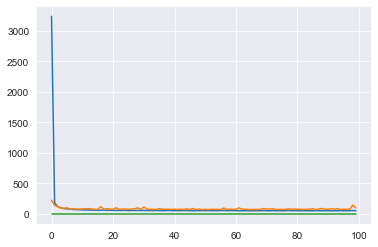

In [178]:
num_epochs = len(dnn_history.val_loss_hist)
xc         = range(num_epochs)
plt.figure()
plt.plot(xc, dnn_history.train_loss_hist, label='train')
plt.plot(xc, dnn_history.val_loss_hist, label='val')
plt.plot(xc, dnn_history.lr_hist, label='lr')
plt.show()

In [179]:
ap=pd.DataFrame(averaged_pred)
ap.to_csv('ap2.csv',index=False)

In [180]:
CBoost_new.fit(train,y_train)
print(CBoost_new.predict(test))
model_xgb.fit(train,y_train)
print(model_xgb.predict(test))
ENet.fit(train,y_train)
print(ENet.predict(test))
GBoost.fit(train,y_train)
print(GBoost.predict(test))
KRR.fit(train,y_train)
print(KRR.predict(test))
BR.fit(train,y_train)
print(BR.predict(test))

[171.7954321  186.02346719 198.74100779 ... 189.47787095 166.05022499
 210.05334375]
[174.85138 190.59576 199.1602  ... 193.56343 164.2724  210.65514]
[168.84976557 189.27869476 196.55206224 ... 191.27076607 167.95357569
 209.35854907]
[169.58067377 186.24904808 200.38754593 ... 183.95693331 165.53534164
 206.89287428]
[165.8881995  200.85338517 195.63531714 ... 187.1719474  159.2178427
 209.80651536]
[167.87069723 186.9372057  196.61554604 ... 192.291501   166.58548666
 209.14987959]


In [181]:
averaged_models.get_params()

{'estimators': [('CBoost', <catboost.core.CatBoostRegressor at 0x2064af00d48>),
  ('xgb',
   XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05,
                min_child_weight=1.7817, n_estimators=2200, random_state=35,
                reg_alpha=0.464, reg_lambda=0.8571, silent=1, subsample=0.5213)),
  ('ENet',
   Pipeline(steps=[('standardscaler', StandardScaler()),
                   ('elasticnet',
                    ElasticNet(alpha=0.01, l1_ratio=0.9, max_iter=350,
                               random_state=3, selection='random', tol=0.01))])),
  ('gboost',
   GradientBoostingRegressor(learning_rate=0.05, loss='huber', max_depth=4,
                             max_features='sqrt', min_samples_leaf=15,
                             min_samples_split=10, n_estimators=3000,
                             random_state=5)),
  ('krr',
   KernelRidge(alpha=2.2, coef0=0.5, degree=5, gamma=0.001, kernel='polynomial')),
  ('br', BayesianRidge())],
 'n_jobs': None,
 'verb

Compare different predictions to each other:

https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_regressor.html

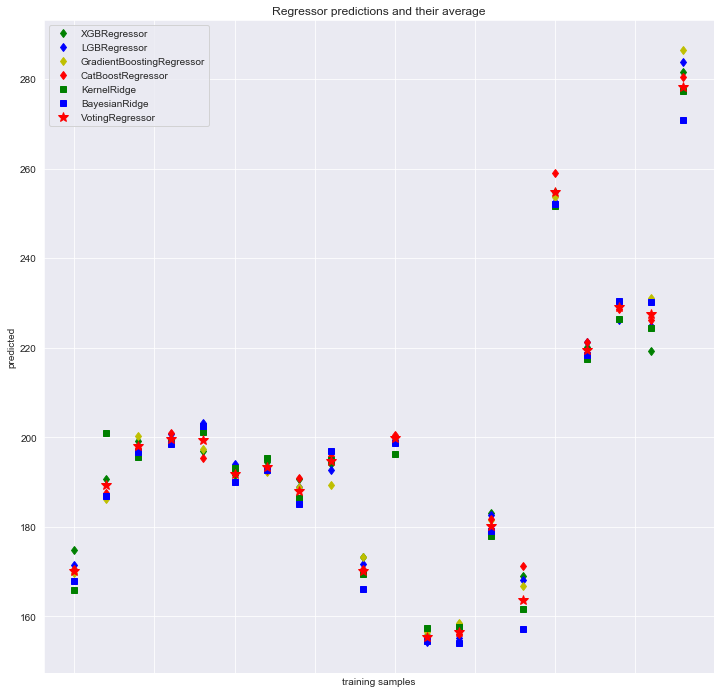

In [182]:
if (use_voting_regressor == 1):
    model_xgb.fit(train, y_train)
    model_lgb.fit(train, y_train)
    GBoost.fit(train, y_train)
    CBoost.fit(train, y_train)
    KRR.fit(train, y_train)
    BR.fit(train, y_train)
    averaged_models_temp = VotingRegressor(estimators=estimator_list, weights=weight_list) 
    averaged_models_temp.fit(train, y_train)

    xt = test[:20]

    pred1 = model_xgb.predict(xt)
    pred2 = model_lgb.predict(xt)
    pred3 = GBoost.predict(xt)
    pred4 = CBoost.predict(xt)
    pred5 = KRR.predict(xt)
    pred6 = BR.predict(xt)
    pred7 = averaged_models_temp.predict(xt)
    plt.figure(figsize=(12,12))
    plt.plot(pred1, 'gd', label='XGBRegressor')
    plt.plot(pred2, 'bd', label='LGBRegressor')
    plt.plot(pred3, 'yd', label='GradientBoostingRegressor')
    plt.plot(pred4, 'rd', label='CatBoostRegressor')
    plt.plot(pred5, 'gs', label='KernelRidge')
    plt.plot(pred6, 'bs', label='BayesianRidge')
    plt.plot(pred7, 'r*', ms=10, label='VotingRegressor')

    plt.tick_params(axis='x', which='both', bottom=False, top=False,
                    labelbottom=False)
    plt.ylabel('predicted')
    plt.xlabel('training samples')
    plt.legend(loc="best")
    plt.title('Regressor predictions and their average')

    plt.show()


Example plot

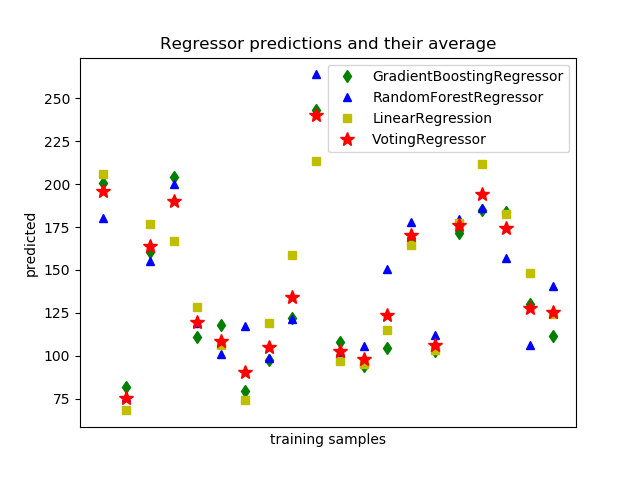

###Less simple Stacking : Adding a Meta-model

In this approach, we add a meta-model on averaged base models and use the out-of-folds predictions of these base models to train our meta-model. 

The procedure, for the training part, may be described as follows:


1. Split the total training set into two disjoint sets (here **train** and .**holdout** )

2. Train several base models on the first part (**train**)

3. Test these base models on the second part (**holdout**)

4. Use the predictions from 3)  (called  out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs  to train a higher level learner called **meta-model**.

The first three steps are done iteratively . If we take for example a 5-fold stacking , we first split the training data into 5 folds. Then we will do 5 iterations. In each iteration,  we train every base model on 4 folds and predict on the remaining fold (holdout fold). 

So, we will be sure, after 5 iterations , that the entire data is used to get out-of-folds predictions that we will then use as 
new feature to train our meta-model in the step 4.

For the prediction part , We average the predictions of  all base models on the test data  and used them as **meta-features**  on which, the final prediction is done with the meta-model.


Another way to combine multiple models:

The function cross_val_predict is appropriate for:
Visualization of predictions obtained from different models.

Model blending: When predictions of one supervised estimator are used to train another estimator in ensemble methods.

![Faron](http://i.imgur.com/QBuDOjs.jpg)

(Image source [Faron](https://www.kaggle.com/getting-started/18153#post103381))

The only difference between M6 and M1-M5 is, that M6 is trained on the entire original training data, whereas M1-M5 are trained only on 4 out of 5 folds.

With M1-M5 you can build valid out-of-fold predictions for the training set (the orange ones) to form a single "new feature" for the 2nd layer (not possible with M6). You can also predict the test set with M1-M5 to get 5 sets of test set predictions .. but you only need one set of test set predictions for the corresponding feature to the orange out-of-fold train set predictions.

Hence, you reduce those 5 sets to 1 by averaging. That's the first variant, A. Alternatively, you train M6 and use its test set predictions as the feature for the 2nd layer (instead of the average of the test set predictions from M1-M5).

On this gif, the base models are algorithms 0, 1, 2 and the meta-model is algorithm 3. The entire training dataset is 
A+B (target variable y known) that we can split into train part (A) and holdout part (B). And the test dataset is C. 

B1 (which is the prediction from the holdout part)  is the new feature used to train the meta-model 3 and C1 (which
is the prediction  from the test dataset) is the meta-feature on which the final prediction is done. 

**Stacking averaged Models Class**

In [183]:
# Variant B
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=10, shuffle=True): # increasing the n_folds value should give a more accurate prediction, averaged over n_fold iterations
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        self.shuffle = shuffle

    # Fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156) # was 156
        print("shuffle=" + str(self.shuffle))
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models): # for each model passed in
            with MyTimer():
                model_name = model.__class__.__name__
                model_details = str(model)
                print('model_name:', model_name)
                print('model_details:', model_details)
                for train_index, holdout_index in kfold.split(X, y): # create train,holdout splits for the number of folds
                    instance = clone(model)
                    self.base_models_[i].append(instance)
                    #if ("KerasRegressor" in model_name):
                    if ("KerasRegressor" in model_name):
                        hist = instance.fit(X[train_index], y[train_index], shuffle=self.shuffle, validation_split=0.3, callbacks=callbacks_list) # fit the model for this fold
                    elif ("keras" in model_details):
                        instance.fit(X[train_index], y[train_index], dnn__shuffle=True, dnn__validation_split=0.3, dnn__callbacks=callbacks_list)
                    else:
                        instance.fit(X[train_index], y[train_index]) # fit the model for this fold
                    y_pred = instance.predict(X[holdout_index]) # predict values for this fold
                    out_of_fold_predictions[holdout_index, i] = y_pred # add predictions for this model and fold (random rows)
                    #print('out_of_fold_predictions', out_of_fold_predictions)
        # Now train the cloned  meta-model using the out-of-fold predictions as new and only feature
        print("out_of_fold_predictions", out_of_fold_predictions)
        
        meta_model_name = self.meta_model_.__class__.__name__
        print("meta_model_name:", meta_model_name)
        if ("KerasRegressor" in meta_model_name):
            self.meta_model_.fit(out_of_fold_predictions, y, shuffle=self.shuffle, validation_split=0.3, callbacks=callbacks_list) # need to see out_of_fold_predictions feature set
        elif ("keras" in str(self.meta_model_)):
            self.meta_model_.fit(out_of_fold_predictions, y, dnn__shuffle=True, dnn__validation_split=0.3, dnn__callbacks=callbacks_list) # need to see out_of_fold_predictions feature set
        else:
            self.meta_model_.fit(out_of_fold_predictions, y) # need to see out_of_fold_predictions feature set

        #self.meta_model_.fit(out_of_fold_predictions, y) # need to see out_of_fold_predictions feature set
        return self 
    
    # Calculate the predictions of all base models on the test data and use the averaged predictions as 
    # meta-features for the final prediction which is calculated by the meta-model
    
    # add MinMax
    def predict(self, X):
        # column_stack() function is used to stack 1-D arrays as columns into a 2-D array.
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

Diagram of out of fold cross validated stacked models


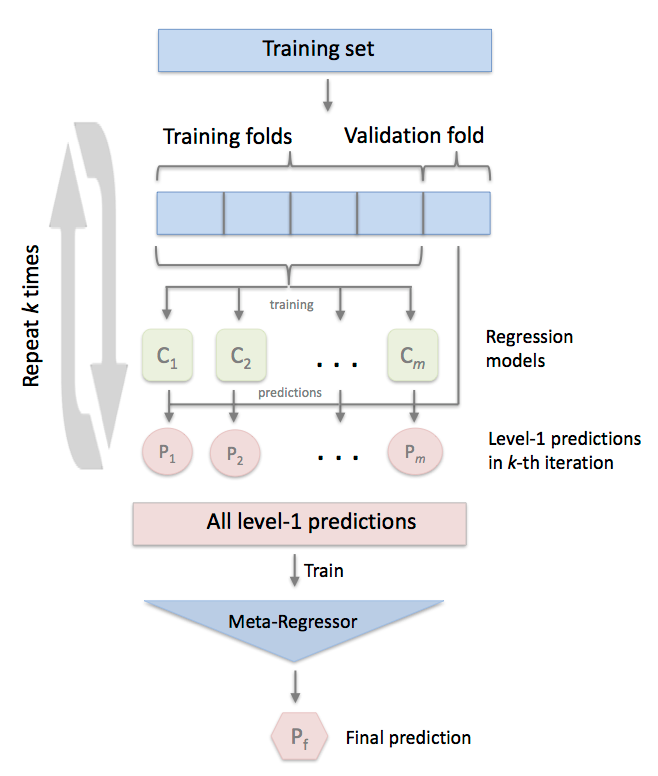

Reference: http://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor/

**Stacking Averaged models Score**

In [184]:
# can't get sgd to give decent results, only adam works as a metamodel
# dnn_meta = KerasRegressor(build_fn=baseline_model(dim=5, opt_sel="sgd", learning_rate=0.000005, neurons=32, decay=0.000001, momentum=0.9), epochs=num_epochs, batch_size=8, verbose=1)
# dnn_meta = KerasRegressor(build_fn=baseline_model(dim=5, opt_sel='adam', learning_rate = 0.001, neurons = 8, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False), epochs=1000, batch_size=2, verbose=1)


In [185]:
# ~ 10 minutes to run
# verify: this class uses out of fold predictions in the stacking method, so rows in dataset are split up betwen models and each row in dataset is only used once
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, KRR, GBoost, model_xgb, lr_poly),#, dnn),
                                                 meta_model = R_new, shuffle=True) 

if (compare_models == 1):
    with MyTimer():
        if (competition == 'SR'):
            score = mae_cv(stacked_averaged_models)
            print("Stacking Averaged models score mean and std: {:.4f} ({:.4f})".format(score.mean(), score.std()))
        else:
            score = rmsle_cv(stacked_averaged_models)
            print("Stacking Averaged models score mean and std: {:.4f} ({:.4f})".format(score.mean(), score.std()))

In [186]:
#stacked_averaged_models.fit(train.values, y_train)
#stacked_averaged_models # this doesn't work when using CBoost on my desktop

use different function to calculate ensembles

In [187]:
use_Regressor = 0 # default - best score
#use_Regressor = 1 # StackingRegressor - worst score
#use_Regressor = 2 # StackingCVRegressor - middle score

if (use_Regressor == 1):
    from sklearn.ensemble import StackingRegressor
    from sklearn.linear_model import RidgeCV, LassoCV
    from sklearn.linear_model import ElasticNetCV

    use_cv = 1
    k = {'alpha': 2.2, 'coef0': 0.5, 'degree': 5, 'gamma': 0.001, 'kernel': 'polynomial'}
    if (use_cv == 1):
        e = {'fit_intercept': True, 'l1_ratio': 0.85, 'max_iter': 100, 'normalize': False, 'selection': 'random', 'cv': 10} # 'alpha': 0.05,
        r = {'fit_intercept': True, 'normalize': False, 'cv': None, 'gcv_mode': 'auto'} # cv value has no effect
        estimators = [('enet', make_pipeline(StandardScaler(), ElasticNetCV(**e, random_state=3))),
                      ('gboost', GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10,  loss='huber', random_state=5)),
                      ('krr', KernelRidge(**k)),
                      ('br', BayesianRidge())]
        reg = StackingRegressor(
            estimators=estimators,
            final_estimator=RidgeCV(**r))
    else:
        e = {'alpha': 0.05, 'fit_intercept': True, 'l1_ratio': 0.85, 'max_iter': 100, 'normalize': False, 'selection': 'random', 'tol': 0.05}
        r = {'alpha': 8, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'solver': 'auto', 'tol': 0.05, 'cv': None, 'gcv_mode': 'auto', 'random_state': 99} #  
        estimators = [('enet', make_pipeline(StandardScaler(), ElasticNet(**e, random_state=3))),
                      ('gboost', GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10,  loss='huber', random_state=5)),
                      ('krr', KernelRidge(**k)),
                      ('br', BayesianRidge())]
        reg = StackingRegressor(
            estimators=estimators,
            final_estimator=Ridge(**r))

    reg.fit(train, y_train)
    stacked_pred = inv_boxcox1p(reg.predict(test), lam_l)
    #reg.transform(inv_boxcox1p(stacked_averaged_models_temp, lam_l))
    print(stacked_pred)
    print(reg)

multilayer stacking

In [188]:
a='''
# Note Multiple stacking layers can be achieved by assigning final_estimator to a StackingClassifier or StackingRegressor:

final_layer = StackingRegressor(
    estimators=[('rf', RandomForestRegressor(random_state=42)),
                ('gbrt', GradientBoostingRegressor(random_state=42))],
    final_estimator=RidgeCV()
    )
multi_layer_regressor = StackingRegressor(
    estimators=[('ridge', RidgeCV()),
                ('lasso', LassoCV(random_state=42)),
                ('svr', SVR(C=1, gamma=1e-6, kernel='rbf'))],
    final_estimator=final_layer
)
multi_layer_regressor.fit(X_train, y_train)'''

Use another Stacking function, from mlxtend

In [189]:
if (use_Regressor == 2):
    from mlxtend.regressor import StackingCVRegressor
    from sklearn.linear_model import RidgeCV, LassoCV
    from sklearn.linear_model import ElasticNetCV

    use_cv = 0
    k = {'alpha': 2.2, 'coef0': 0.5, 'degree': 5, 'gamma': 0.001, 'kernel': 'polynomial'}
    if (use_cv == 1):
        e = {'fit_intercept': True, 'l1_ratio': 0.85, 'max_iter': 100, 'normalize': False, 'selection': 'random', 'cv': 10} # 'alpha': 0.05,
        r = {'fit_intercept': True, 'normalize': False, 'cv': None, 'gcv_mode': 'auto'} # cv value has no effect
        enet = make_pipeline(StandardScaler(), ElasticNetCV(**e, random_state=3))
        gboost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10,  loss='huber', random_state=5)
        krr = KernelRidge(**k)
        br = BayesianRidge()
        r = RidgeCV(**r)
        reg = StackingCVRegressor(
            regressors=(enet, gboost, krr, br),
            meta_regressor=r)
    else:
        e = {'alpha': 0.05, 'fit_intercept': True, 'l1_ratio': 0.85, 'max_iter': 100, 'normalize': False, 'selection': 'random'}
        r = {'alpha': 8, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'solver': 'auto', 'tol': 0.001, 'random_state': 99} #  
        enet = make_pipeline(StandardScaler(), ElasticNet(**e, random_state=3))
        gboost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10,  loss='huber', random_state=5)
        krr = KernelRidge(**k)
        br = BayesianRidge()
        r = Ridge(**r)
        reg = StackingCVRegressor(
            regressors=(enet, gboost, krr, br),
            meta_regressor=r)

    reg.fit(train, y_train)
    stacked_pred = inv_boxcox1p(reg.predict(test), lam_l)
    print(stacked_pred)
    print(reg)
    
    print('5-fold cross validation scores:\n')
    for clf, label in zip([enet, gboost, krr, br], ['enet', 'gboost', 
                                                'krr', 'br',
                                                'StackingCVRegressor']):
        scores = cross_val_score(clf, train, y_train, cv=5, scoring='neg_mean_squared_error')
        print("Neg. MSE Score: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
        
        #scores = cross_val_score(clf, train, y_train, cv=5)
        #print("R^2 Score: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

We get again a better score by adding a meta learner

## Ensembling StackedRegressor, XGBoost and LightGBM

We add **XGBoost and LightGBM** to the **StackedRegressor** defined previously. 

###Final Training and Prediction

**StackedRegressor:**

add the previous averaged models here

In [190]:
averaged_models.fit(train, y_train)
averaged_train_pred = averaged_models.predict(train)
if (use_voting_regressor == 0):
    averaged_pred = inv_boxcox1p(averaged_models.predict(test), lam_l)

if (competition == 'SR'):
    print(mae(y_train, averaged_train_pred))
else:
    print(rmsle(y_train, averaged_train_pred))

2.5718257664198556


In [191]:
#pre adjustment
averaged_pred

array([123416.615327  , 167055.83903917, 189175.65760623, ...,
       167499.24407157, 113502.79159418, 221643.50824775])

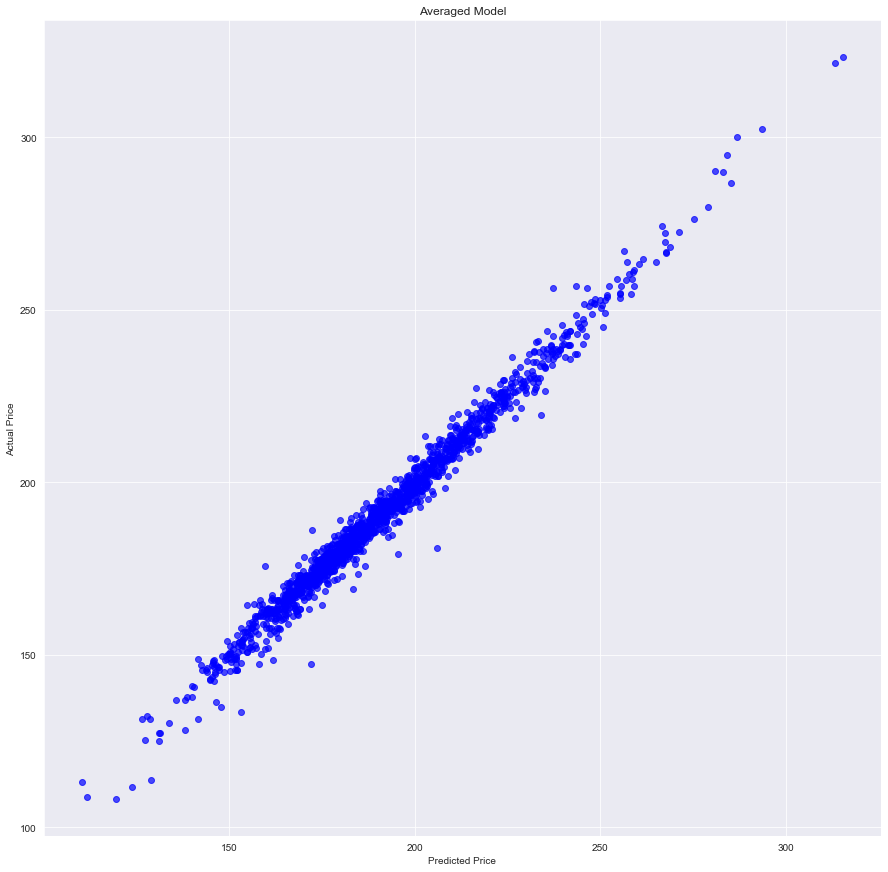

In [192]:
plt.figure(figsize=(15,15))
plt.scatter(averaged_train_pred, y_train, alpha=.7,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Averaged Model')
plt.show()

Check predictions, are they on same scale as SalePrice in Train dataset?

In [193]:
averaged_models.predict(test)

array([170.09022567, 189.42300461, 197.97609842, ..., 189.60147435,
       165.09501379, 209.42423456])

In [194]:
averaged_train_pred

array([204.59704434, 194.58608408, 208.29694497, ..., 222.93155058,
       177.94633277, 182.56240296])

In [195]:
#post adjustment
averaged_pred

array([123416.615327  , 167055.83903917, 189175.65760623, ...,
       167499.24407157, 113502.79159418, 221643.50824775])

In [196]:
y_train.shape

(1458,)

In [197]:
if (method == "stacked"):
    with MyTimer():
        # StackingAveragedModels runs 10 kfolds iterations
        stacked_averaged_models.fit(train.values, y_train)
    with MyTimer():
        stacked_train_pred = stacked_averaged_models.predict(train.values)
    if (use_Regressor == 0):
        stacked_pred = inv_boxcox1p(stacked_averaged_models.predict(test.values), lam_l)

    print(mae(y_train, stacked_train_pred))
    print(rmsle(y_train, stacked_train_pred))

    print(stacked_train_pred)
    print(stacked_pred)

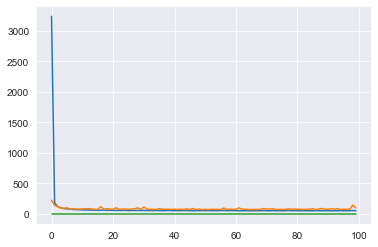

In [199]:
num_epochs = len(dnn_history.val_loss_hist)
xc         = range(num_epochs)
plt.figure()
plt.plot(xc, dnn_history.train_loss_hist, label='train')
plt.plot(xc, dnn_history.val_loss_hist, label='val')
plt.plot(xc, dnn_history.lr_hist, label='lr')
plt.show()

In [200]:
def fit_pred(train, y_train, test, model):
    #model.fit(train, y_train)
    
    model_name = model.__class__.__name__
    print('model_name:', model_name)
    if ("XGBRegressor" in model_name):
        model.fit(train, y_train) # fit the model for this fold
    elif ("KerasRegressor" in model_name):
        model.fit(train, y_train, shuffle=False, validation_split=0.3, callbacks=callbacks_list) # fit the model for this fold
    elif ("keras" in str(model)):
        model.fit(train, y_train, dnn__shuffle=True, dnn__validation_split=0.3, dnn__callbacks=callbacks_list) # fit the model for this fold
    else:
        print("train", train)
        print("y_train", y_train)
        model.fit(train, y_train) # fit the model for this fold

    model_train_pred = model.predict(train)
    model_pred = inv_boxcox1p(model.predict(test), lam_l)
    return(model_train_pred, model_pred)
    
#models      = [dnn, dnn_pipe, CBoost, lasso, lasso_new, ENet, KRR, GBoost, GBoost_new, model_xgb, model_xgb_new, BR, ET, ET_new, RF, RF_new, AB, SVR, DT, KN, B] # model_lgb,
#model_names = ['dnn','dnn_pipe','CBoost', 'lasso', 'lasso_new', 'ENet', 'KRR', 'GBoost', 'GBoost_new', 'model_xgb', 'model_xgb_new', 'BR', 'ET', 'ET_new', 'RF', 'RF_new', 'AB', 'SVR', 'DT', 'KN', 'B']
models      = [dnn, dnn_pipe, CBoost, lasso, lasso_new, ENet, KRR, GBoost, GBoost_new, model_xgb, BR, ET, ET_new, RF, RF_new, AB, KN, B] # model_lgb,
model_names = ['dnn','dnn_pipe','CBoost', 'lasso', 'lasso_new', 'ENet', 'KRR', 'GBoost', 'GBoost_new', 'model_xgb', 'BR', 'ET', 'ET_new', 'RF', 'RF_new', 'AB', 'KN', 'B']
df_train_pred = pd.DataFrame()
df_test_pred = pd.DataFrame()
with MyTimer():
    for i in range(0,len(models)):
        #print("models[i]", models[i])
        #print("model_names[i]:", model_names[i])
        mn = model_names[i]+"_pred"
        train_pred, test_pred = fit_pred(train, y_train, test, models[i])
        df_train_pred[mn] = train_pred
        df_test_pred[mn] = test_pred
        #print(mn, test_pred)    
  

model_name: KerasRegressor
Train on 1020 samples, validate on 438 samples
Epoch 1/100
epoch=0 lr=0.004999999888241291 lrate=0.004999999888241291
1020/1020 [==============================] - 2s 2ms/step - loss: 2284.8921 - val_loss: 192.0154
Epoch 2/100
epoch=1 lr=0.004999999888241291 lrate=0.004999999888241291
1020/1020 [==============================] - 2s 2ms/step - loss: 173.9702 - val_loss: 130.5395
Epoch 3/100
epoch=2 lr=0.004999999888241291 lrate=0.004999999888241291
1020/1020 [==============================] - 2s 2ms/step - loss: 134.3619 - val_loss: 107.6365
Epoch 4/100
epoch=3 lr=0.004999999888241291 lrate=0.004999999888241291
1020/1020 [==============================] - 2s 2ms/step - loss: 114.9636 - val_loss: 97.7354
Epoch 5/100
epoch=4 lr=0.004999999888241291 lrate=0.004999999888241291
1020/1020 [==============================] - 2s 2ms/step - loss: 104.4563 - val_loss: 92.9362
Epoch 6/100
epoch=5 lr=0.004999999888241291 lrate=0.004999999888241291
1020/1020 [===============

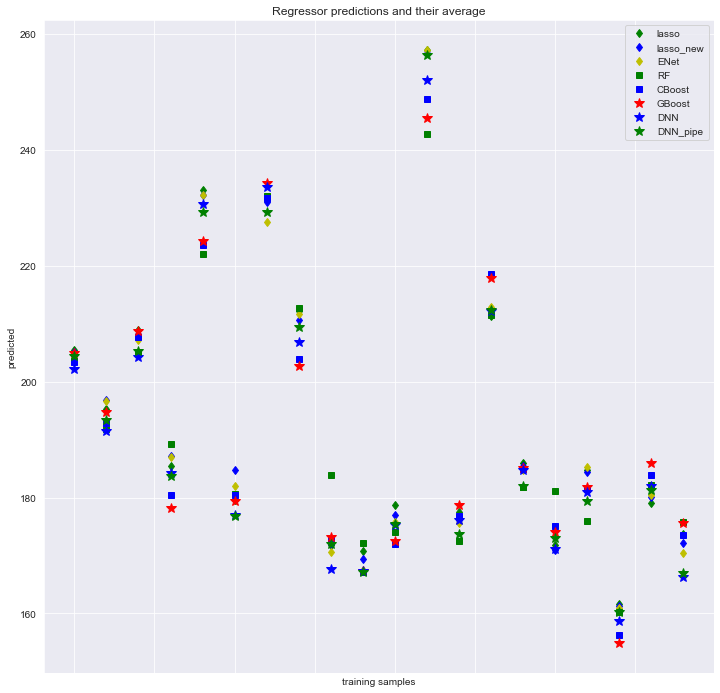

In [201]:
xt = df_train_pred[:20]

pred1 = xt['lasso_pred']
pred2 = xt['lasso_new_pred']
pred3 = xt['ENet_pred']
pred4 = xt['RF_pred']
pred5 = xt['CBoost_pred']
pred6 = xt['GBoost_pred']
pred7 = xt['dnn_pred']
pred8 = xt['dnn_pipe_pred']
plt.figure(figsize=(12,12))
plt.plot(pred1, 'gd', label='lasso')
plt.plot(pred2, 'bd', label='lasso_new')
plt.plot(pred3, 'yd', label='ENet')
plt.plot(pred4, 'gs', label='RF')
plt.plot(pred5, 'bs', label='CBoost')
plt.plot(pred6, 'r*', ms=10, label='GBoost')
plt.plot(pred7, 'b*', ms=10, label='DNN')
plt.plot(pred8, 'g*', ms=10, label='DNN_pipe')

plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Regressor predictions and their average')

plt.show()

Create predictions for all models for testing

**XGBoost:**

In [202]:
# values are not normalized
#train[train.columns].mean().head()

In [203]:
# are train and test normalized? between -1 and 1
replace_xgb = 0 # new optimized model is worse, was overfit
if (replace_xgb == 1):
    model_xgb_new.fit(train, y_train)
    xgb_train_pred = model_xgb_new.predict(train)
    xgb_pred = inv_boxcox1p(model_xgb_new.predict(test), lam_l)
else:
    model_xgb.fit(train, y_train)
    xgb_train_pred = model_xgb.predict(train)
    xgb_pred = inv_boxcox1p(model_xgb.predict(test), lam_l)

if (competition == 'SR'):
    print(mae(y_train, xgb_train_pred))
else:
    print(rmsle(y_train, xgb_train_pred))

1.0144968917638193


**LightGBM:**

In [204]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = inv_boxcox1p(model_lgb.predict(test), lam_l)

if (competition == 'SR'):
    print(mae(y_train, lgb_train_pred))
else:
    print(rmsle(y_train, lgb_train_pred))

3.4257991540907495


In [205]:
if (tuning_lgb == 1):
    model_lgb_op.fit(train, y_train)
    lgb_train_pred_op = model_lgb_op.predict(train)
    lgb_pred_op = inv_boxcox1p(model_lgb_op.predict(test), lam_l)

    if (competition == 'SR'):
        print(mae(y_train, lgb_train_pred_op))
    else:
        print(rmsle(y_train, lgb_train_pred_op))

In [206]:
# compare values with optimization
print(lgb_train_pred)
if (tuning_lgb == 1):
    print(lgb_train_pred_op)
print(lgb_pred)
if (tuning_lgb == 1):
    print(lgb_pred_op)

[203.67611878 191.8459941  206.83074    ... 222.94048261 177.72033626
 186.0114241 ]
[126284.67719    160506.79107483 186366.88915223 ... 164530.92194047
 116912.7893064  228355.88057616]


In [207]:
with open('CBoost_new.pkl', 'rb') as fid:
    CBoost_new = pickle.load(fid)
    
CBoost_new.fit
cb_pred = inv_boxcox1p(CBoost_new.predict(test), lam_l)
cb_train_pred = inv_boxcox1p(CBoost_new.predict(train), lam_l)
print(cb_pred)

[126925.27514279 158754.86353238 191241.55515941 ... 167192.07220862
 115356.9523892  223525.4126614 ]


In [208]:
ENet.fit(train,y_train)
KRR.fit(train,y_train)
GBoost.fit(train,y_train)
lr_poly.fit(train,y_train)
model_xgb.fit(train,y_train)
enet_pred = inv_boxcox1p(ENet.predict(test), lam_l)
krr_pred = inv_boxcox1p(KRR.predict(test), lam_l)
gboost_pred = inv_boxcox1p(GBoost.predict(test), lam_l)
lr_pred = inv_boxcox1p(lr_poly.predict(test), lam_l)

br_pred = inv_boxcox1p(BR.predict(test), lam_l)
br_train_pred = inv_boxcox1p(BR.predict(train), lam_l)
# all models being used in final model
#print(cb_pred)
#print(xgb_pred)
#print(lgb_pred)
print(br_pred)
print(enet_pred) 
print(krr_pred)
print(gboost_pred)
print(lr_pred) # changes each time
print(dnn_pred)

[118944.95752953 160959.03559759 185536.97749908 ... 174275.49042156
 116404.50122015 220826.04440337]
[120904.25589599 166697.86211584 185368.31604193 ... 171683.65818314
 119110.00720558 221447.61400156]
[115041.06859993 197022.77013593 182943.84105358 ... 161528.48566495
 102519.69252927 222785.82227889]
[122380.5317529  159297.18674045 195738.22135333 ... 153842.43708988
 114355.08606854 214175.37785181]
[117726.36046861 194422.85047054 176183.6171819  ... 167428.22375181
  94103.99994643 226170.80781945]
[125391.04 165849.36 189048.14 ... 167127.88 117711.76 211976.8 ]


In [209]:
if (method == 'stacked'):
    testing_ratio = 0
    if (testing_ratio == 1):
        stkr = 1.00
        xgbr = 0.00
        lgbr = 0.00
        cbr  = 0.00
        brr  = 0.00
    else:
        stkr = 0.70
        xgbr = 0.10 # .10
        lgbr = 0.00
        cbr  = 0.20 # .20
        brr  = 0.00 # 0

    '''RMSE on the entire Train data when averaging'''

    print('RMSLE score on train data:')
    print(mae(y_train,stacked_train_pred*stkr+ xgb_train_pred*xgbr + lgb_train_pred*lgbr + cb_train_pred*cbr + br_train_pred*brr ))
    print(rmsle(y_train,stacked_train_pred*stkr + xgb_train_pred*xgbr + lgb_train_pred*lgbr + cb_train_pred*cbr + br_train_pred*brr ))

Seems that RMSLE does not correlate to a good score

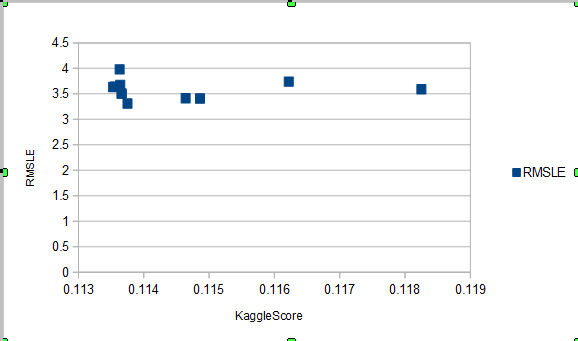

Add CBoost model from Ensemble notebook

**Ensemble prediction:**

when deciding which models to include in an ensemble:  
    fewer are better  
    more diverse are better  

In [210]:
print(method)
if (method == 'stacked'):
    ensemble = stacked_pred*stkr + xgb_pred*xgbr + lgb_pred*lgbr + cb_pred*cbr + br_pred*brr  # if using averaged_pred, need to add averaged_pred here
else:
    ensemble = averaged_pred


ensemble


In [211]:
print(xgb_pred)
print(lgb_pred)
print(cb_pred)
print(br_pred)
print(averaged_pred)
print(ensemble)

[133374.23 169983.58 192379.95 ... 177540.6  111921.65 225335.33]
[126284.67719    160506.79107483 186366.88915223 ... 164530.92194047
 116912.7893064  228355.88057616]
[126925.27514279 158754.86353238 191241.55515941 ... 167192.07220862
 115356.9523892  223525.4126614 ]
[118944.95752953 160959.03559759 185536.97749908 ... 174275.49042156
 116404.50122015 220826.04440337]
[123416.615327   167055.83903917 189175.65760623 ... 167499.24407157
 113502.79159418 221643.50824775]
[123416.615327   167055.83903917 189175.65760623 ... 167499.24407157
 113502.79159418 221643.50824775]


In [212]:
if (method == 'stacked'):
    print(y_train,stacked_train_pred * stkr + xgb_train_pred * xgbr + lgb_train_pred * lgbr) # if using averaged_pred, need to add averaged_pred here
    print(y_train,stacked_train_pred)

Plot prediction vs actual for train for one last verification of the model

In [213]:
sub_train = pd.DataFrame()
sub_train['Id'] = train_ID
if (method == 'stacked'):
    sub_train['SalePrice'] = inv_boxcox1p(stacked_train_pred, lam_l)
else:
    sub_train['SalePrice'] = inv_boxcox1p(averaged_train_pred, lam_l)

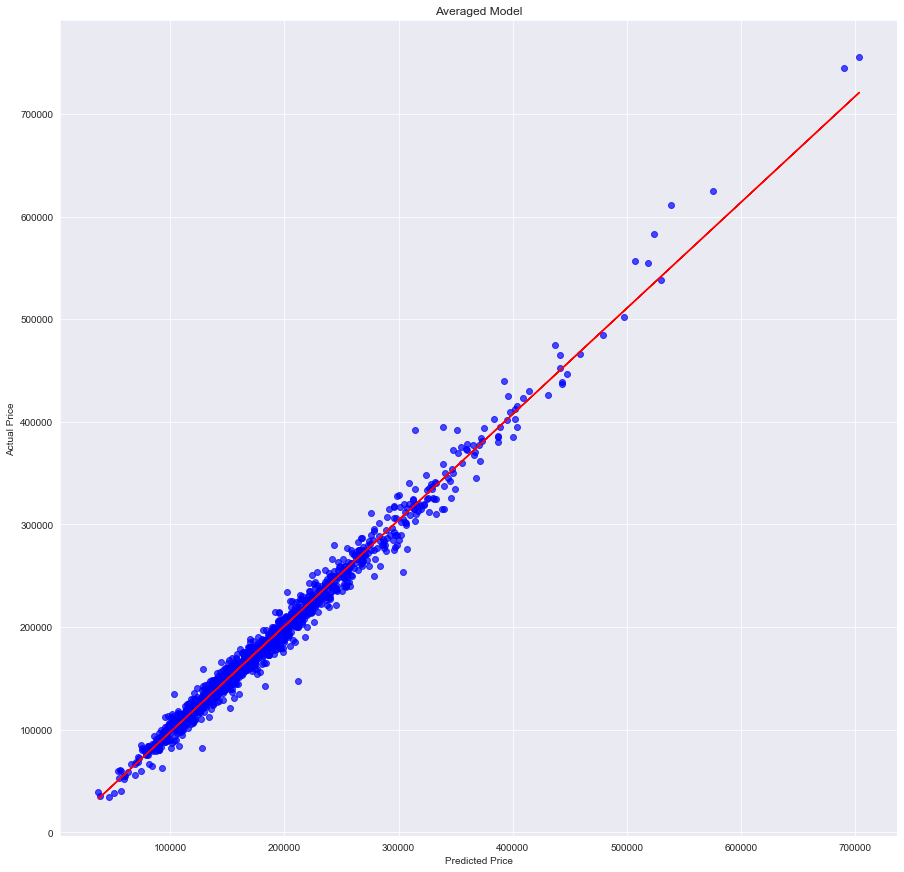

In [214]:
Predicted = sub_train['SalePrice']
Actual = inv_boxcox1p(y_train, lam_l)
plt.figure(figsize=(15,15))
plt.scatter(sub_train['SalePrice'], Actual, alpha=.7,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Averaged Model')

m, b = np.polyfit(Predicted, Actual, 1)
#m = slope, b=intercept
plt.plot(Predicted, m*Predicted+b,c='red')
plt.show()

At the high end, SP > 520000, the model predicts too low for 7/8 points

Get Pre-adjustment score for comparison

In [215]:
# Pre-adjustment score
print("mae for boxcox(SalePrice)",mae(y_train, sub_train['SalePrice']))
print("mse for boxcox(SalePrice)",rmsle(y_train, sub_train['SalePrice']))
print("mae for SalePrice",mae(Actual, Predicted))
print("mse for SalePrice",rmsle(Actual, Predicted))

mae for boxcox(SalePrice) 180284.9466532964
mse for boxcox(SalePrice) 195815.0011326552
mae for SalePrice 6693.656933342132
mse for SalePrice 10011.257436582102


Find best cutoff and adjustment at high end

In [216]:
def AdjustHigh(sub_train, y_train):
    AdjustedScores = []
    for i in np.arange(.994, 1.000, 0.01):
        for j in np.arange(1.00, 1.10, .01):

            q1 = sub_train['SalePrice'].quantile(0.0025)
            q2 = sub_train['SalePrice'].quantile(0.0045)
            q3 = sub_train['SalePrice'].quantile(i)

            #Verify the cutoffs for the adjustment
            # adjust at low end
            #sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if x > q1 else x*0.79)
            #sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if x > q2 else x*0.89)

            # adjust at high end
            sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if x < q3 else x*j)

            Predicted = sub_train['SalePrice2']
            Actual = inv_boxcox1p(y_train, lam_l)

            # Pre-adjustment score
            #print("mae for boxcox(SalePrice)",mae(y_train, sub_train['SalePrice2']))
            #print("mse for boxcox(SalePrice)",rmsle(y_train, sub_train['SalePrice2']))
            #print("mae for SalePrice",mae(Actual, Predicted))
            #print("mse for SalePrice",rmsle(Actual, Predicted))

            AdjustedScores.append([i, j, mae(y_train, boxcox1p(sub_train['SalePrice2'], lam_l)), rmsle(y_train, boxcox1p(sub_train['SalePrice2'], lam_l)), mae(Actual, Predicted), rmsle(Actual, Predicted)])
    print(q1,q2,q3)
    df_adj = pd.DataFrame(AdjustedScores, columns=["QUANT","COEF","MAE_BC","RMSE_BC","MAE_SP","RMSE_SP"])
    print('quantiles vs coefficients')
    df_adj.sort_values(by=['RMSE_BC'])
    print(df_adj)
    df2 = df_adj.sort_values(by=['RMSE_BC']).reset_index()
    coef_hi = df2.COEF[0]
    quant_hi = df2.QUANT[0]
    return (coef_hi, quant_hi)

ch, qh = AdjustHigh(sub_train, y_train)

52913.48455396922 56156.47028976659 483711.9686962493
quantiles vs coefficients
    QUANT  COEF  MAE_BC  RMSE_BC   MAE_SP   RMSE_SP
0   0.994 1.000   2.572    3.595 6693.657 10011.257
1   0.994 1.010   2.566    3.582 6660.084  9867.923
2   0.994 1.020   2.562    3.572 6635.771  9743.076
3   0.994 1.030   2.558    3.563 6614.986  9637.437
4   0.994 1.040   2.554    3.556 6594.200  9551.641
5   0.994 1.050   2.551    3.551 6573.415  9486.227
6   0.994 1.060   2.547    3.547 6552.630  9441.620
7   0.994 1.070   2.544    3.545 6532.252  9418.114
8   0.994 1.080   2.543    3.545 6526.843  9415.867
9   0.994 1.090   2.544    3.547 6535.391  9434.896
10  0.994 1.100   2.547    3.550 6550.263  9475.071


In [217]:
print('ch',ch)
print('qh',qh)

ch 1.08
qh 0.994


In [218]:
q1 = sub_train['SalePrice'].quantile(0.0015)
q2 = sub_train['SalePrice'].quantile(0.01)
q3 = sub_train['SalePrice'].quantile(qh)

#Verify the cutoffs for the adjustment
print(q1,q2,q3)
# adjust at low end
#sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if x > q1 else x*0.79)
#sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if x > q2 else x*0.89)

# adjust at high end
sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if x < q3 else x*ch)

46923.2575278568 68962.57709929664 483711.9686962493


Show adjustments

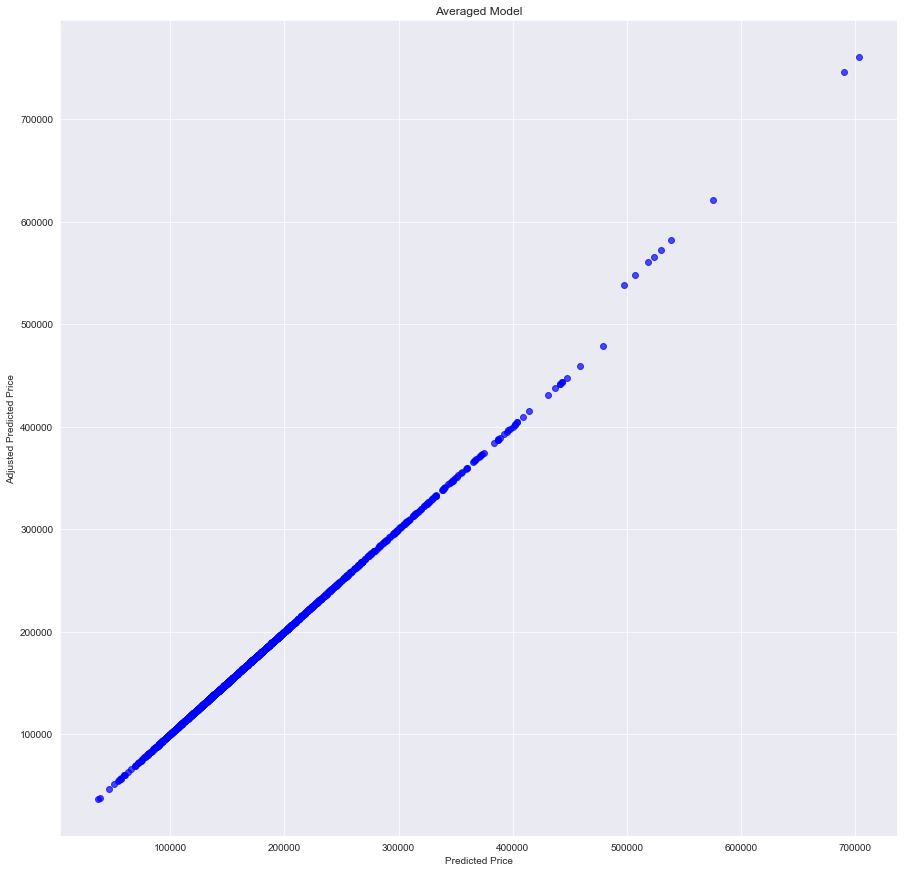

In [219]:
plt.figure(figsize=(15,15))
plt.scatter(sub_train['SalePrice'], sub_train['SalePrice2'], alpha=.7,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Adjusted Predicted Price')
plt.title('Averaged Model')
plt.show()

We have bumped up the predictions and they look correct so far, now to verify on the previous chart

In [220]:
sub_train.query("SalePrice != SalePrice2")

Id  SalePrice  SalePrice2
178    179 497816.361  537641.670
440    441 518969.131  560486.661
691    692 703840.423  760147.657
769    770 530126.649  572536.781
803    804 523654.882  565547.273
898    899 538906.745  582019.285
1046  1047 506988.116  547547.166
1169  1170 575458.245  621494.904
1182  1183 690622.270  745872.051

Show new predictions

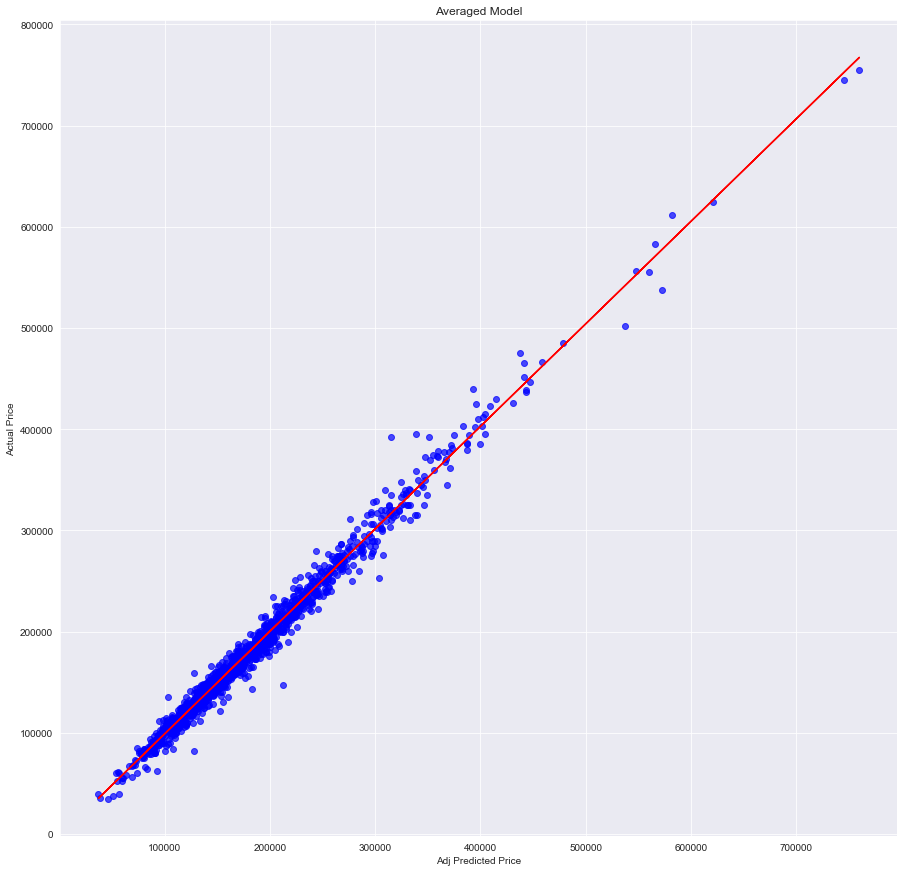

In [221]:
Predicted = sub_train['SalePrice2']
Actual = inv_boxcox1p(y_train, lam_l)
plt.figure(figsize=(15,15))
plt.scatter(sub_train['SalePrice2'], Actual, alpha=.7,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Adj Predicted Price')
plt.ylabel('Actual Price')
plt.title('Averaged Model')

m, b = np.polyfit(Predicted, Actual, 1)
#m = slope, b=intercept
plt.plot(Predicted, m*Predicted+b,c='red')
plt.show()

correlation looks much better at the high end

In [222]:
# Post adjustment for high score
print("mae for boxcox(SalePrice2)",mae(y_train, sub_train['SalePrice2']))
print("mse for boxcox(SalePrice2)",rmsle(y_train, sub_train['SalePrice2']))
print("mae for SalePrice2",mae(Actual, Predicted))
print("mse for SalePrice2",rmsle(Actual, Predicted))

mae for boxcox(SalePrice2) 180564.0348739566
mse for boxcox(SalePrice2) 196664.6557164754
mae for SalePrice2 6526.842814287686
mse for SalePrice2 9415.86736800649


Now try to improve upon this

Find best cutoff and adjustment at low end

In [223]:
def AdjustLow(sub_train, y_train):
    AdjustedScores = []
    for i in np.arange(.00, .02, 0.001):
        for j in np.arange(.90, 1.10, 0.01):

            q1 = sub_train['SalePrice'].quantile(i)
            q2 = sub_train['SalePrice'].quantile(0.1)
            q3 = sub_train['SalePrice'].quantile(.995)

            #Verify the cutoffs for the adjustment
            #print(q1,q2,q3)
            # adjust at low end
            sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if x > q1 else x*j)
            #sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if x > q2 else x*0.89)

            # adjust at high end
            #sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if x < q3 else x*j)

            Predicted = sub_train['SalePrice2']
            Actual = inv_boxcox1p(y_train, lam_l)

            # Pre-adjustment score
            #print("mae for boxcox(SalePrice)",mae(y_train, sub_train['SalePrice2']))
            #print("mse for boxcox(SalePrice)",rmsle(y_train, sub_train['SalePrice2']))
            #print("mae for SalePrice",mae(Actual, Predicted))
            #print("mse for SalePrice",rmsle(Actual, Predicted))

            AdjustedScores.append([i, j, mae(y_train, boxcox1p(sub_train['SalePrice2'], lam_l)), rmsle(y_train, boxcox1p(sub_train['SalePrice2'], lam_l)), mae(Actual, Predicted), rmsle(Actual, Predicted)])
  
    df_adj = pd.DataFrame(AdjustedScores, columns=["QUANT","COEF","MAE_BC","RMSE_BC","MAE_SP","RMSE_SP"])
    print('quantiles vs coefficients')
    df_adj.sort_values(by=['RMSE_BC'])
    print(df_adj)
    df2 = df_adj.sort_values(by=['RMSE_BC']).reset_index()
    coef_lo = df2.COEF[0]
    quant_lo = df2.QUANT[0]
    return (coef_lo, quant_lo)

cl, ql = AdjustLow(sub_train, y_train)

quantiles vs coefficients
     QUANT  COEF  MAE_BC  RMSE_BC   MAE_SP   RMSE_SP
0    0.000 0.900   2.575    3.598 6696.184 10012.341
1    0.000 0.910   2.574    3.598 6695.932 10012.191
2    0.000 0.920   2.574    3.597 6695.679 10012.050
3    0.000 0.930   2.574    3.597 6695.426 10011.918
4    0.000 0.940   2.573    3.596 6695.173 10011.796
..     ...   ...     ...      ...      ...       ...
415  0.019 1.060   2.590    3.642 6718.386 10037.884
416  0.019 1.070   2.596    3.654 6726.704 10045.141
417  0.019 1.080   2.602    3.666 6735.434 10053.199
418  0.019 1.090   2.608    3.680 6744.163 10062.056
419  0.019 1.100   2.615    3.695 6753.925 10071.710

[420 rows x 6 columns]


In [224]:
print('cl',cl)
print('ql',ql)

cl 0.92
ql 0.01


In [225]:
q1 = sub_train['SalePrice'].quantile(ql)
q2 = sub_train['SalePrice'].quantile(0.1)
q3 = sub_train['SalePrice'].quantile(qh)

#Verify the cutoffs for the adjustment
print(q1,q2,q3)
# adjust at low end

#sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if (x > q1) else x*cl) 
#sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if x > q2 else x*0.89)

# adjust at high end

#sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if (x < q3) else x*ch)

sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x*cl if x < q1 else ( x*ch if x > q3 else x))
sub_train.query("SalePrice != SalePrice2")

68962.57709929664 105964.40811767711 483711.9686962493


Id  SalePrice  SalePrice2
30      31  56922.999   52369.159
178    179 497816.361  537641.670
375    376  55665.634   51212.384
440    441 518969.131  560486.661
495    496  46013.116   42332.067
533    534  36849.857   33901.868
620    621  65626.446   60376.331
636    637  54022.956   49701.119
691    692 703840.423  760147.657
705    706  59580.228   54813.810
710    711  59573.323   54807.457
769    770 530126.649  572536.781
803    804 523654.882  565547.273
812    813  68831.993   63325.433
898    899 538906.745  582019.285
916    917  38049.595   35005.627
968    969  50919.540   46845.977
1046  1047 506988.116  547547.166
1100  1101  56547.640   52023.828
1169  1170 575458.245  621494.904
1182  1183 690622.270  745872.051
1325  1326  59845.248   55057.628
1337  1338  54842.320   50454.935
1380  1381  63105.562   58057.117

In [226]:
#sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x if (x > q1 and x < q3) else x*cl) 
sub_train['SalePrice2'] = sub_train['SalePrice'].apply(lambda x: x*cl if x < q1 else ( x*ch if x > q3 else x))

#                                                       lambda x: x*10 if x<2 else (x**2 if x<4 else x+10)

sub_train.query("SalePrice != SalePrice2")

Id  SalePrice  SalePrice2
30      31  56922.999   52369.159
178    179 497816.361  537641.670
375    376  55665.634   51212.384
440    441 518969.131  560486.661
495    496  46013.116   42332.067
533    534  36849.857   33901.868
620    621  65626.446   60376.331
636    637  54022.956   49701.119
691    692 703840.423  760147.657
705    706  59580.228   54813.810
710    711  59573.323   54807.457
769    770 530126.649  572536.781
803    804 523654.882  565547.273
812    813  68831.993   63325.433
898    899 538906.745  582019.285
916    917  38049.595   35005.627
968    969  50919.540   46845.977
1046  1047 506988.116  547547.166
1100  1101  56547.640   52023.828
1169  1170 575458.245  621494.904
1182  1183 690622.270  745872.051
1325  1326  59845.248   55057.628
1337  1338  54842.320   50454.935
1380  1381  63105.562   58057.117

Show both adjustments

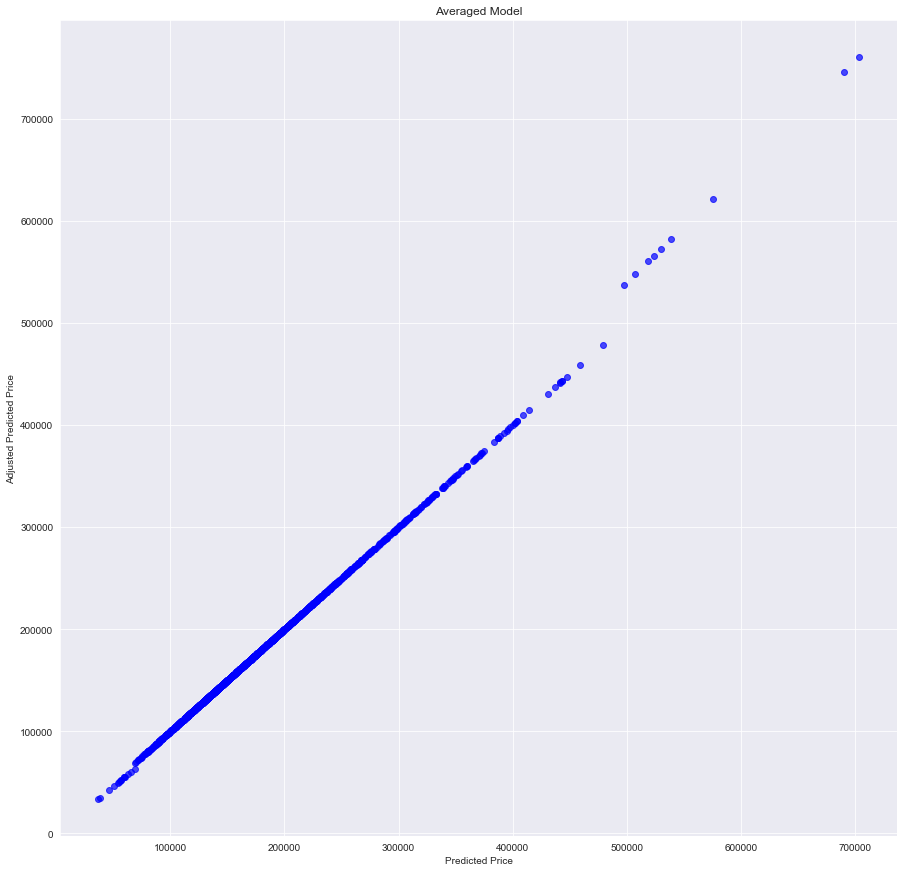

In [227]:
plt.figure(figsize=(15,15))
plt.scatter(sub_train['SalePrice'], sub_train['SalePrice2'], alpha=.7,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Adjusted Predicted Price')
plt.title('Averaged Model')
plt.show()

Show new predictions

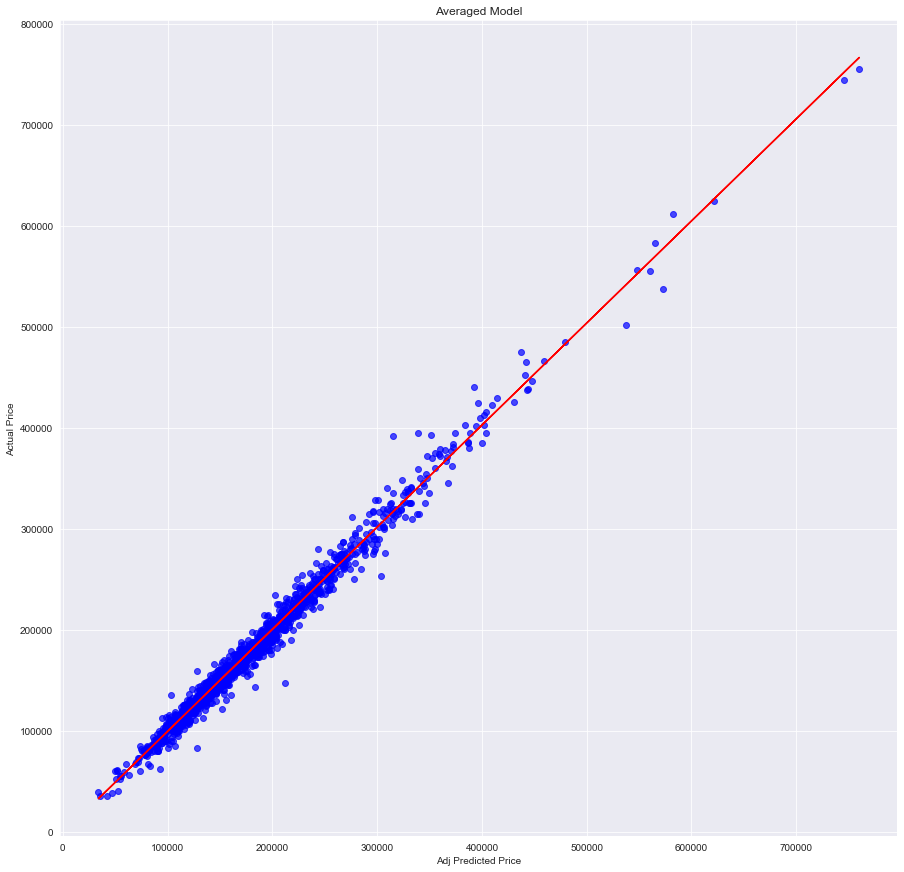

In [228]:
Predicted = sub_train['SalePrice2']
Actual = inv_boxcox1p(y_train, lam_l)
plt.figure(figsize=(15,15))
plt.scatter(sub_train['SalePrice2'], Actual, alpha=.7,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Adj Predicted Price')
plt.ylabel('Actual Price')
plt.title('Averaged Model')

m, b = np.polyfit(Predicted, Actual, 1)
#m = slope, b=intercept
plt.plot(Predicted, m*Predicted+b,c='red')

plt.show()

In [229]:
sub_train.query("SalePrice != SalePrice2")

Id  SalePrice  SalePrice2
30      31  56922.999   52369.159
178    179 497816.361  537641.670
375    376  55665.634   51212.384
440    441 518969.131  560486.661
495    496  46013.116   42332.067
533    534  36849.857   33901.868
620    621  65626.446   60376.331
636    637  54022.956   49701.119
691    692 703840.423  760147.657
705    706  59580.228   54813.810
710    711  59573.323   54807.457
769    770 530126.649  572536.781
803    804 523654.882  565547.273
812    813  68831.993   63325.433
898    899 538906.745  582019.285
916    917  38049.595   35005.627
968    969  50919.540   46845.977
1046  1047 506988.116  547547.166
1100  1101  56547.640   52023.828
1169  1170 575458.245  621494.904
1182  1183 690622.270  745872.051
1325  1326  59845.248   55057.628
1337  1338  54842.320   50454.935
1380  1381  63105.562   58057.117

In [230]:
# Post adjustment for low and high score
print("mae for boxcox(SalePrice2)",mae(y_train, sub_train['SalePrice2']))
print("mse for boxcox(SalePrice2)",rmsle(y_train, sub_train['SalePrice2']))
print("mae for SalePrice2",mae(Actual, Predicted))
print("mse for SalePrice2",rmsle(Actual, Predicted))

mae for boxcox(SalePrice2) 180518.69076107768
mse for boxcox(SalePrice2) 196652.17970866084
mae for SalePrice2 6515.074166454166
mse for SalePrice2 9405.980444391762


Residuals Plot: Actual vs Predicted for Train data - test for normality of residual errors
can't plot the stacked model, get an error so plot each model individually

C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


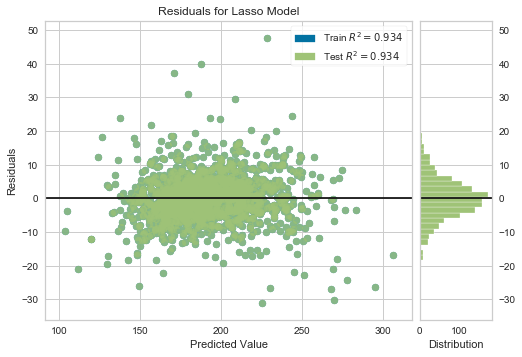

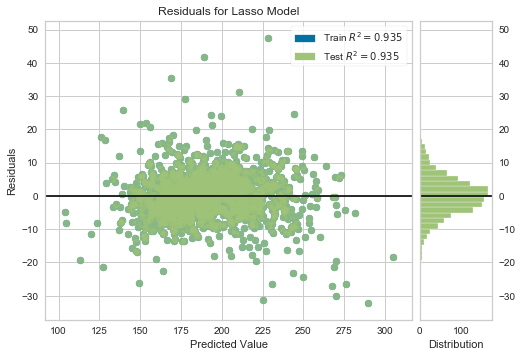

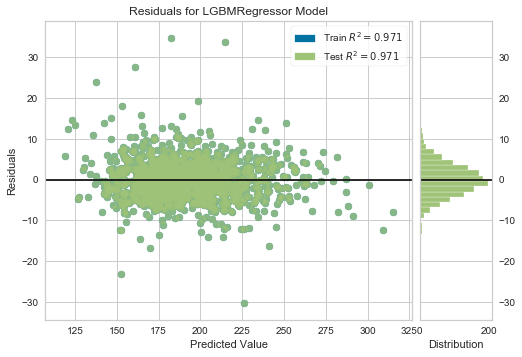

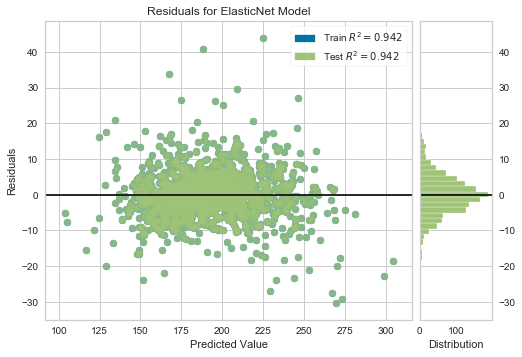

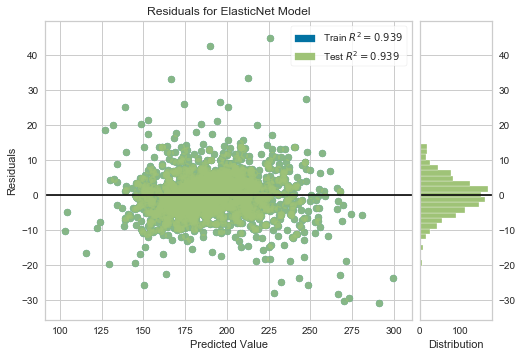

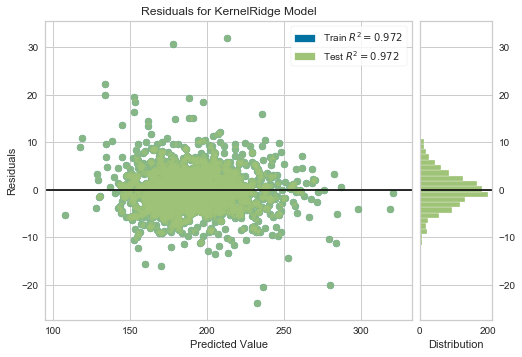

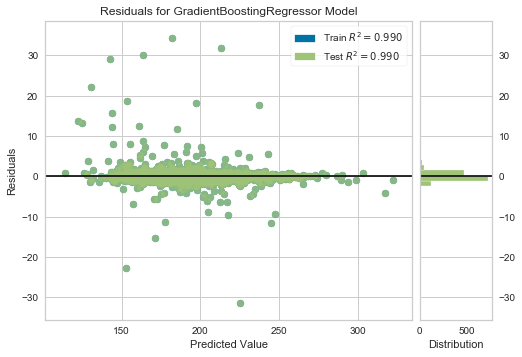

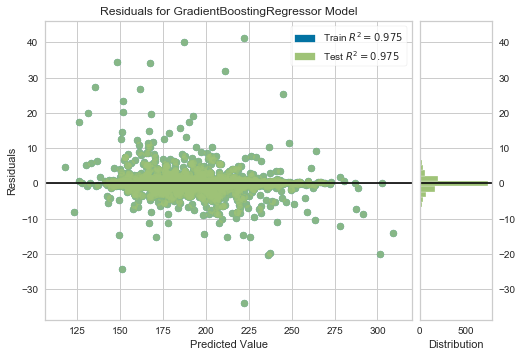

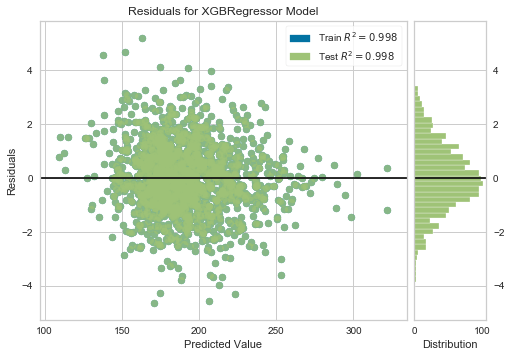

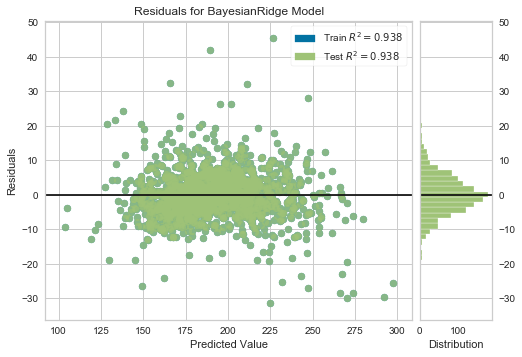

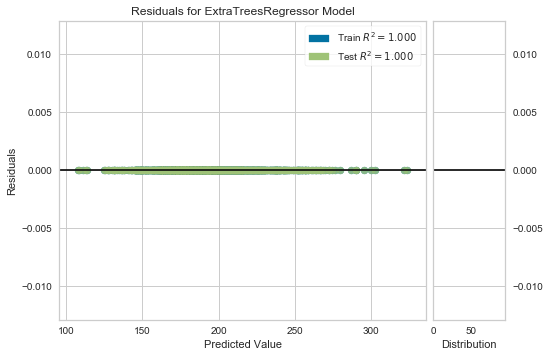

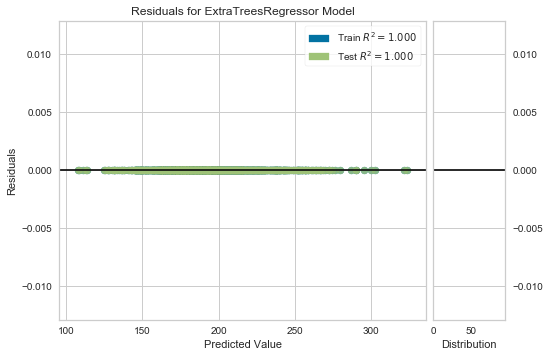

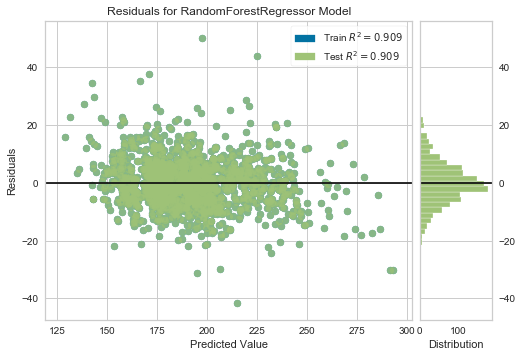

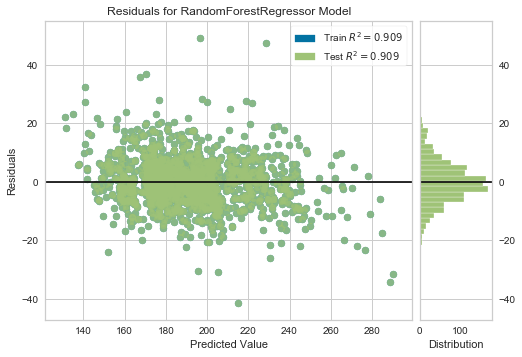

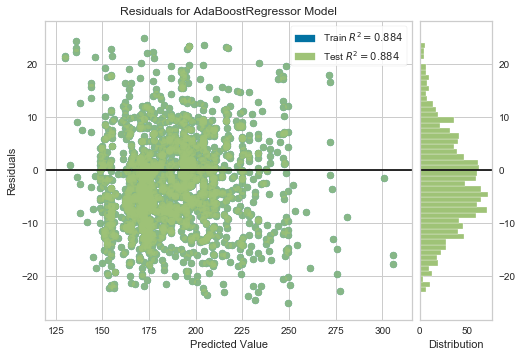

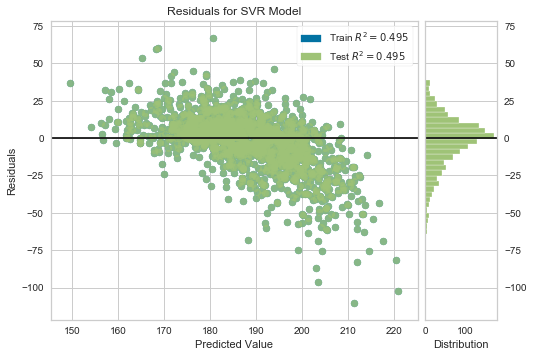

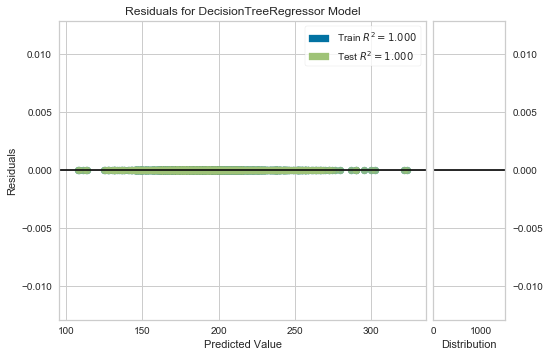

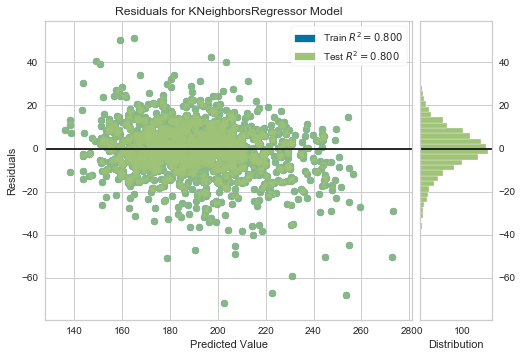

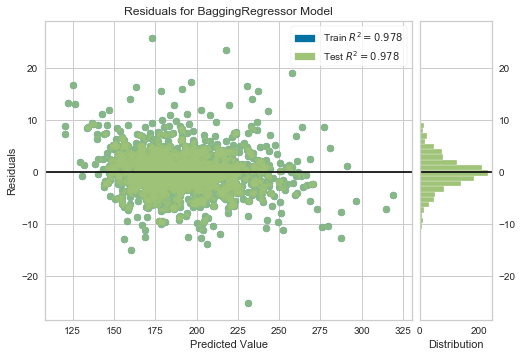

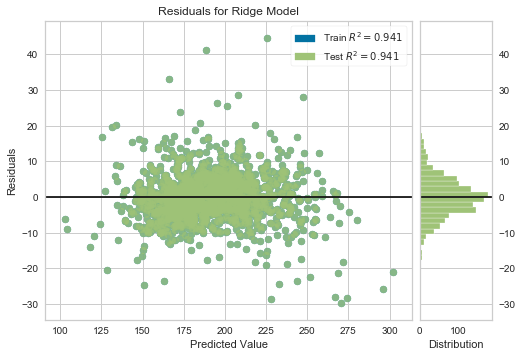

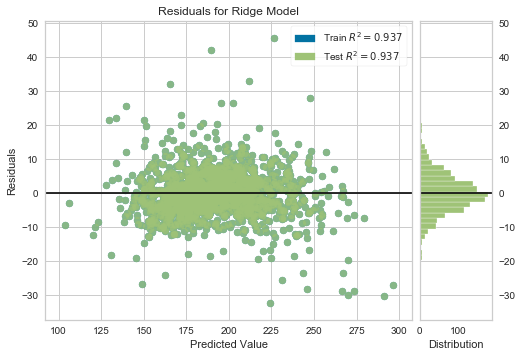

In [231]:
from yellowbrick.regressor import ResidualsPlot

models = [lasso, lasso_new, model_lgb, ENet, ENet_new, KRR, GBoost, GBoost_new, model_xgb, BR, ET, ET_new, RF, RF_new, AB, SVR, DT, KN, B, R, R_new]#, CBoost, CBoost_new] # Catboost does not work
for model in models:
    visualizer = ResidualsPlot(model)
    visualizer.fit(train, y_train)  # Fit the training data to the visualizer
    visualizer.score(train, y_train)  # Evaluate the model on the test data
    visualizer.show()                 # Finalize and render the figure

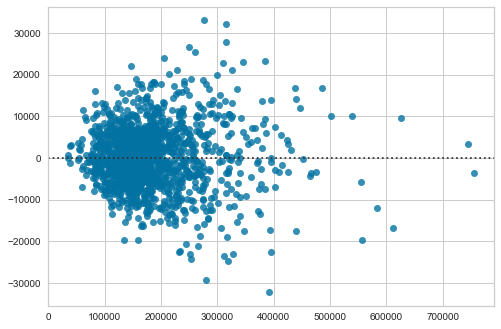

In [232]:
import seaborn
seaborn.residplot(Actual, cb_train_pred)

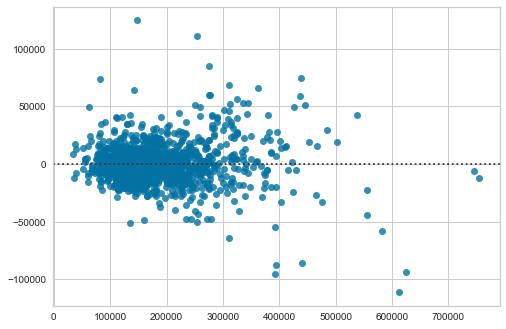

In [233]:
seaborn.residplot(Actual, dnn_train_pred)

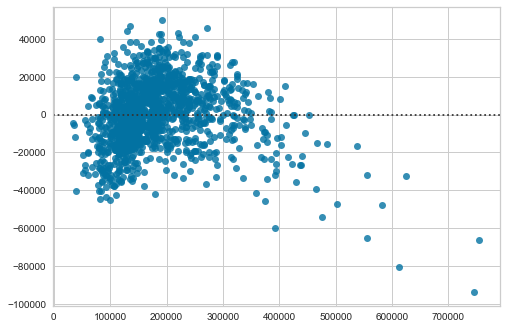

In [234]:
from sklearn.svm import SVR
svr_new = SVR()
svr_new.fit(train,y_train)
svr_train_pred = svr_new.predict(train)

seaborn.residplot(Actual, inv_boxcox1p(svr_train_pred, lam_l))
plt.savefig("out.png")

Final stacked model

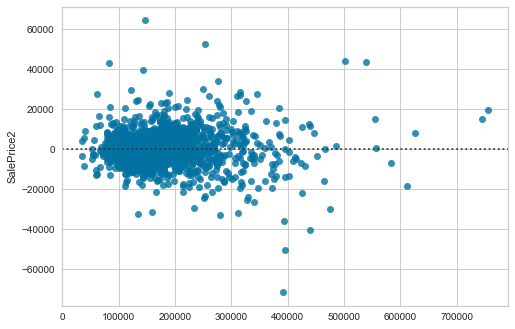

In [235]:
seaborn.residplot(Actual, Predicted)
plt.savefig("out.png")

distribution of residual errors looks normal except for ET() and SVR()

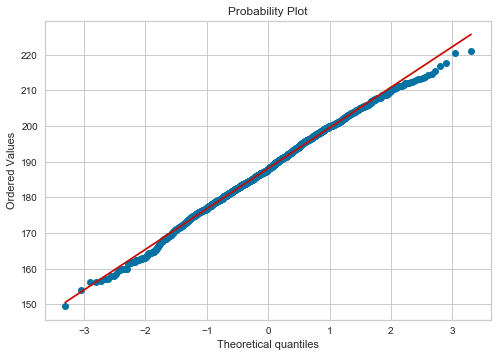

In [236]:
#View the QQ-plot
fig = plt.figure()
res = stats.probplot(svr_train_pred, plot=plt)
plt.show()

**Create File for Submission to Kaggle**

In [237]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
#sub.to_csv('submission.csv',index=False)

Making the same adjustment on the test data for our submission

In [238]:
adjust_both = 0
adjust_low = 0
adjust_high = 1

q1 = sub['SalePrice'].quantile(ql)
q2 = sub['SalePrice'].quantile(0.1)
q3 = sub['SalePrice'].quantile(qh)

if (adjust_both == 1):
    sub['SalePrice'] = sub['SalePrice'].apply(lambda x: x*cl if (x < q1) else ( x*ch if (x > q3) else x))
elif (adjust_low == 1):
    sub['SalePrice'] = sub['SalePrice'].apply(lambda x: x if (x > q1) else x*cl) 
elif (adjust_high == 1):
    sub['SalePrice'] = sub['SalePrice'].apply(lambda x: x if (x < q3) else x*ch)
else:
    print("no adjustments made")

In [239]:
sub.to_csv('submission.csv',index=False)

In [240]:
sub.head()

Id  SalePrice
0  1461 123416.615
1  1462 167055.839
2  1463 189175.658
3  1464 193418.180
4  1465 193062.957

In [241]:
print("Start: ", StartTime)
print("End: ", datetime.datetime.now())

Start:  2020-09-03 22:43:45.504708
End:  2020-09-04 07:37:11.352549


In [242]:
from mlens.ensemble import SuperLearner
ensemble2 = SuperLearner(random_state=1, verbose=2)

[MLENS] backend: threading


In [243]:
# http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/
# accuracy levels off at k_features=25, this code takes several hours to run!!
feature_select = 0
if (feature_select == 1):
    from mlxtend.feature_selection import SequentialFeatureSelector as SFS

    sfs1 = SFS(CBoost_new, 
               k_features=50, 
               forward=True, 
               floating=False, 
               verbose=2,
               scoring='neg_mean_squared_error',
               cv=2)

    sfs1 = sfs1.fit(train, y_train)

    from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
    import matplotlib.pyplot as plt

    fig = plot_sfs(sfs1.get_metric_dict(), kind='std_err')

    plt.title('Sequential Forward Selection (w. StdErr)')
    plt.grid()
    plt.show()

In [244]:
if (feature_select == 1):
    # Generate the new subsets based on the selected features
    # Note that the transform call is equivalent to
    # X_train[:, sfs1.k_feature_idx_]

    X_train_sfs = sfs1.transform(train)
    X_test_sfs = sfs1.transform(test)

    # Fit the estimator using the new feature subset
    # and make a prediction on the test data
    CBoost_new.fit(X_train_sfs, y_train)
    y_pred = CBoost_new.predict(X_train_sfs)

    # Compute the accuracy of the prediction
    #classification
    #acc = float((y_train == y_pred).sum()) / y_pred.shape[0]
    #print('Test set accuracy: %.2f %%' % (acc * 100))
    #regression
    print("mae",mae(y_train, y_pred))
    print("rmsle",rmsle(y_train, y_pred))

In [245]:
print("End: ", datetime.datetime.now())

End:  2020-09-04 07:37:15.092582


In [247]:
if (method == "stacked"):
    print(stacked_averaged_models)
    print(stacked_averaged_models.meta_model.get_params())

<pre>
1)   11781.87529     Original
2)   11711.80408     move averaged_model code from Ensemble_73 notebook
3)   11755.28295     move to stacked model
4)   11888.77687     add CBoost_new to base_models:  (ENet, GBoost, KRR, BR, CBoost_new)
5)   11888.77687     retry
6)   11904.73136     remove GBoost (ENet, KRR, BR, CBoost_new)
7)   11709.32360     revert to (ENet, GBoost, KRR, BR) use CBoost_new in the averaged part (xgb, lgb, cb) (.10,.10,.10)
8)   11686.46788     try different ratio (.10,.05,.15)
9)   11672.31686     try another ratio (.10,.01,.19) 
10)  11669.76682     another ratio (.05,.01,.24)
11)  11677.88360     another ratio (.00,.00,.30)
12)  11668.44304     remove lgb only (.05,.00,.25)
13)  11669.04168     now try to increase the xgb ratio (.10,.00,.20)
14)  11625.18894     model_xgb random_state=2 (was 7)
15)  11613.88646     model_xgb random_state=35
16)  11616.30327     check ensemble/averaged score (score to beat is 11655)
17)  13803.54887     use saved file from FeatureSelection=50 for all datasets
18)  13351.98762     try with stacking
19)  11613.88646     revert to #15, full dataset
20)                  lr only, averaged_models -> 3 bad predictions (id=1594,2121,2905)
21)  28232.03296     lr_poly only
22)  14739.49921     ENet_poly
23)  14197.84154     lr optimized (fit_intercept=False)
24)  28963.03702     lr_poly optimized
25)  28232.03296     lr_poly defaults
26)  14197.84154     lr optimized #23
27)  14201.67170     change high adjustment range for quantile: .994 to .980 and multiply by: 1.10 to 1.20
28)  13924.57237     lr_poly using PCA to reduce the number of features (20k to 200), revert to #27 for adjustments
29)  13789.09102     PCA(n_components=360)
30)  15948.10915     NMF - Non-Negative Matrix Factorization: (n_components=360,defaults alpha = l1_ratio = 0)
31)  13972.13677     optimized alpha and l1_ratio
32) use SelectKBest: k = 360, f_regression => too many missing, very high and very low, values
33)  13908.96621     CBoost_poly, Try SelectKBest with CBoost_new => works okay but score is worse. At least SelectKBest can produce valid scores for all rows with this algorithm
34)  12945.71600     CBoost_poly: Try poly with CBoost_new, no feature selection
35)  19349.45291     CBoost_poly: add PCA to poly, n_components=360
36)  20887.29175     n_components=1000
37)  24090.89712     PCA but use all features, add random_state=0
38)  12838.23056     CBoost_new pipeline, with poly, n_estimators=3500, remove PCA as it does not perform well at any parameter settings
39)  13397.69326     CBoost_new pipeline, with poly, optimized settings: k=1500, n_estimators=2000
40)  11610.46960     use everything in the stacked part, ENet, GBoost, KRR, BR, xgb, lgb and cb still with .70 weighting
41)  12456.65219     all stacked, CBoost only
42)  12066.47424     all stacked, CBoost and KRR
43)  11911.33866     all stacked, base_models = (CBoost_new, KRR, model_xgb)
44)  11826.13805     all stacked, base_models = (CBoost_new, KRR, model_xgb, BR)
45)  11839.80086     base_models = (CBoost_new, KRR, model_xgb, BR, GBoost)
46)  11797.25832     base_models = (CBoost_new, KRR, model_xgb, BR, ENet), remove GBoost as it makes the score worse, add ENet
47)  11799.19252     base_models = (CBoost_new, KRR, model_xgb, BR, ENet, model_lgb)
48)  11613.88646     revert to #19 base_models = (ENet, KRR, BR, GBoost) + R_new
49)  11726.83000     everything in the (.70) stacked part: base_models = (CBoost_new, KRR, model_xgb, BR, ENet, GBoost, model_lgb)
50)  11799.28313     too many, use these only: base_models = (ENet, KRR, BR, CBoost_new)
51)  13715.43547     try ENet only, stacking only
52)  12712.76481     base_models = (ENet, KRR)
53)  12751.55440     base_models = (ENet, KRR, BR)
54)  11826.60122     base_models = (ENet, KRR, GBoost)
55)  11879.33777     base_models = (ENet, KRR, GBoost, CBoost_new) n_estimators=1700
56)  11696.61863     base_models = (ENet, KRR, GBoost, model_xgb)
57)  11722.37128     base_models = (ENet, KRR, GBoost, model_xgb, model_lgb)
58)  11767.30210     base_models = (ENet, KRR, GBoost, model_xgb, CBoost_new) n_estimators=3500
59)  11694.95810     base_models = (ENet, KRR, GBoost, model_xgb, lr_poly), PCA(n_components=360)
60)  11617.31540     reduce stacking to .70, add xgb .10, cb .20 back to model
61)  11627.68558     add BR to averaged  xgbr .07, cbr .16, BR .07
62)  11654.13031     replace BR with lgb: xgbr .07, cbr .16, lgbr .07
63)  11616.89215     revert to #60
64)  11613.71535     rerun same settings, lr_poly and stacked_average change each time
65)  11692.93377     StackingAveragedModels n_folds=20
66)  11616.85524     revert to #63, n_folds back to 10
67)  11614.61863     look at errors for normal distribution, etc
68)  14615.79289     use dnn model only in averaged_models calc
69)  11722.85135     revert to averaged_models, using (CBoost_new,model_xgb,ENet,GBoost,KRR,BR)
70)  11616.30327     use VotingRegressor with weights (CBoost_new,model_xgb,ENet,GBoost,KRR,BR)
71)  11616.30327     fix lasso convergence errors
72)  11609.72514**   try to fix ENet non-convergence, use tol = 0.01 and find best for other parameter settings
73)  11615.05001     verify stacked method still working
73e) 11609.72514     verify ensemble also
74)  11608.09702     add dnn to stacked/base model list
74e) 11650.46685     verify ensemble, but using averaged not using VotingRegressor, use CBoost_new twice
75)  11595.02554*    remove dnn from stacked, but leave it in the ensemble method, add seed = 7 for dnn
76)  11603.44785     using dnn with SGD as optimizer, shuffle=False
77)  11623.09195     SGD with shuffle=True
78)  11600.44132     revert to Adam as optimizer
79)  11645.80657     use LearningRateScheduler and SGD for dnn
80)  11639.52100     use LearningRateScheduler with Adam for dnn
81)  11604.18732     EarlyStopping on val_loss
82)  11770.93048     normalize train and test data (to work better with dnn)
82e) 13807.38879     test on averaged class, with normalized data
83)  11636.50751     remove MinMax
83e) 11704.90957     test ensemble/averaged
84)  11651.95404     use MinMax on dnn model only
84e) 11655.72651     verify ensemble method
85)  11644.03728     use dnn/adam as metamodel only
86)  11610.86120     not using dnn, revert to R_new as metamodel, upt enet_tol = 0.001 back in, max_iter=500
86e) 11609.72514**   ensemble method



compare nmse for train for new vs old models, test is worse for new, is train also worse (underfit), or better (overfit)?

* best score stacking and averaging
** best score for averaging only


find and try other ridge regression and lasso regression algorithms and techniques

done:   
    try pca on features => no improvement in score. will drop this for now
    change ratios of models to find which is best predictor (gives best score), then work on improving that model first
    change scale factor of 3 models => score does not correlate to rmsle, try to find a better metric
    try StandardScaler and np.clip on features, currently see RobustScaler() being used but i already screened fliers so StandardScaler should be adequate
    more filtering of fliers
    use PCA or other for lr_poly pipeline as there may be too many features now
    use GridsearchCV to find optimal parameters, however, need to find the best way to evaluate the scores. RMSLE doesn't seem to match well...

to do:
    plot the error (pred-act) and squared_error
    add lgb to stacked, try RF,ET as meta-model even CBoost_new or lgb
    need to investigate why using BoxCox1p is (slightly) better than the evaluation metric further...  
    try different pipelines, scaler, etc
    reference: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py
    
    ideas from other kernels:

    add new features for non-linear features (OverallQual, etc) add a new column with log or square of feature
       
    tune min_samples_leaf and min_samples_split for GradientBoostingRegressor!
    
    add linear regression from here: https://github.com/chouhbik/Kaggle-House-Prices/blob/master/Kaggle-house-prices-KamalChouhbi.ipynb
    
https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/    
    
Look at this later for deep learning stacking: https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/


try different pipelines, scaler, etc
reference: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

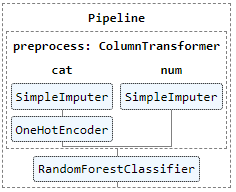

Try polynomial features:
reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html#sphx-glr-auto-examples-model-selection-plot-underfitting-overfitting-py
from sklearn.preprocessing import PolynomialFeatures

polynomial_features = PolynomialFeatures(degree=degrees[i],
                                         include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])

scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                         scoring="neg_mean_squared_error", cv=10)       
                             
                             
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('lda', LinearDiscriminantAnalysis()))
model = Pipeline(estimators)    


features = []
features.append(('pca', PCA(n_components=3)))
features.append(('select_best', SelectKBest(k=6)))
feature_union = FeatureUnion(features)
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('logistic', LogisticRegression()))
model = Pipeline(estimators)

Individual Model result comparision

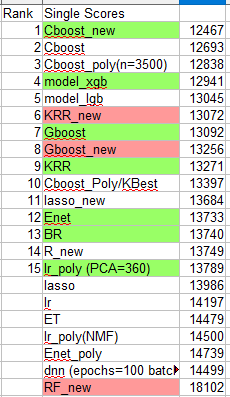